# Init results

In [14]:
#%%capture
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import cortex
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import sys
import yaml
import time
from collections import defaultdict as dd
from scipy.stats import sem, ks_2samp
import seaborn as sns
import pandas as pds
import dill

opj = os.path.join

from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

from prfpytools.preproc_utils import *
from prfpytools.postproc_utils import *
from prfpytools.visualize_results import visualize_results

from IPython.core.display import display, HTML

sound_file = '/Users/marcoaqil/Downloads/filling-your-inbox.mp3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_72820/912037629.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [15]:
#results object
current_results = results()
                        

## Combine & Process results

In [53]:
current_results.combine_results(results_folder='/Volumes/Crucial_X8/SM-pRF/derivatives/prfpy', 
                    timecourse_folder='/Volumes/Crucial_X8/SM-pRF/derivatives/timecourses',
                               calculate_CCrsq=False,
                               calculate_noise_ceiling=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.36it/s]


In [54]:
current_results.main_dict['fsnative']['fit-task-2R_fit-runs-all']['sub-001_ses-2'].keys()

dict_keys(['Results', 'mask', 'analysis_info', 'Timecourse Stats'])

In [55]:
mergedict_OR(current_results.main_dict,vis_res.main_dict)

In [56]:
current_results.process_results(current_results.main_dict,
                                compute_suppression_index = False,
                                return_norm_profiles = False)

  0%|                                                                                                                                                | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                                                               | 0/14 [00:00<?, ?it/s]/Users/marcoaqil/prfpytools/prfpytools/postproc_utils.py:532: RuntimeWarning: divide by zero encountered in divide
  x=np.linspace(-50,50,1000).astype('float32')
/Users/marcoaqil/prfpytools/prfpytools/postproc_utils.py:403: RuntimeWarning: invalid value encountered in divide
  processed_results['Surround Amplitude'][k2][mask] = np.copy(v2[:,5])
/Users/marcoaqil/prfpytools/prfpytools/postproc_utils.py:406: RuntimeWarning: invalid value encountered in divide
  processed_results['Norm Param. B'][k2][mask] = np.copy(v2[:,7])
/Users/marcoaqil/prfpytools/prfpytools/postproc_utils.py:407: RuntimeWarning: invalid value encountered in divide
  processed_res

# Init visualize results

In [16]:
vis_res = visualize_results(current_results)

## Fix HCP MSMall ordering (run once on HCP data)

In [24]:
#fix HCP ordering
if 'HCP' in vis_res.main_dict:
    hcp_atlas_mask_path = ['/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/L.atlasroi.59k_fs_LR.shape.gii',
                          '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/R.atlasroi.59k_fs_LR.shape.gii']
    vis_res.fix_hcp_ordering(vis_res.main_dict['HCP'], hcp_atlas_mask_path)

## Load previous visualize_result.main_dict

In [17]:
#extremely useful in cases of having to unpickle objects when class/module/function names have been changed
class RenameUnpickler(dill.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        if "utils." in module:
            renamed_module = module.replace("utils.","prfpytools.")

        return super(RenameUnpickler, self).find_class(renamed_module, name)

def renamed_load(file_obj):
    return RenameUnpickler(file_obj).load()

In [18]:
#rsqwm have rsq-weighted means over subjects on fsaverage
#maindict_ #allall, allruns_sepcond_rsqwm, 5050CV, allruns_sepcond_zsc, 
#HCP_181subjects_rsqwm, HCP_999999, 99mean181, 99split20 (these 99 are bar-only), HCP_cv (tcfit), HCP_tc_nocv, HCP_allruns_allconds_78sj 
#HCP_hrffit #HCP_99hrffit (this99  is all conditions) #hrffit_onlyfsavcvrsq
with open('/Volumes/Crucial_X8/maindict_smprf2.pickle', 'rb') as handle:
    vis_res.main_dict=renamed_load(handle)

## Save current visualize_result.main_dict

In [58]:
with open('/Volumes/Crucial_X8/maindict_smprf2.pickle', 'wb') as handle:
     dill.dump(vis_res.main_dict, handle)

## Load/Save rois (run always)

In [19]:
#this function parses or imports labaled ROIs for all subjects (run always)
#set to list of ROI names to output indices of rois for roi-only fitting. empty list for no output
output_rois = []#['custom.OccPole', 'custom.V1','custom.V2','custom.V3','custom.hV4','custom.VO',
                      #'custom.V3AB','custom.LO','custom.TO','custom.IPS','custom.FO']
    
#import flatmaps from freesurfer, if created, and import freesurfer custom rois to pycortex overlays.svg (need pre-imported flatmaps for this)
import_flatmaps = False

output_rois_path = '/Volumes/Crucial_X8/SM-pRF/derivatives' #/Volumes/Crucial_X8/PRFMapping/PRFMapping-Deriv-hires
#freesurfer directory
fs_dir = '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer'

#HCP atlas path (without .{hemi}.gii)
hcp_atlas_path = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel' 

vis_res.define_rois_and_flatmaps(fs_dir, output_rois_path, import_flatmaps, output_rois, hcp_atlas_path)

#vis_res.compute_roi_borders(subject_ids = ['fsaverage'], rois_prefix='glasser', previous_borders_path='/Users/marcoaqil/glasser_borders.npy')
    

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V1v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V1v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V1d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V1d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V2v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V2v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V2d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V2d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V3v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V3v.lab

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V3B.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V3B.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.V3A.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.V3A.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.IPS0.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.IPS0.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.IPS1.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.IPS1.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/lh.wang2015atlas.IPS2.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-001/label/rh.wang2015atlas.IP

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/lh.wang2015atlas.V2v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/rh.wang2015atlas.V2v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/lh.wang2015atlas.V2d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/rh.wang2015atlas.V2d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/lh.wang2015atlas.V3v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/rh.wang2015atlas.V3v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/lh.wang2015atlas.V3d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/rh.wang2015atlas.V3d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/lh.wang2015atlas.hV4.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-003/label/rh.wang2015atlas.hV4.lab

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.V1d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.V1d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.V2v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.V2v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.V2d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.V2d.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.V3v.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.V3v.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.V3d.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.V3d.lab

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.IPS2.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.IPS2.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.IPS3.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.IPS3.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.IPS4.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.IPS4.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.IPS5.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atlas.IPS5.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/lh.wang2015atlas.SPL1.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-004/label/rh.wang2015atla

looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/lh.wang2015atlas.PHC2.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/rh.wang2015atlas.PHC2.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/lh.wang2015atlas.TO2.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/rh.wang2015atlas.TO2.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/lh.wang2015atlas.TO1.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/rh.wang2015atlas.TO1.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/lh.wang2015atlas.LO2.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/rh.wang2015atlas.LO2.label']
looking for ['/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/lh.wang2015atlas.LO1.label', '/Volumes/Crucial_X8/SM-pRF/derivatives/freesurfer/sub-005/label/rh.wang2015atlas.LO1.l

In [41]:
np.save('/Users/marcoaqil/glasser_borders.npy',vis_res.idx_rois_borders['fsaverage']['glasser'])

## Project to fsaverage

In [25]:
#projecting results to fsaverage surface
vis_res.project_to_fsaverage(models = ['Norm_abcd'], #'Noise Ceiling (RSq)'],
                             parameters = ['hrf_1','hrf_2','x_pos', 'y_pos','Norm Param. B','Norm Param. D','Size (sigma_1)','Size (sigma_2)','Amplitude', 'Surround Amplitude','Size (fwhmax)','Surround Size (fwatmin)'],# 'Noise Ceiling'],#[
                             space_names = 'HCP',
                             analysis_names = ['fit-task-all_fit-runs-all'],#['fit-task-BAR_fit-runs-all','fit-task-BAR_fit-runs-CVmedian'],#'all', 
                             subject_ids = 'all',#['HCP_cvrsq'],#['725751','100610','765864','109123','158136']
                             hcp_atlas_mask_path = ['/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/L.atlasroi.59k_fs_LR.shape.gii',
                                                    '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/R.atlasroi.59k_fs_LR.shape.gii'],
                             hcp_cii_file_path = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/100610/MNINonLinear/Results/tfMRI_RETBAR1_7T_AP/tfMRI_RETBAR1_7T_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii',
                             hcp_old_sphere = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/resample_fsaverage/fs_LR-deformed_to-fsaverage.?.sphere.59k_fs_LR.surf.gii',
                             hcp_new_sphere = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/resample_fsaverage/fsaverage_std_sphere.?.164k_fsavg_?.surf.gii',
                             hcp_old_area = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/resample_fsaverage/fs_LR.?.midthickness_va_avg.59k_fs_LR.shape.gii',
                             hcp_new_area = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/atlas/resample_fsaverage/fsaverage.?.midthickness_va_avg.164k_fsavg_?.shape.gii',
                             hcp_temp_folder = '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/temp_files')

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]
../utils/visualize_results.py:1446: RuntimeWarning: invalid value encountered in true_divide
  fsaverage_group_average = (data*weights).sum(0)/weights.sum(0)
  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

False
False
HCP fit-task-all_fit-runs-all 999999


pixdim[1,2,3] should be non-zero; setting 0 dims to 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:42<00:00,  7.91s/it]

False
False



../utils/visualize_results.py:1454: RuntimeWarning: Mean of empty slice
  self.main_dict['fsaverage']['Mean analysis']['fsaverage']['Processed Results'][parameter][model] = np.nanmean([self.main_dict['fsaverage'][an[0]]['fsaverage']['Processed Results'][parameter][model] for an in analyses], axis=0)
../utils/visualize_results.py:1464: RuntimeWarning: invalid value encountered in true_divide
  subj_res['Processed Results']['Size ratio (sigma_2/sigma_1)'][model] = subj_res['Processed Results']['Size (sigma_2)'][model]/subj_res['Processed Results']['Size (sigma_1)'][model]
../utils/visualize_results.py:1467: RuntimeWarning: invalid value encountered in true_divide
  subj_res['Processed Results']['Ratio (B/D)'][model] = subj_res['Processed Results']['Norm Param. B'][model]/subj_res['Processed Results']['Norm Param. D'][model]


In [68]:
vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian']['126426'].keys()

dict_keys(['Results', 'mask', 'analysis_info', 'Processed Results'])

In [14]:
for space, space_res in vis_res.main_dict.items(): 
    if space == 'fsaverage':
        for analysis, analysis_res in space_res.items():
#            if analysis == 'fit-task-BAR_fit-runs-CVmedian':
            for subj, subj_res in analysis_res.items():
                if 'fsaverage' in subj: 
                    for receptor in ['GABA_A', '5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']: #['GABA_A']:#
                        if receptor != 'GABA_A':
                            rec_map = np.concatenate((nb.load(f"/Users/marcoaqil/Downloads/5-HT_atlas/{receptor}/{receptor}.mean.bmax.mrtm2.nopvc.fsaverage.lh.sm10.nii.gz").get_data()[:,0,0,0],
                                                 nb.load(f"/Users/marcoaqil/Downloads/5-HT_atlas/{receptor}/{receptor}.mean.bmax.mrtm2.nopvc.fsaverage.rh.sm10.nii.gz").get_data()[:,0,0,0]))
                        else:
                            rec_map = np.concatenate((nb.load(f"/Users/marcoaqil/Downloads/bzr_atlas/Bmax.nopvc.fsaverage.lh.sm10.nii.gz").get_data()[:,0,0,0],
                                                 nb.load(f"/Users/marcoaqil/Downloads/bzr_atlas/Bmax.nopvc.fsaverage.rh.sm10.nii.gz").get_data()[:,0,0,0]))


                        subj_res['Processed Results']['Receptor Maps'][receptor] = np.copy(rec_map)    
                        
#                         if receptor in ['5-HT2A', '5-HT1A']:
#                             subj_res['Processed Results']['Receptor Maps'][f"inv {receptor}"] = 1/np.copy(rec_map)  
                        
os.system(f"open {sound_file}")

/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_32084/2535534808.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  rec_map = np.concatenate((nb.load(f"/Users/marcoaqil/Downloads/bzr_atlas/Bmax.nopvc.fsaverage.lh.sm10.nii.gz").get_data()[:,0,0,0],
/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_32084/2535534808.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  nb.load(f"/Users/marcoaqil/Downloads/bzr_atlas/Bmax.nopvc.fsaverage.rh.sm10.nii.

0

In [ ]:
space='HCP'
an='fit-task-all_fit-runs-all'
for sj in vis_res.main_dict[space][an]:
    print(sj)
    print(len(vis_res.main_dict[space][an][sj]['Processed Results']['RSq']['Norm_abcd']))
    print((vis_res.main_dict[space][an][sj]['Processed Results']['RSq']['Norm_abcd']==0).sum())
    print(np.isnan(vis_res.main_dict[space][an][sj]['Processed Results']['RSq']['Norm_abcd']).sum())
    print((~np.isfinite(vis_res.main_dict[space][an][sj]['Processed Results']['RSq']['Norm_abcd'])).sum())
    print('\n')

In [ ]:
#alpha = vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['Alpha']['all']
#np.sum(vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['Noise Ceiling']['Noise Ceiling (RSq)'][alpha>-10]>-0.86)
#np.sum(vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['RSq']['Norm_abcd']>0.03)
np.nanquantile(vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['Noise Ceiling']['Noise Ceiling (RSq)'][alpha>-10],0.9)

In [ ]:
np.sum(vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['Noise Ceiling']['Noise Ceiling (RSq)'][alpha>-10]>-0.4)

In [ ]:
pl.figure()
alpha = vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['Alpha']['Norm_abcd']
pl.hist(vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-CVmedian']['fsaverage']['Processed Results']['RSq']['Norm_abcd'][alpha>rsq_thresh],bins=200)

# Surface plots

fsnative fit-task-2R_fit-runs-all sub-001_ses-1
fsnative fit-task-2R_fit-runs-all sub-001_ses-2
fsnative fit-task-2R_fit-runs-all sub-001_ses-3
fsnative fit-task-2R_fit-runs-all sub-002_ses-1
fsnative fit-task-2R_fit-runs-all sub-002_ses-2
fsnative fit-task-2R_fit-runs-all sub-003_ses-1
fsnative fit-task-2R_fit-runs-all sub-003_ses-2
fsnative fit-task-2R_fit-runs-all sub-004_ses-1
fsnative fit-task-2R_fit-runs-all sub-004_ses-2
fsnative fit-task-2R_fit-runs-all sub-004_ses-3
fsnative fit-task-2R_fit-runs-all sub-005_ses-1
fsnative fit-task-2R_fit-runs-all sub-005_ses-2
fsnative fit-task-2R_fit-runs-all sub-007_ses-1
fsnative fit-task-2R_fit-runs-all sub-009_ses-1
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


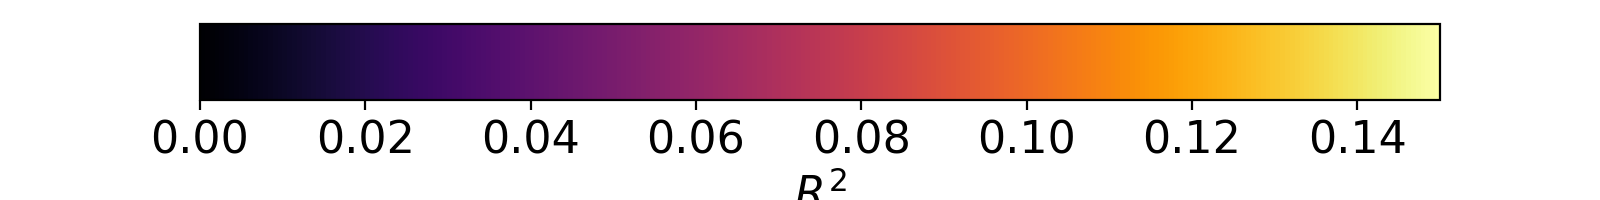

0.0
0.996078431372549


<IPython.core.display.Javascript object>


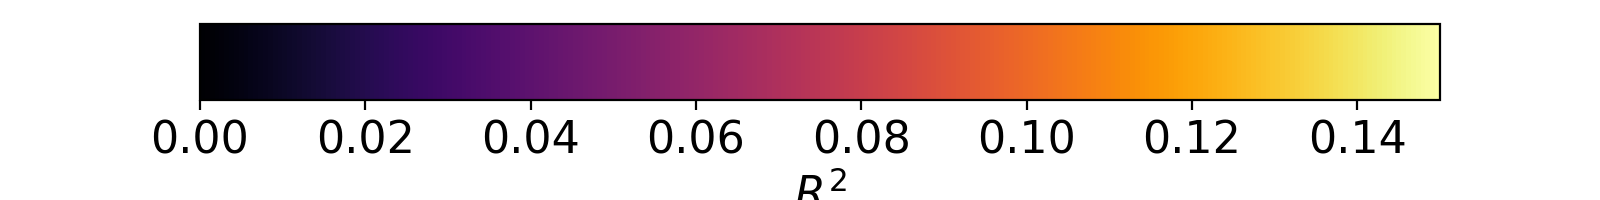

0.0
0.9921568627450981
Started server on port 30998
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


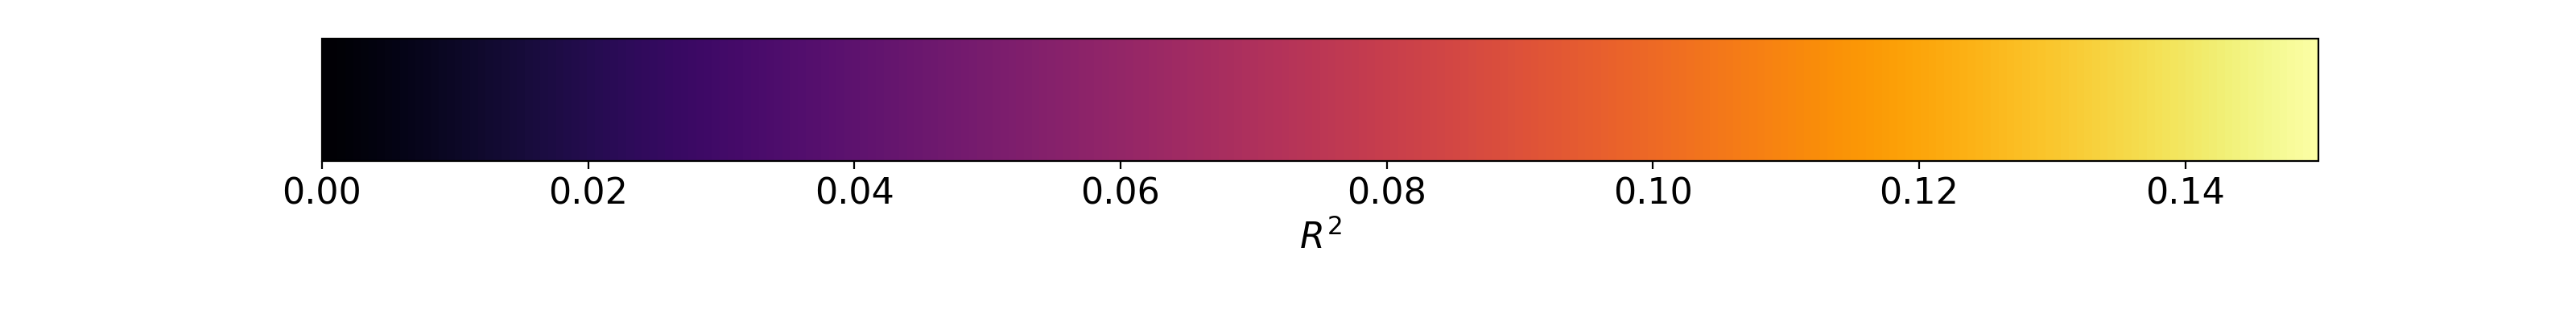

0.0
0.996078431372549


<IPython.core.display.Javascript object>


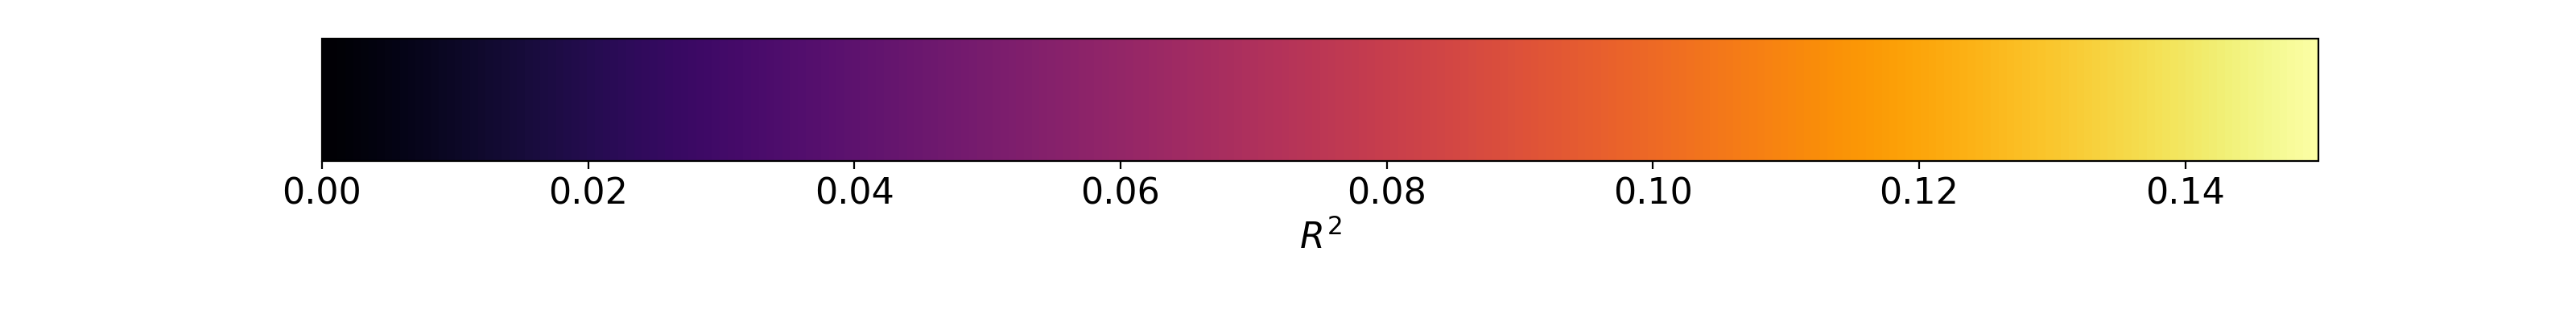

0.0
0.9921568627450981
Started server on port 64498
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


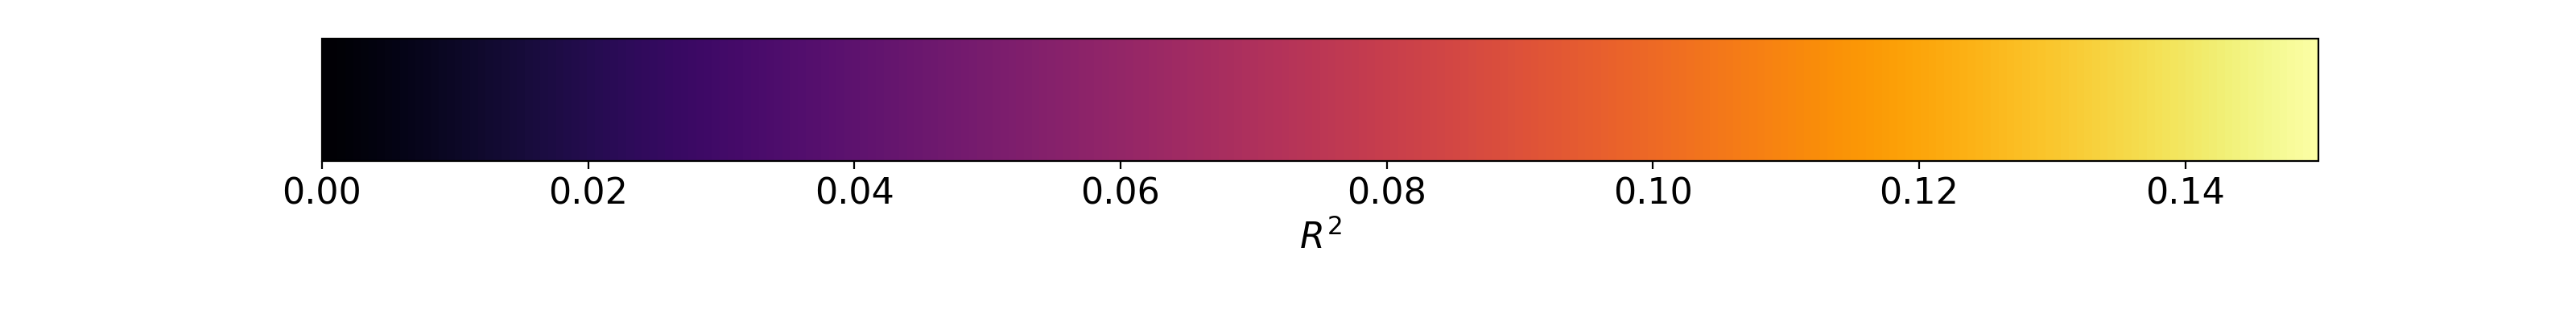

0.0
0.996078431372549


<IPython.core.display.Javascript object>


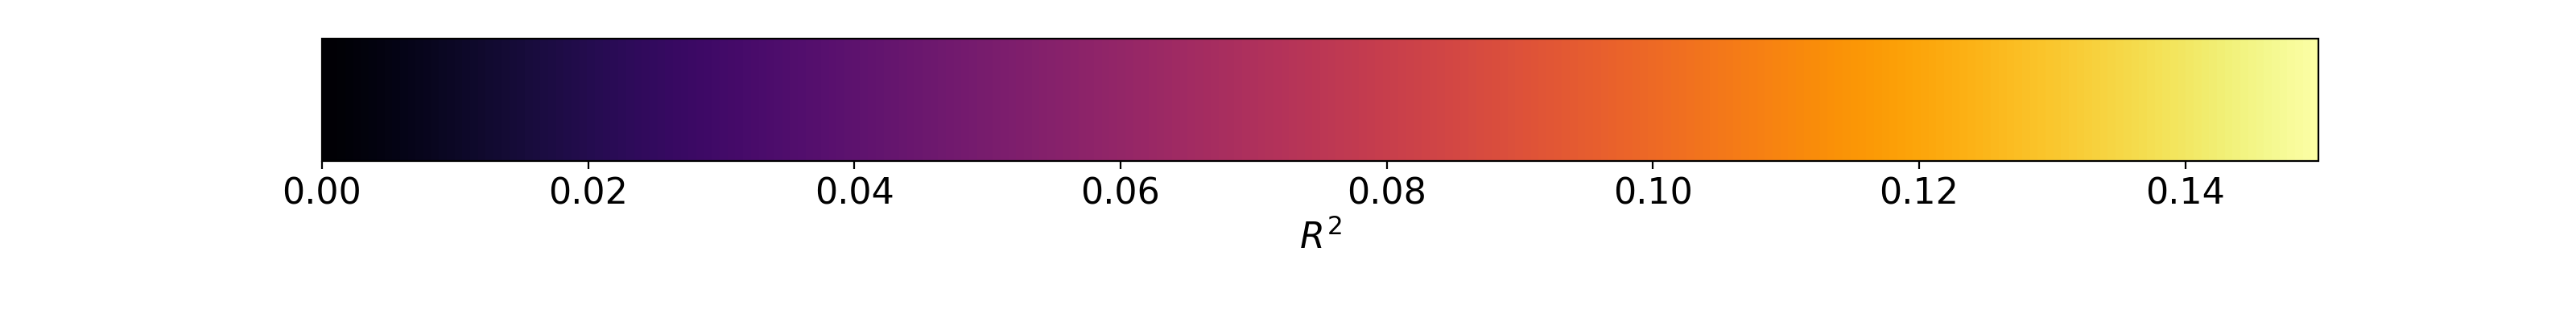

0.0
0.9921568627450981
Started server on port 3755
0.15294117647058825
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


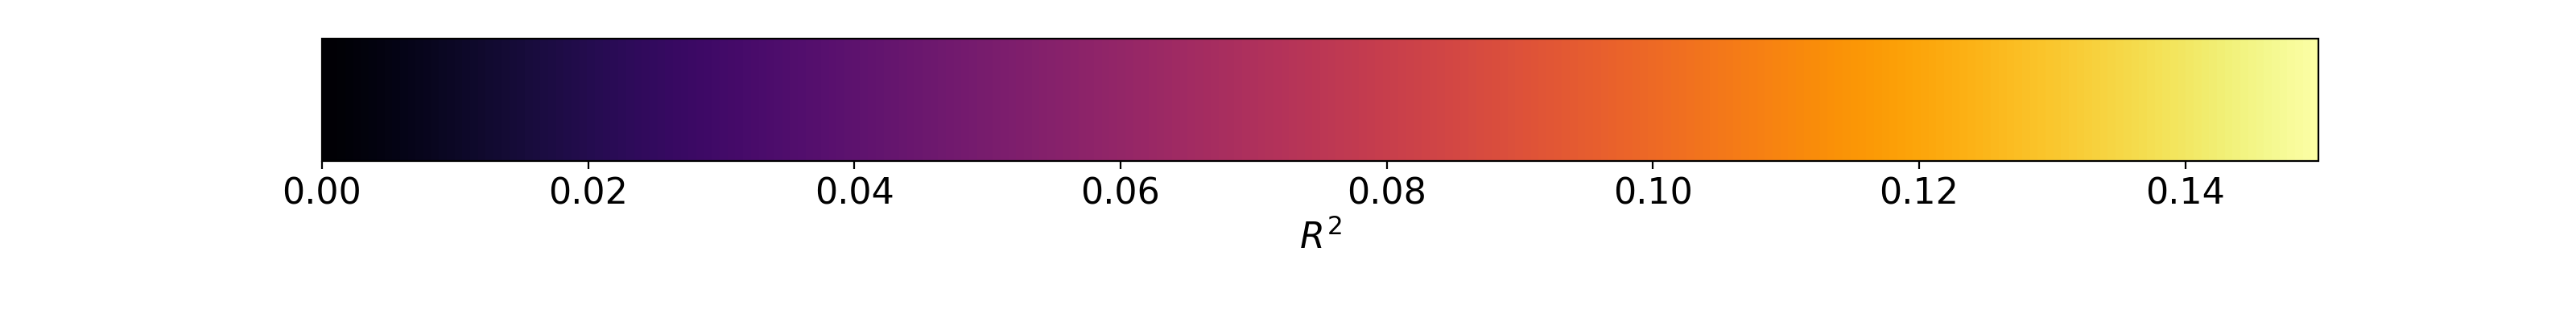

0.0
0.996078431372549


<IPython.core.display.Javascript object>


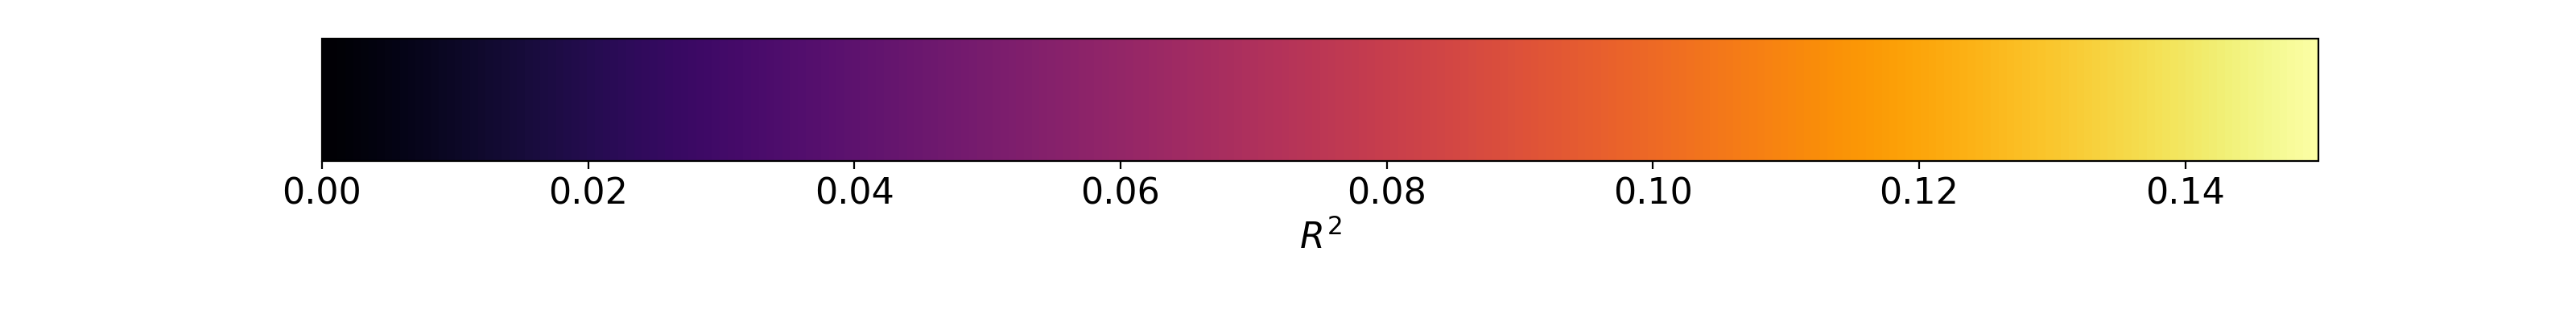

0.0
0.9921568627450981
Started server on port 32234
0.15294117647058825
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


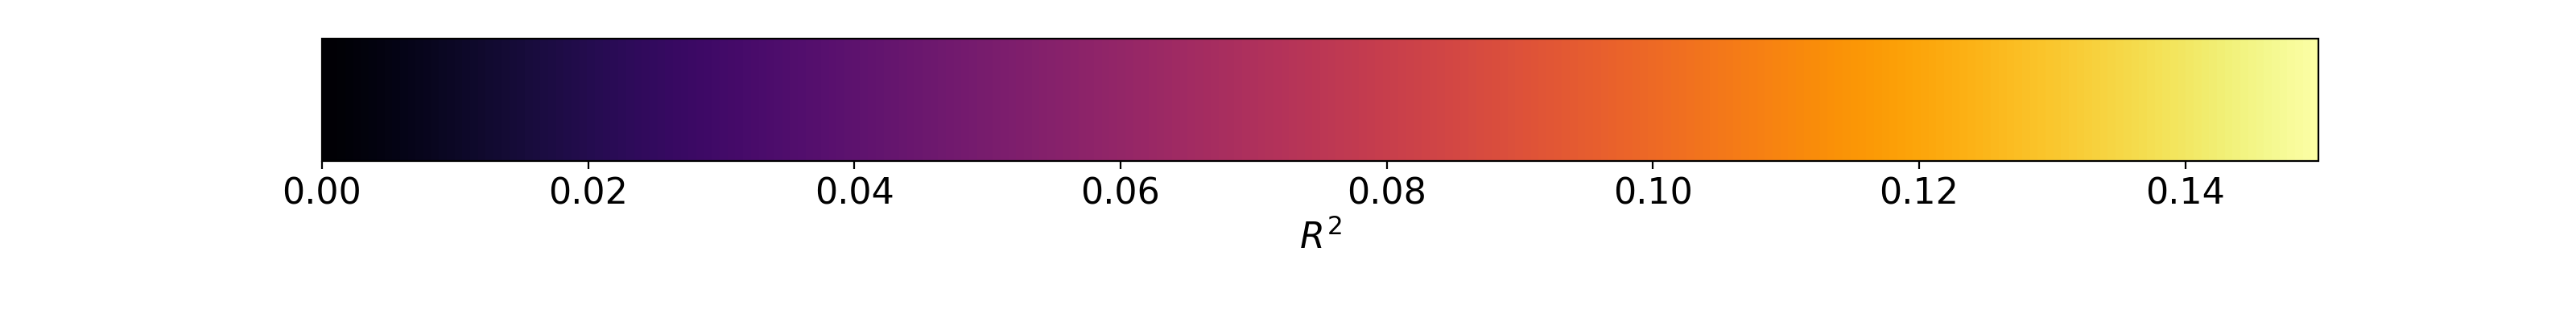

0.0
0.996078431372549


<IPython.core.display.Javascript object>


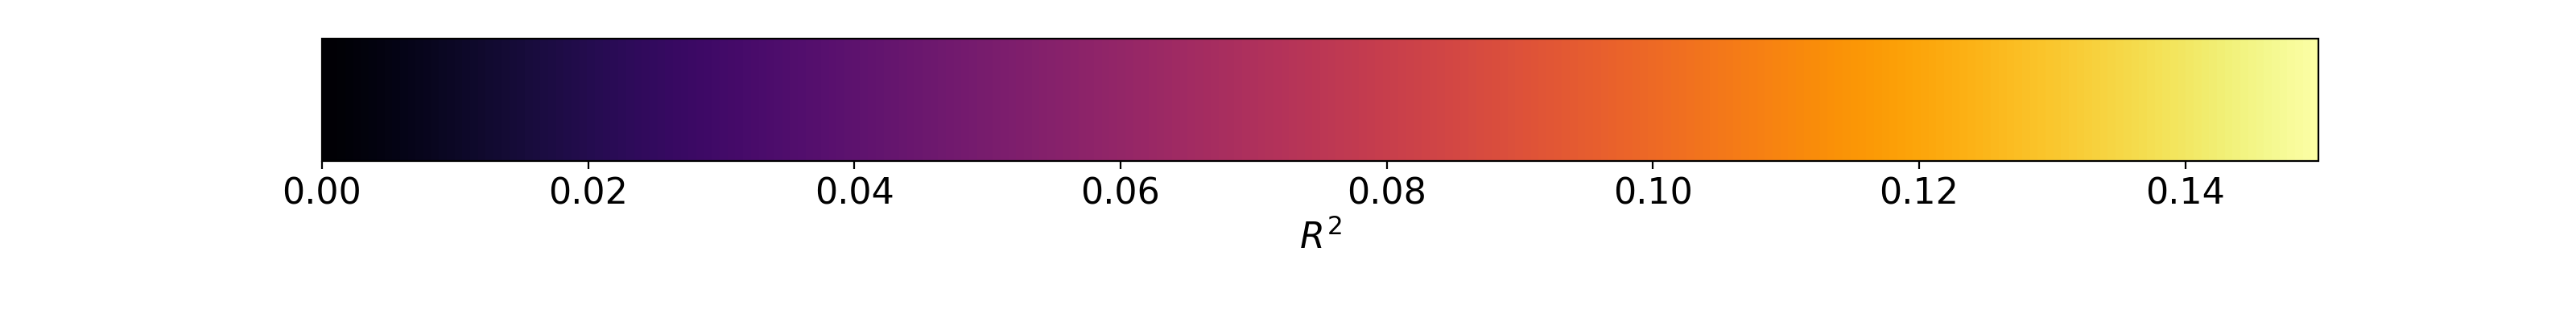

0.0
0.9921568627450981
Started server on port 33888
0.15294117647058825
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


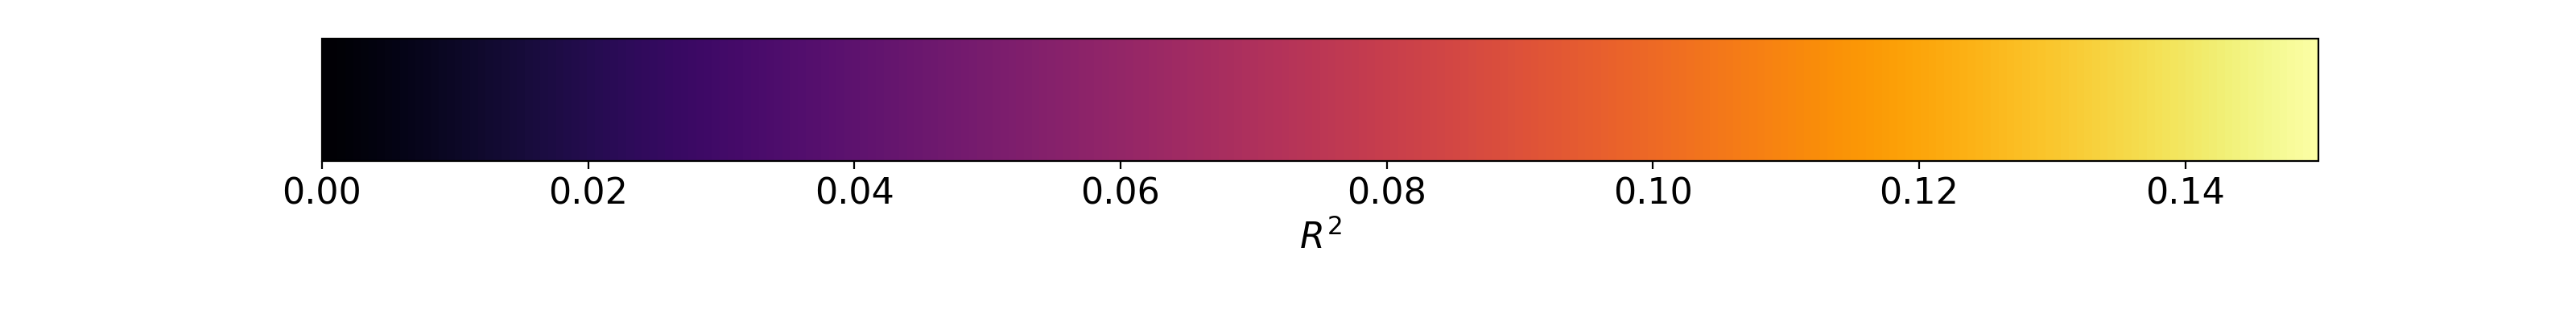

0.0
0.996078431372549


<IPython.core.display.Javascript object>


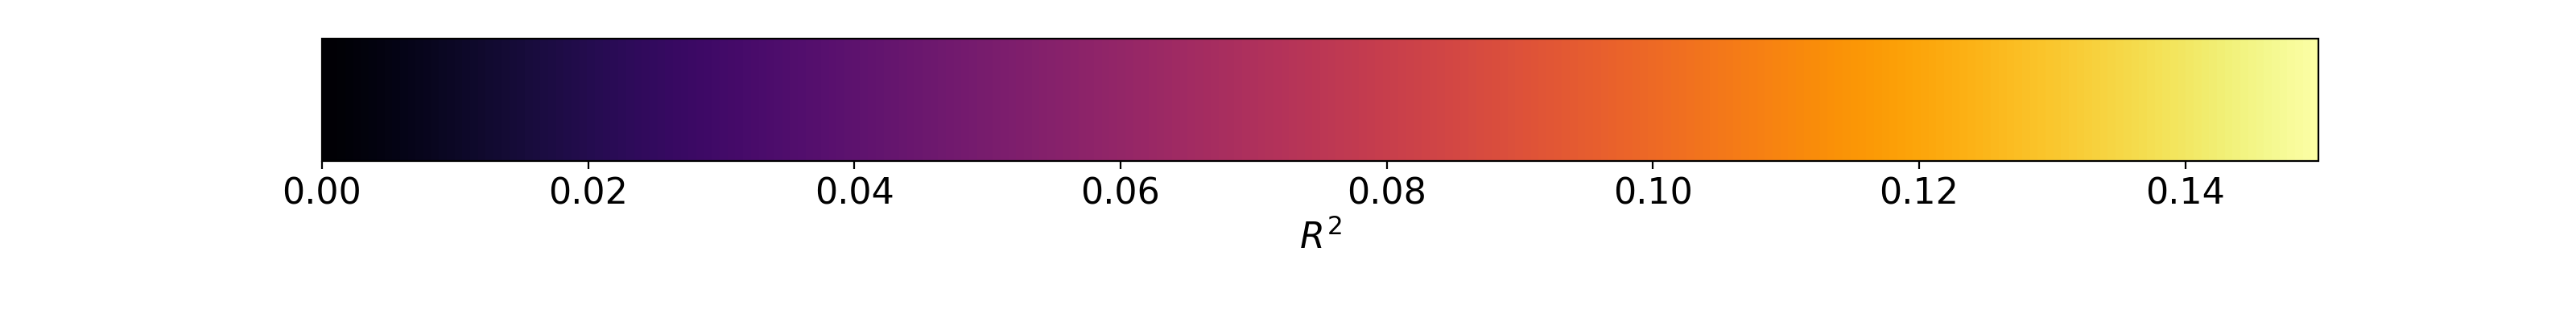

0.0
0.9921568627450981
Started server on port 37099
0.15294117647058825
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


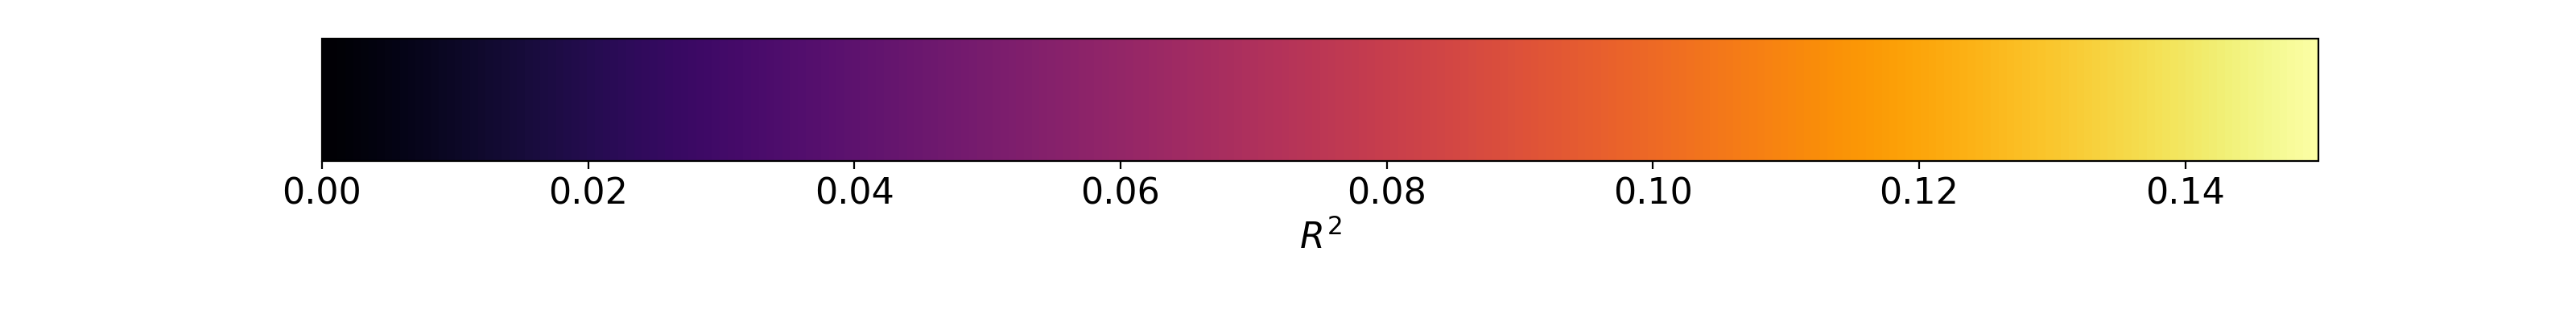

0.0
0.996078431372549


<IPython.core.display.Javascript object>


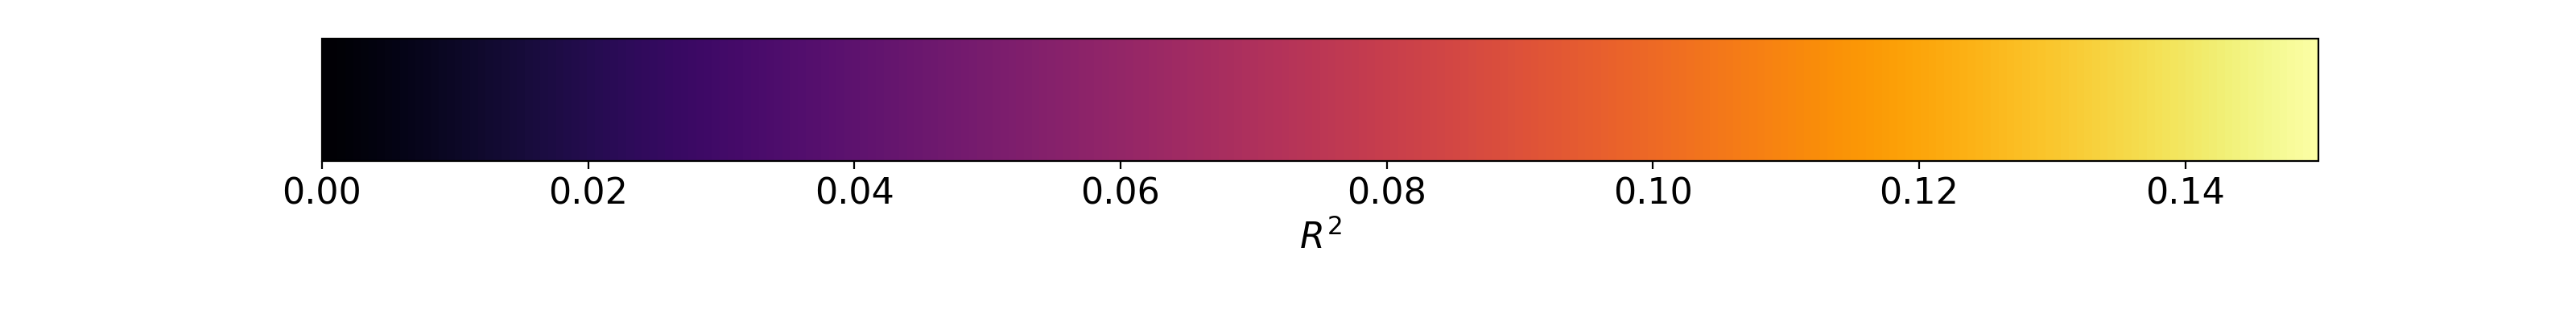

0.0
0.9921568627450981
Started server on port 36625
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


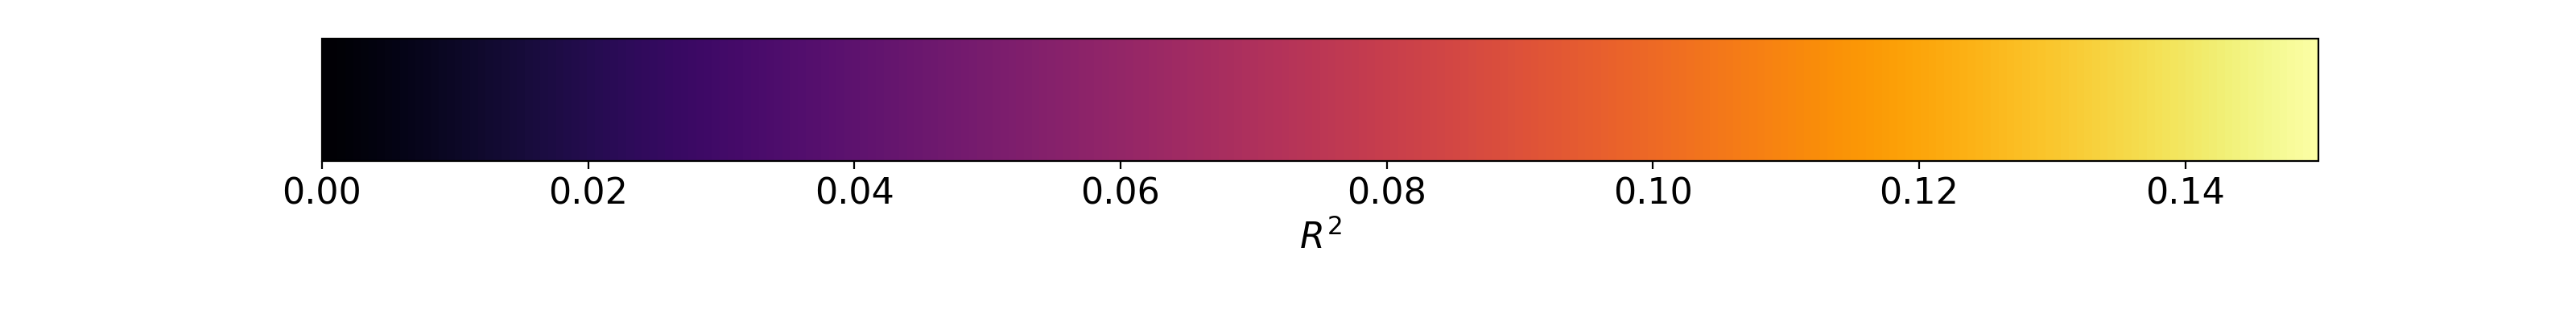

0.0
0.996078431372549


<IPython.core.display.Javascript object>


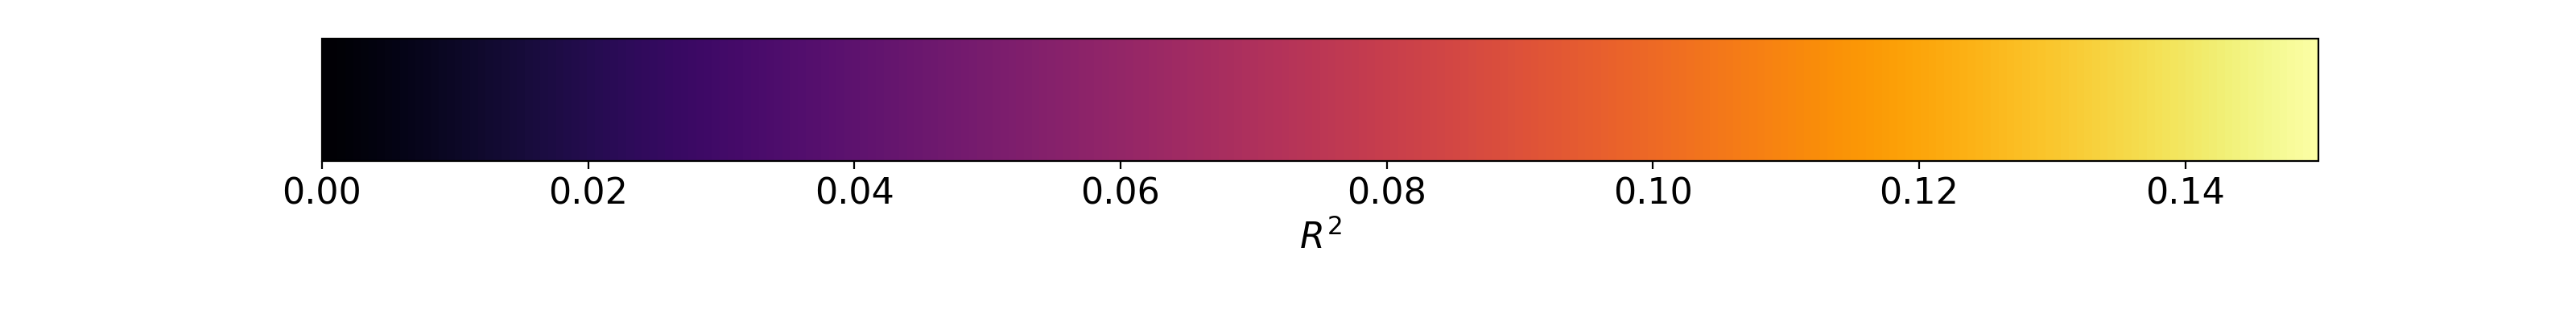

0.0
0.9921568627450981
Started server on port 43686
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


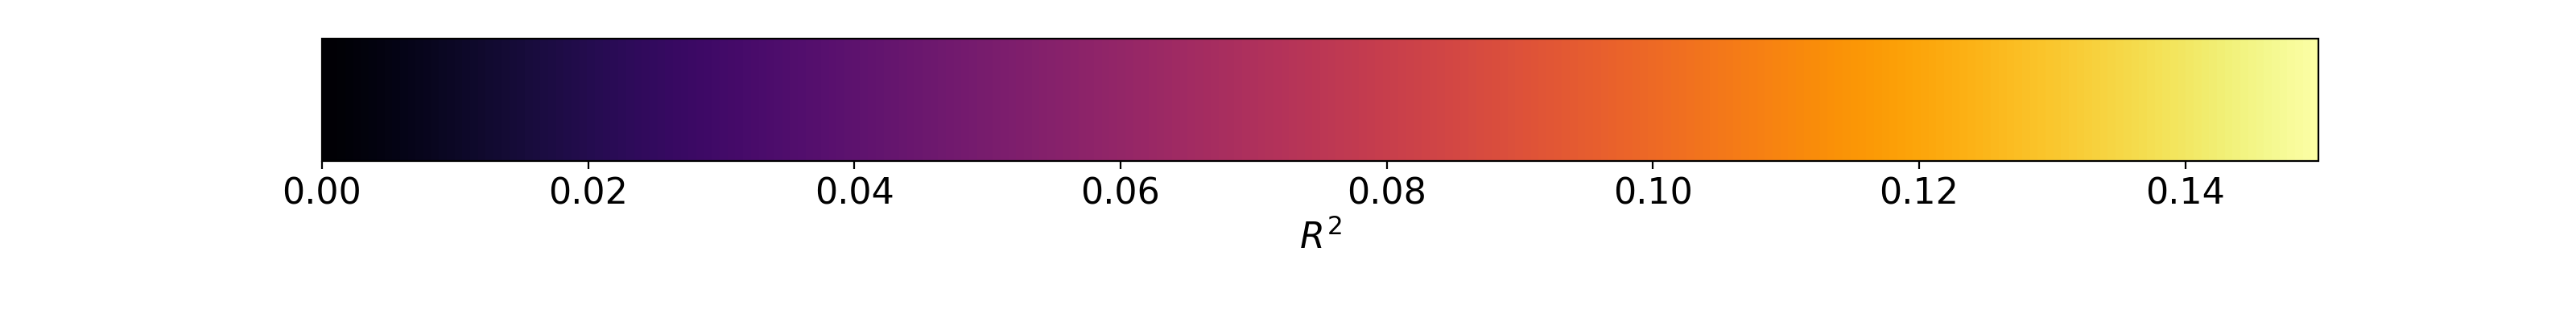

0.0
0.996078431372549


<IPython.core.display.Javascript object>


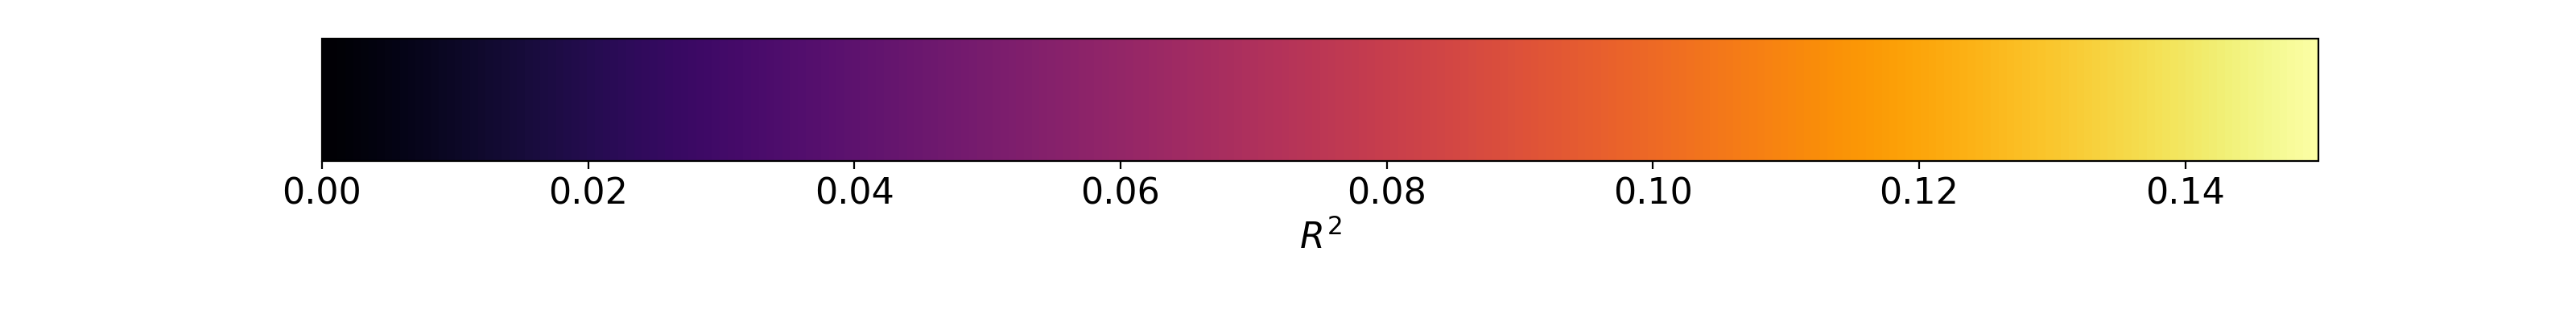

0.0
0.9921568627450981
Started server on port 32270
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


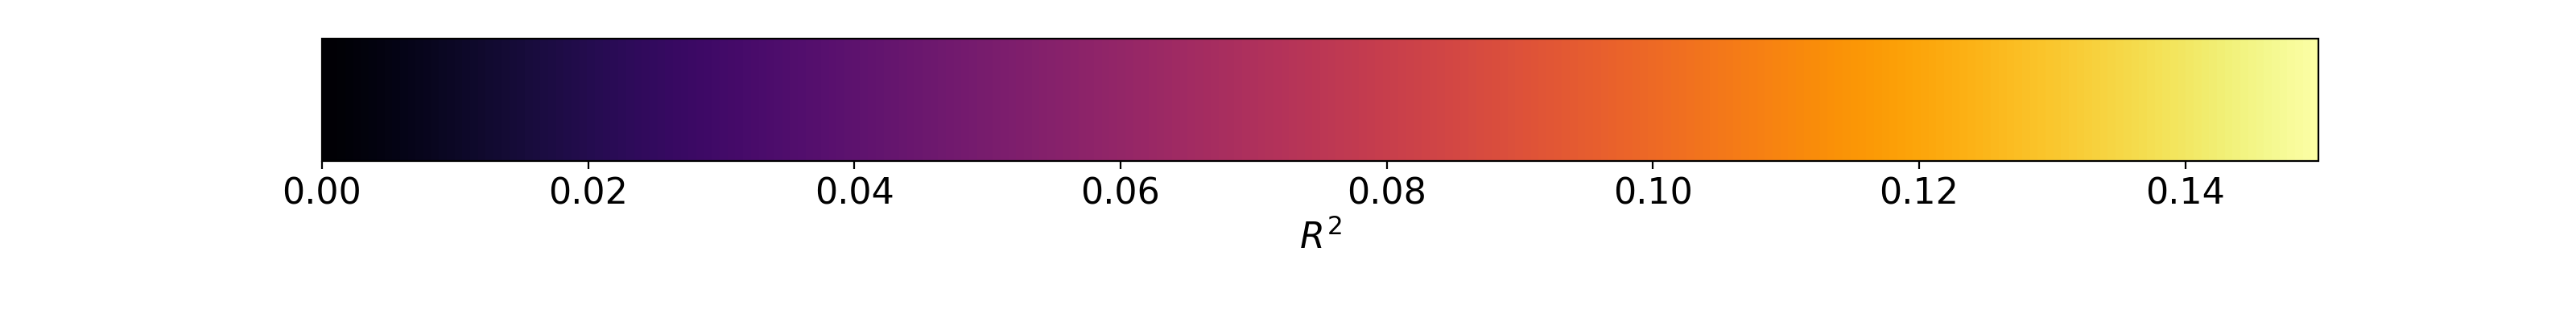

0.0
0.996078431372549


<IPython.core.display.Javascript object>


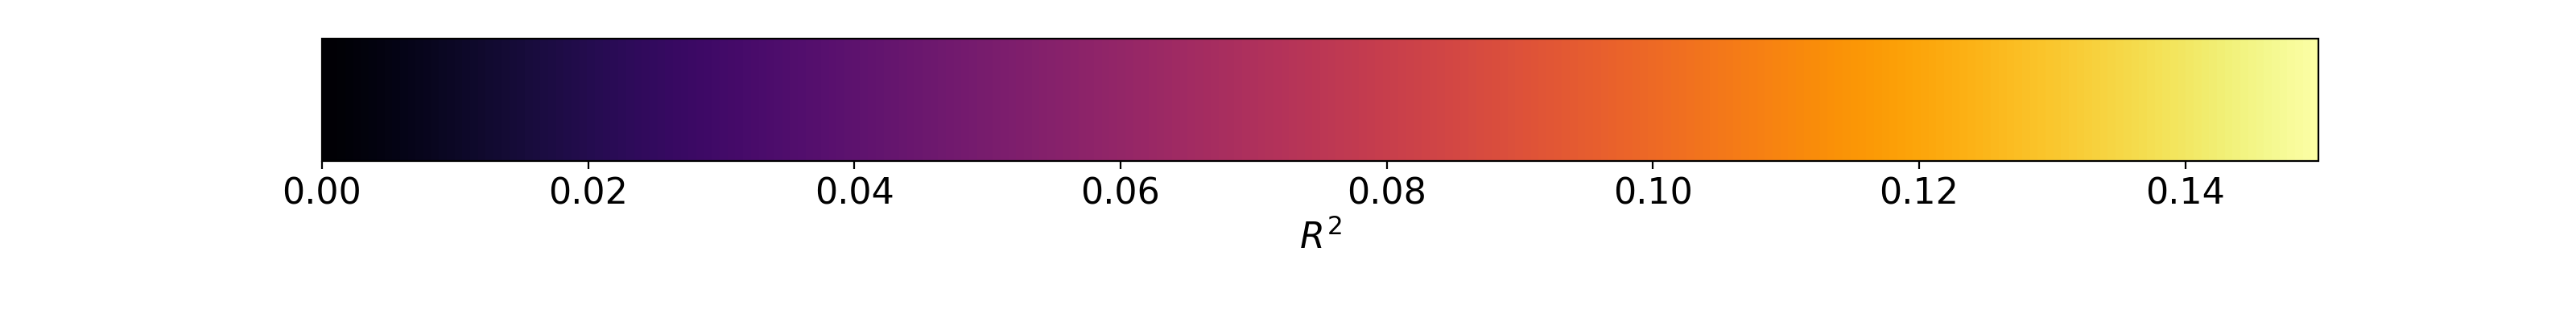

0.0
0.9921568627450981
Started server on port 8387
0.0
1.0
0.0
0.996078431372549


/Users/marcoaqil/prfpytools/prfpytools/postproc_utils.py:647: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = pl.subplots(figsize=(8, 1))


<IPython.core.display.Javascript object>


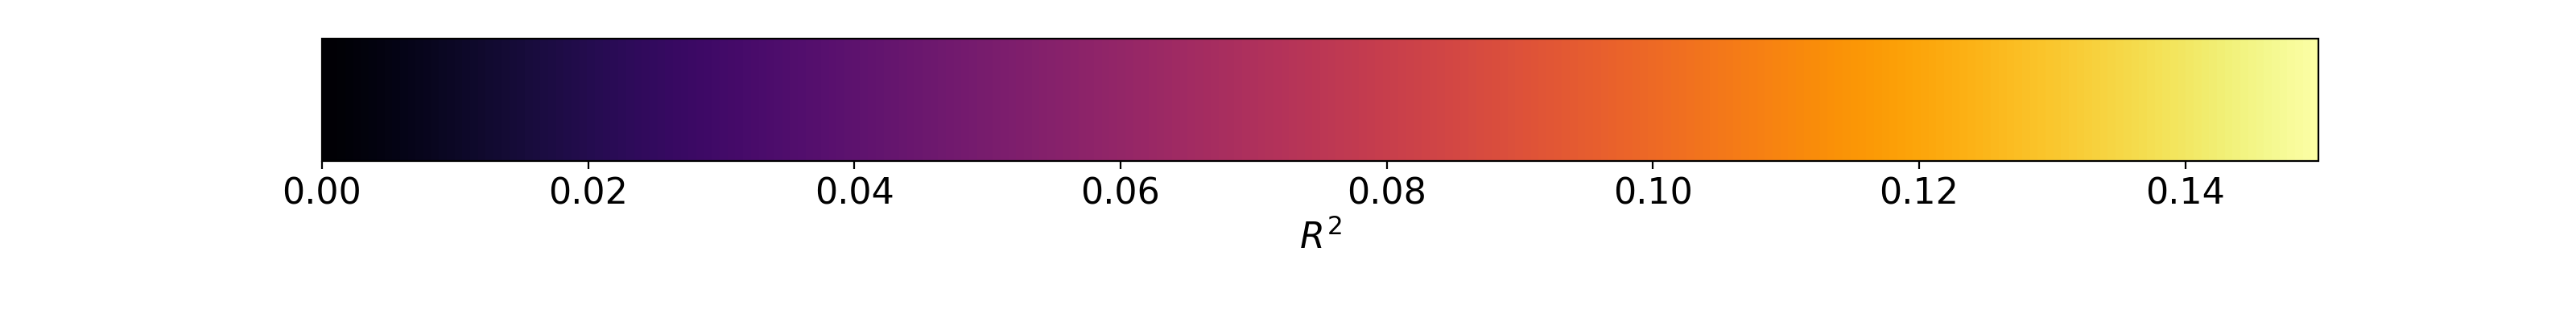

0.0
0.996078431372549


<IPython.core.display.Javascript object>


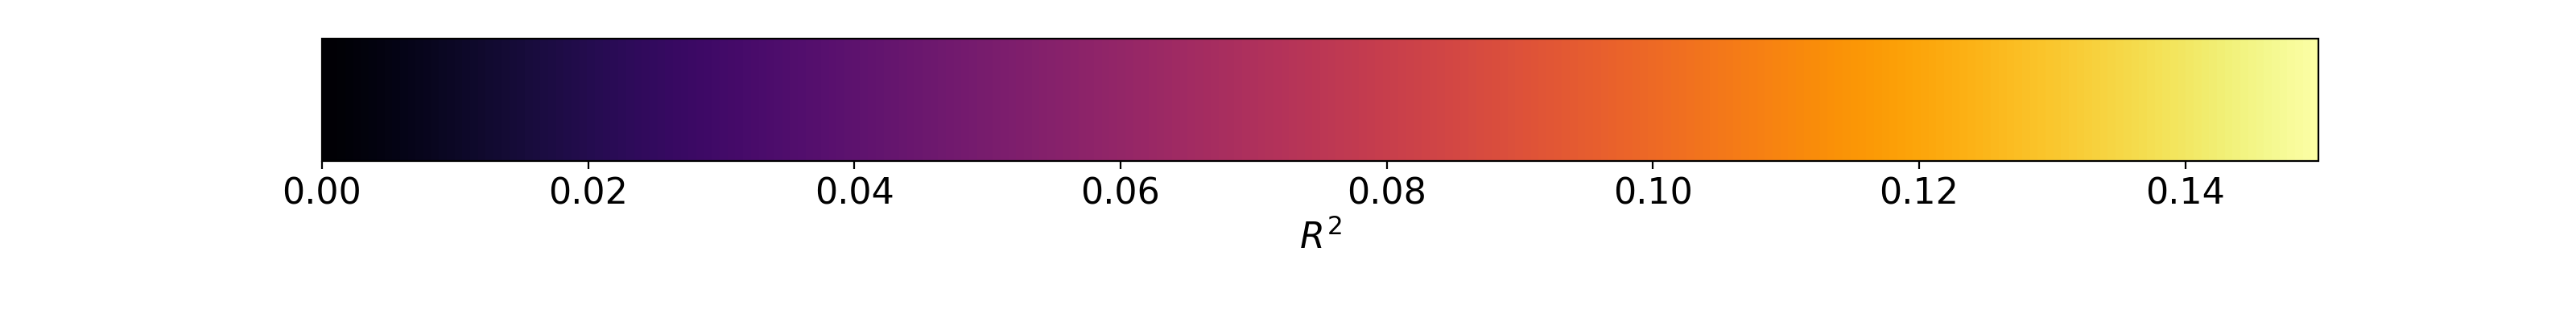

0.0
1.0
Started server on port 59939
0.0
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


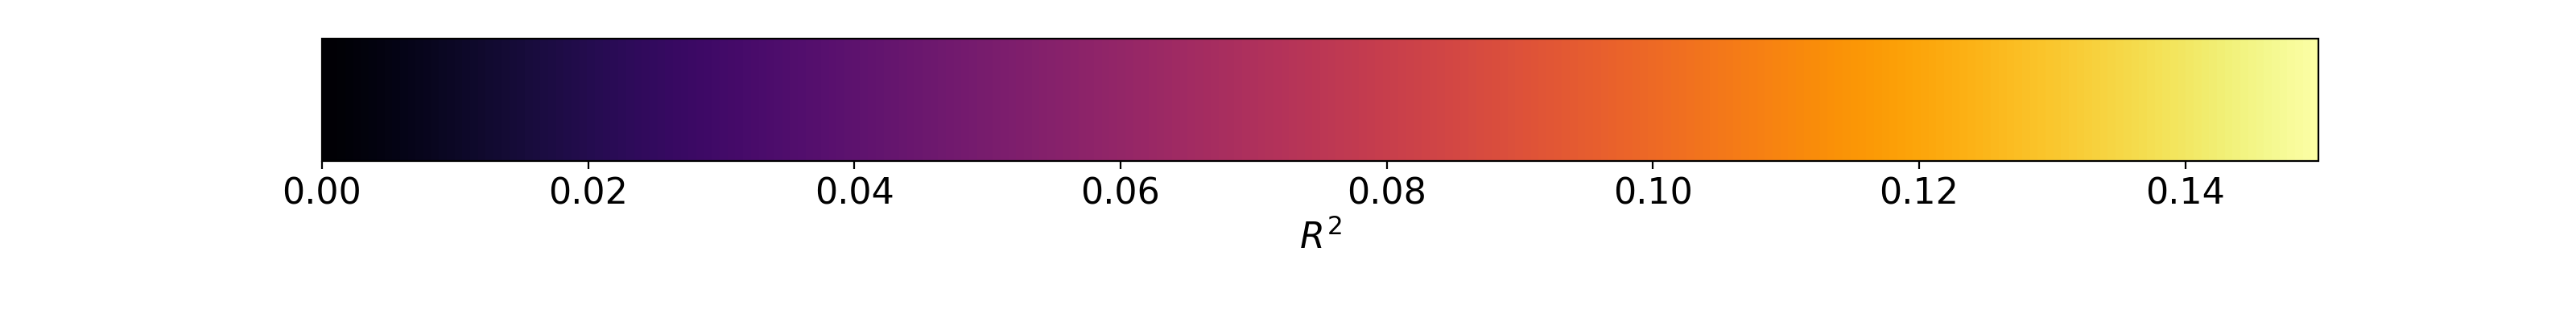

0.0
0.996078431372549


<IPython.core.display.Javascript object>


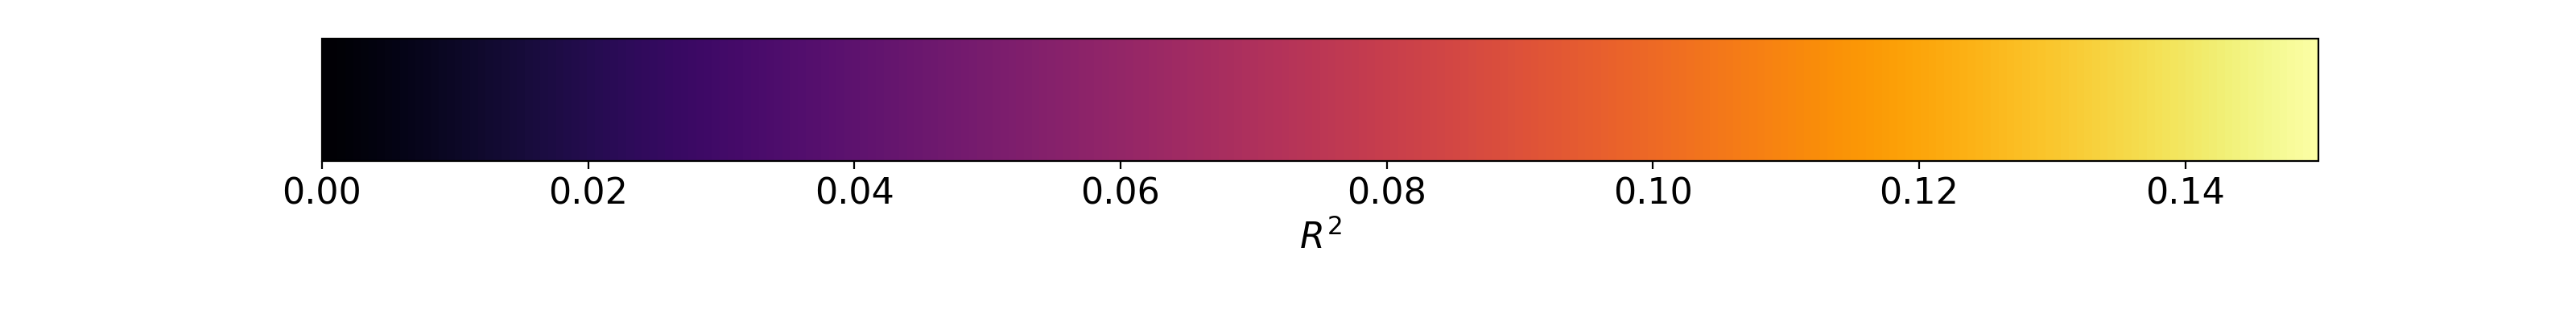

0.0
1.0
Started server on port 44068
0.15294117647058825
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


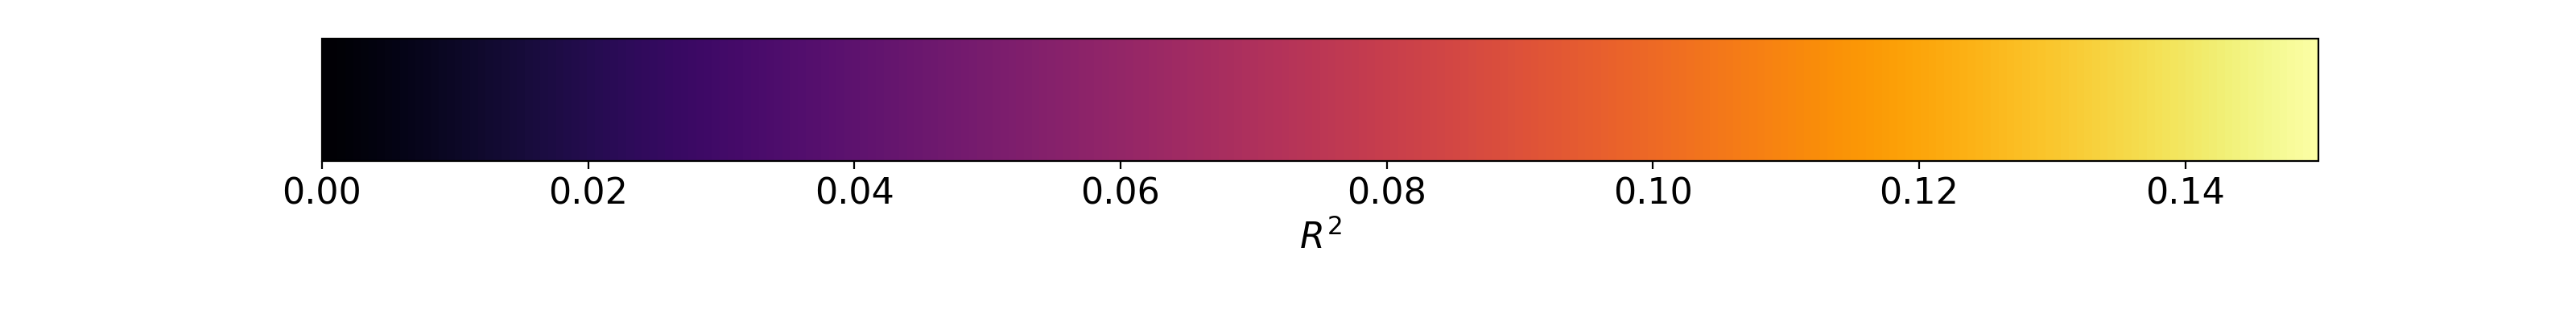

0.0
0.996078431372549


<IPython.core.display.Javascript object>


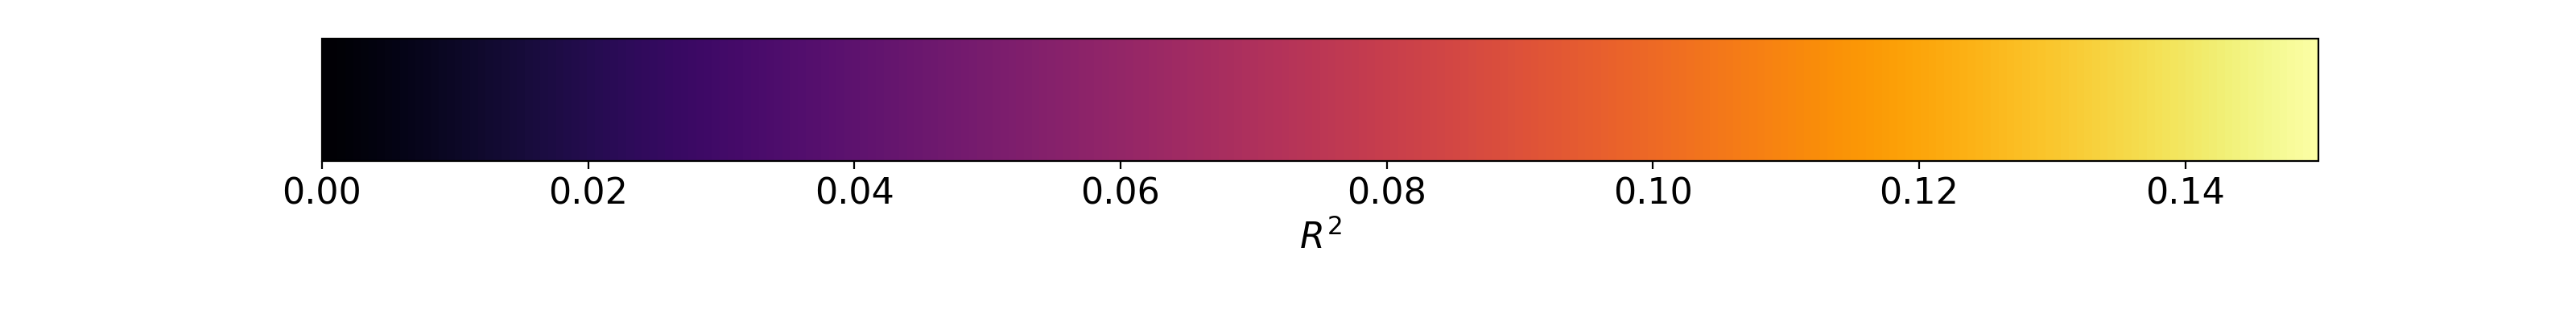

0.0
1.0
Started server on port 51405
0.0196078431372549
1.0
0.0
0.996078431372549


<IPython.core.display.Javascript object>


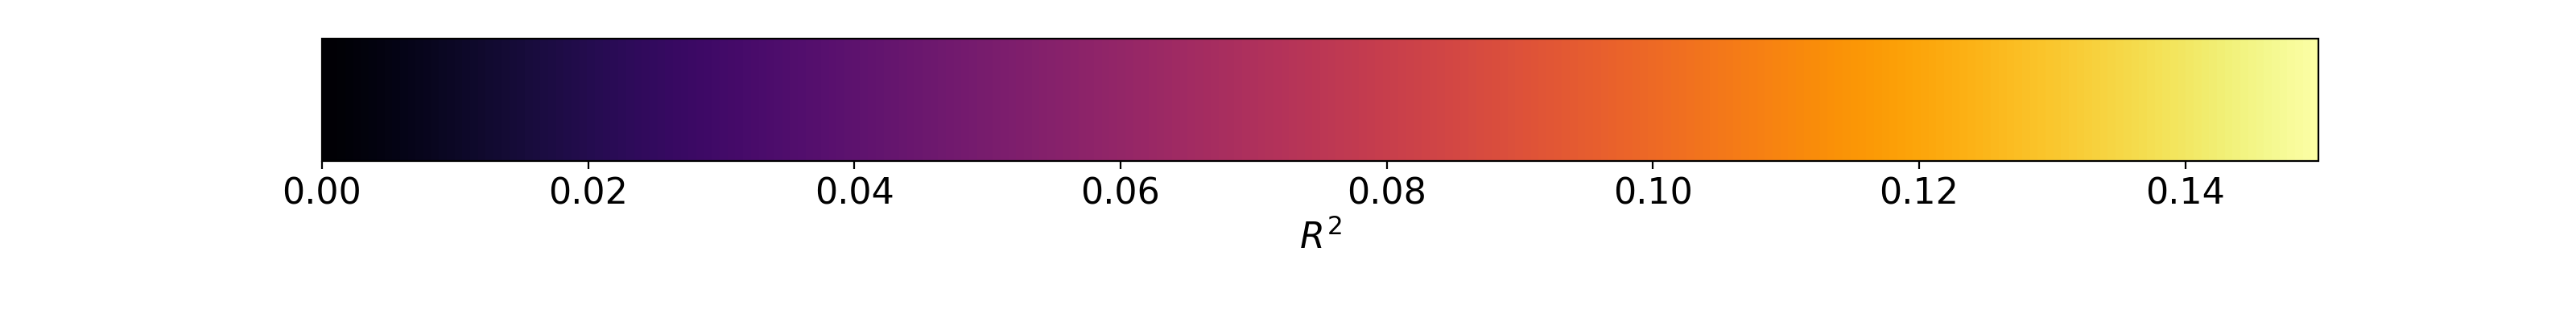

0.0
0.996078431372549


<IPython.core.display.Javascript object>


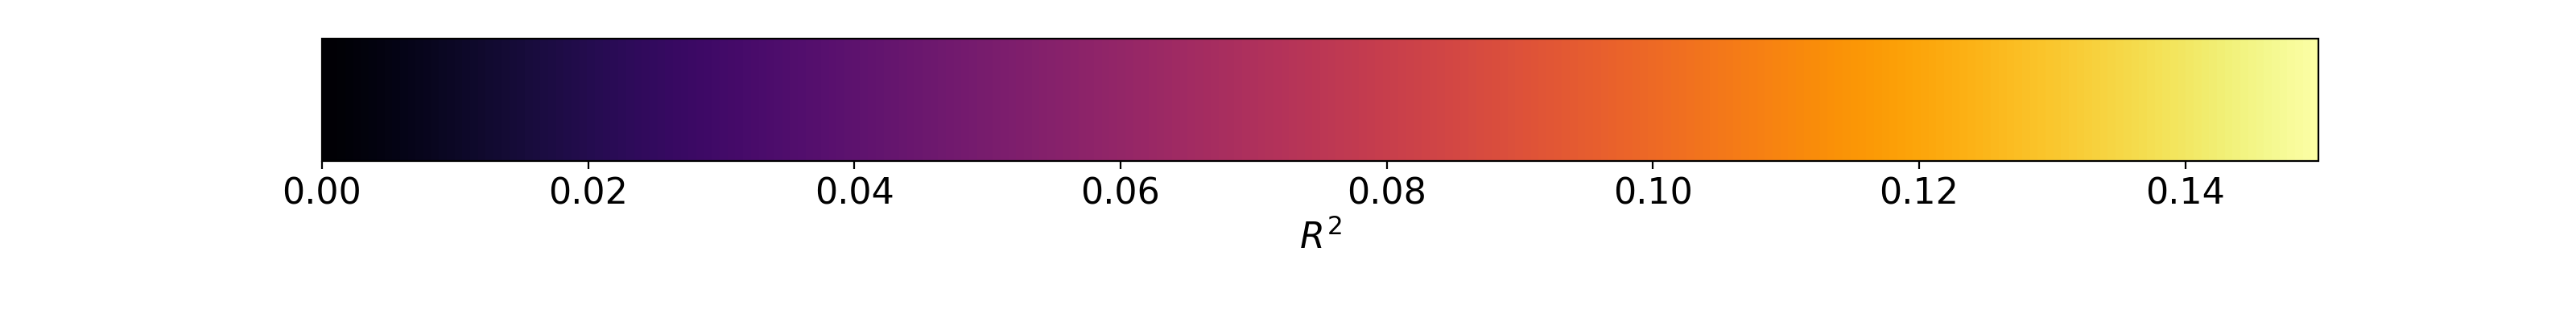

0.0
1.0
Started server on port 43000
-----


In [13]:
%matplotlib notebook
#visualize subject-specific ROIs and timeseries stats
#output FS-format polar angle and eccentricity maps for freeview ROI plotting
vis_res.output_freesurfer_maps = False
#compare t1w and surface fitting rsq and polar angle maps
vis_res.compare_volume_surface = False

vis_res.plot_rois_cortex = False
vis_res.plot_stats_cortex = False
vis_res.plot_rsq_cortex = True
vis_res.plot_ecc_cortex = False
vis_res.plot_polar_cortex = False
vis_res.plot_size_cortex = False
vis_res.plot_amp_cortex = False
vis_res.plot_css_exp_cortex = False
vis_res.plot_surround_size_cortex = False
vis_res.plot_suppression_index_cortex = False
vis_res.plot_norm_baselines_cortex = False
vis_res.plot_size_ratio_cortex = False
vis_res.plot_receptors_cortex = False
vis_res.plot_hrf_cortex = False
#set these to None if not wanted. 
vis_res.plot_correlations_per_roi = None#{'x_params_topl':['Norm Param. B'], 'y_params_topl':['Receptor Maps'],
                                    # 'x_params_lowl':['Norm_abcd'], 'y_params_lowl':['GABA'],
                                    # 'atlas':'glasser'} #glasser, HCPQ1Q6, custom
#note there is no quantile exclusion here, so the means may suffer from extreme values. just a visualization tool; use the quant_plots if want to be sure
vis_res.plot_means_per_roi = None#{'y_params_topl':['Norm Param. B','Norm Param. D','Size ratio (sigma_2/sigma_1)'], 
                                 #   'y_params_lowl':['Norm_abcd'], 
                                 #    'atlas':'glasser'} #glasser, HCPQ1Q6, custom
rsq_thresh = 0.1
rsq_max_opacity = 0.3#rsq_thresh+1e-6

#left, right = cortex.db.fsaverage.surfaces.inflated.get()
#points = np.concatenate((left[0],right[0]))
#left_flat, right_flat = cortex.db.fsaverage.surfaces.flat.get()
#points_flat = np.concatenate((left_flat[0],right_flat[0]))

#nodorsal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points_flat[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<50 and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-40]
#nofrontal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-40]
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
rois = 'Brain'#['custom.hV4']#'all'#['custom.hV4']#'['custom.hV4']#'all'#['custom.hV4']#'all'#['custom.V1', 'custom.V2', 'custom.V3']
space_names = 'fsnative'# 'fsnative'#'fsaverage'#'HCP'#
analysis_names = 'fit-task-2R_fit-runs-all'#'Mean analysis''fit-task-BAR_fit-runs-CVmedian'#'fit-task-2R_fit-runs-all'#'fit-task-4R_fit-runs-all'# #'Mean analysis'#
subject_ids = 'all'#['sub-001_ses-1']#,'sub-001_ses-2','sub-002_ses-1']#['fsaverage_cvrsq']#['fsaverage_hcp1sthalf','fsaverage_hcp2ndhalf']#['sub-006']##'all'#['sub-001']
excluded_rois = []#['excl_v123']

vis_res.set_alpha(space_names = [space_names], only_models=['Gauss','Norm_abcd'], ecc_min=0.0, ecc_max=15.0, threshold_li=False, excluded_rois=excluded_rois)
pycortex_image_path = '/Volumes/Crucial_X8/PRFMapping/Figures/pyc_surface_maps_new'

vis_res.pycortex_plots(rois, rsq_thresh, space_names, analysis_names, subject_ids, rsq_max_opacity = rsq_max_opacity, pycortex_cmap = 'RdBu_r',
                     # 'nipy_spectral',#'jet_r',                                        
                     #  roi_borders = 'glasser',
                       #specify this path to save colormap pDFs
                     #  pycortex_image_path = pycortex_image_path, save_colorbars=False,
                       timecourse_folder = '/Volumes/Crucial_X8/SM-pRF/derivatives/timecourses',#'/Volumes/Crucial_X8/PRFMapping/PRFMapping-Deriv-hires/prfpy/FS7_results/timecourses',#'/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/timecourses',##'
                       screenshot_paths = ['/Volumes/Crucial_X8/SM-pRF/derivatives/2R_Screenshots'])
                                        # ['/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETBAR_small.hdf5'])
                                         #  '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETBAR2_small.hdf5',
                                         #  '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETCW_small.hdf5',
                                         #  '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETCCW_small.hdf5',
                                          # '/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETEXP_small.hdf5',
                                           #'/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETCON_small.hdf5'])
                                            #'/Volumes/Crucial_X8/PRFMapping/PRFMapping-HCP/HCP_data/7T_RETBAR_small.hdf5'
                                            #'/Volumes/Crucial_X8/PRFMapping/PRFMapping-Deriv-hires/prfpy/FS7_results/timecourses/task-2R_screenshots'

In [7]:
vis_res.js_handle_dict[space_names][analysis_names][subject_ids[0]].keys()

dict_keys(['receptors'])

In [10]:
save_views=True
time.sleep(1)
if save_views:
    #capture pycortex views
    space = space_names
    analysis = analysis_names
    subj = subject_ids[0]
    if space == 'fsaverage':
        pyc_subj = 'fsaverage'
    else:
        pyc_subj = subj.split('_')[0]
        
    js_handle = 'receptors'
    #param_to_save = 'Norm_abcd Param. B'
    for param_to_save in vis_res.js_handle_dict[space][analysis][subj][js_handle].dataviews.attrs.keys():
        views_dict = {'occipital_inflated':{f'surface.{pyc_subj}.unfold':0.45, f'surface.{pyc_subj}.specularity':0,
                                            'camera.target':[-10,20,25],
                                             'camera.azimuth':191, 'camera.altitude':103, 'camera.radius':261,
                                             'camera.pivot':0}}

        vis_res.save_pycortex_views(space, analysis, subj, js_handle, param_to_save,
                                    views_dict, image_path = vis_res.pycortex_image_path)
        

<IPython.core.display.Javascript object>


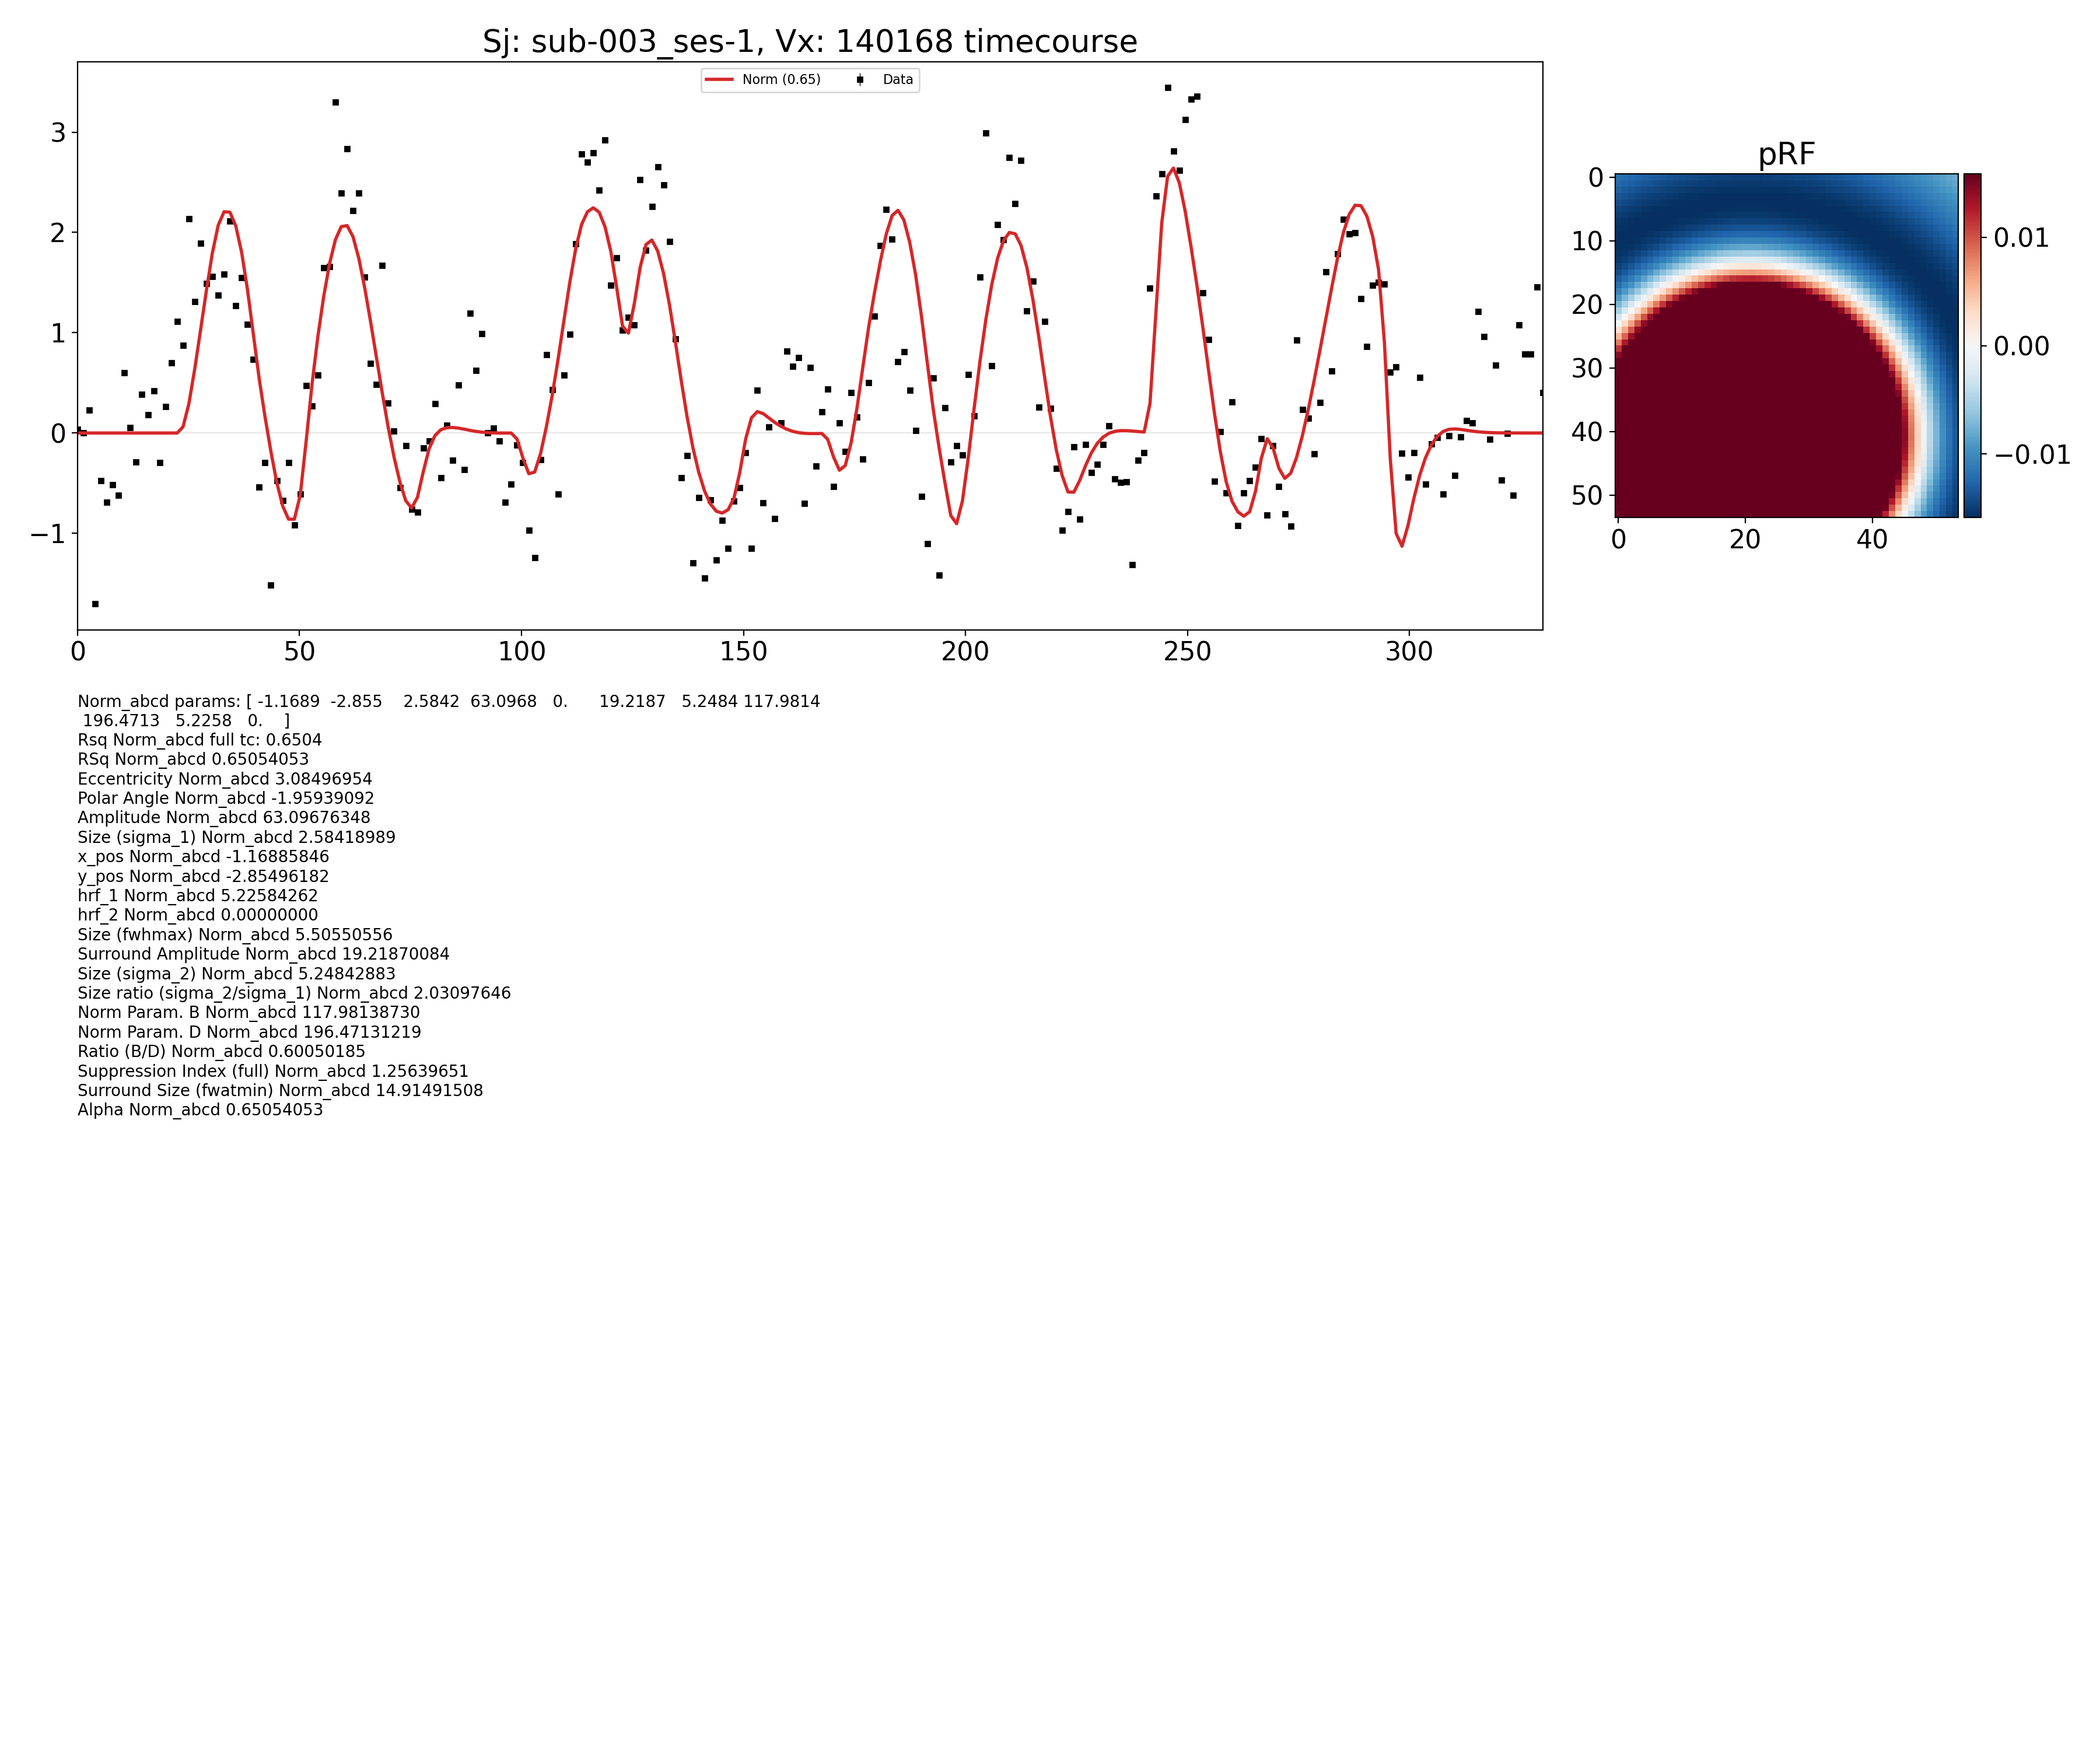

In [116]:
 vis_res.f #45227 43237

In [38]:
vis_res.f.savefig(f'/Users/marcoaqil/compr2.pdf', dpi=600, bbox_inches='tight', transparent=True)

# 1D quantitative plots

In [7]:
%%capture capt
pl.close('all')
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'#'A/C'
#D/B#D*sigma_2/sigma_1#(D*sigma_2)/(B*sigma_1)#'(AD-BC)/D**2 (deriv at 0)'#(Cs_2**2+D)/(As_1**2+B)
#(B*sigma_1)/(D*sigma_2)##B/D**2#'B/sqrt(D)'#'B(1/(Cpis_2**2+D)-1/D)'
####DoG
#'Surround volume (full)'#'Surround/Centre Amplitude' #'Surround-Centre Amplitude'#'Surround-Centre Volume'
#'Timecourse Neg/Pos Area Ratio'
#['GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#fsnative vox vol for correction: 4.8270. HCP 4.096. smPRF 5.832

#'custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.VO','custom.IPS'
#combined all_custom Brain
#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.IPS','all_custom']
left, right = cortex.db.fsaverage.surfaces.inflated.get()
points = np.concatenate((left[0],right[0]))
left_flat, right_flat = cortex.db.fsaverage.surfaces.flat.get()
points_flat = np.concatenate((left_flat[0],right_flat[0]))

#nodorsal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points_flat[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<40 and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-50]
#nofrontal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-40]

#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]#['V1','V2', 'V3','V3AB','hV4','LO','TO','VO','IPS'] #[roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
#[-20:]#['V1','V2', 'V3','V3AB','hV4','LO','TO','VO','IPS'] #fsaverage
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'LO1', 'LO2', 'TO1', 'TO2', 'V3A', 'V3B', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
# rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
# 'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
# 'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC','combined']
rois = ['V1','V2', 'V3','V3AB','hV4','LO','TO','VO','IPS']
#rois = ['all_custom']
#rois = ['HCPQ1Q6.V1', 'HCPQ1Q6.V2', 'HCPQ1Q6.V3', 'HCPQ1Q6.V3AB',
#        'HCPQ1Q6.LO', 'HCPQ1Q6.V7','HCPQ1Q6.TO',
#        'HCPQ1Q6.IPS1']
#rois.append('combined')

rsq_thresh = 0.3 #0.3
save_figures = True
figure_path = f"/Volumes/Crucial_X8/SM-pRF/Figures/nonordic_nopybest03thresh"

#set to 'all' to plot all analyses
space_names = 'fsnative'
analysis_names = 'fit-task-2R_fit-runs-all'#'Mean analysis'#'fit-task-BAR_fit-runs-all'#'all'#, -CVmedian
subject_ids = ['sub-001_ses-1','sub-001_ses-2','sub-002_ses-1']#['fsaverage_cvrsq']#[sj for sj in vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-all'].keys() if 'fsaverage' not in sj]#['fsaverage_cvrsq']#['fsaverage']#['sub-001','sub-002','sub-006']#
excluded_rois = ['excl_v123']

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=5.0, threshold_li=False, excluded_rois=excluded_rois)

ylim={}
xlim={}

#set model/roi specific x-y limitd

#ylim = {'Mean':(1.5,14), 'Norm_abcd':(1.5,14), 'Gauss':(1.5,14), 'CSS':(1.5,14), 'DoG':(1.5,14)}
#xlim = {'Gauss':(0,4.5), 'DoG':(0,4.5), 'CSS':(0,4.5), 'Norm_abcd':(0,4.5)}
#dog rsq
#ylim = {'Norm_abcd':(-5,310)}
#xlim = {'Norm_abcd':(-0.005,0.155)}
#dog tcsi
#xlim = {'Norm_abcd':(-0.02,1.33)}
#for r in rois:
    #xlim[r] = xlim['Norm_abcd']
    #ylim[r] = ylim['Norm_abcd']
    #size ratio
#xlim = {'Norm_abcd':(-0.02,0.8)}
#ylim = {'Norm_abcd':(2,11)}

#         if r in ['custom.V1', 'custom.V2', 'custom.V3']:
#             ylim[r] = (1.5,14)
#         elif r in ['custom.V3AB', 'custom.hV4', 'custom.LO']:
#             ylim[r] = (1.5,14)
#         else:
#             ylim[r] = (1.5,14)

for x_parameter in ['Eccentricity']:#'PCA Component 0','PCA Component 1','PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
    for y_parameter in ['Norm Param. B','Norm Param. D','Ratio (B/D)', 'Size ratio (sigma_2/sigma_1)','Amplitude','Surround Amplitude','Size (sigma_1)','Size (sigma_2)','hrf_1']:
        
       # ylim = {'Norm_abcd':(-5,135)}
#         if x_parameter == 'GABA_A':
#             xlim = {'Norm_abcd':(720,1080)}
#         elif x_parameter == '5-HT1A':
#             xlim = {'Norm_abcd':(7,43)}
#         elif x_parameter == '5-HT1B':
#             xlim = {'Norm_abcd':(13,32)}
#         elif x_parameter == '5-HT2A':
#             xlim = {'Norm_abcd':(39,66)}    

        #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
        vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
                                        space_names, analysis_names, subject_ids,
                                       # x_parameter_toplevel='Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
                                        diff_gauss=False, diff_gauss_x=False, 
                                        log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
                                        scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
                                        xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
                                         means_only=True, 
                                        rois_on_plot = False, rsq_alpha_plot = True,
                                        fit = False, exp_fit = False, show_legend = False, 
                                        each_subj_on_group=True, bold_voxel_volume=5.832,
                                        quantile_exclusion=0.999)#, x_param_model='DoG')

# for x_parameter in ['PCA Component 0','PCA Component 1','PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#     for y_parameter in ['Amplitude','Surround Amplitude', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Polar Angle', 'Size (sigma_1)', 'Size (sigma_2)','Size ratio (sigma_2/sigma_1)']:#'Norm Param. D']:#@

# for x_parameter in ['Eccentricity']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#     for y_parameter in ['Norm Param. D']:#'Norm Param. D']:#@
#        # ylim = {'Norm_abcd':(23,72)}#{'Norm_abcd':(5,44)}
# #         if x_parameter == '5-HT1B':
# #             xlim = {'Norm_abcd':(13,32)}
# #         else:
# #             xlim = {'Norm_abcd':(39,66)}    
            
#         #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
#         vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
#                                         space_names, analysis_names, subject_ids,
#                                         x_parameter_toplevel=None,#'Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
#                                         diff_gauss=False, diff_gauss_x=False, 
#                                         log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
#                                         scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
#                                         xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
#                                          means_only=True, 
#                                         rois_on_plot = True, rsq_alpha_plot = True,
#                                         fit = False, exp_fit = False, show_legend = False, 
#                                         each_subj_on_group=True, bold_voxel_volume=4.096,
#                                         quantile_exclusion=0.999)#, x_param_model='DoG')
        
# for x_parameter in ['PCA Component 0', 'PCA Component 1', 'PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#     for y_parameter in ['Amplitude','Surround Amplitude', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Polar Angle', 'Size (sigma_1)', 'Size (sigma_2)','Size ratio (sigma_2/sigma_1)']:#'Norm Param. D']:#@
# #         ylim = {'Norm_abcd':(25,75)}#{'Norm_abcd':(5,44)}
# #         if x_parameter == '5-HT1B':
# #             xlim = {'Norm_abcd':(13,32)}
# #         else:
# #             xlim = {'Norm_abcd':(39,66)}    
            
#         #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
#         vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
#                                         space_names, analysis_names, subject_ids,
#                                         x_parameter_toplevel='Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
#                                         diff_gauss=False, diff_gauss_x=False, 
#                                         log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
#                                         scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
#                                         xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
#                                          means_only=False, 
#                                         rois_on_plot = True, rsq_alpha_plot = True,
#                                         fit = False, exp_fit = False, show_legend = False, 
#                                         each_subj_on_group=True, bold_voxel_volume=4.096,
#                                         quantile_exclusion=0.999)#, x_param_model='DoG')

os.system(f"open {sound_file}")


In [13]:
vis_res.main_dict['fsaverage']['fit-task-2R_fit-runs-all']['fsaverage']['Processed Results']['Receptor Maps'].keys()

dict_keys([])

In [16]:
%%capture capt
pl.close('all')
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'#'A/C'
#D/B#D*sigma_2/sigma_1#(D*sigma_2)/(B*sigma_1)#'(AD-BC)/D**2 (deriv at 0)'#(Cs_2**2+D)/(As_1**2+B)
#(B*sigma_1)/(D*sigma_2)##B/D**2#'B/sqrt(D)'#'B(1/(Cpis_2**2+D)-1/D)'
####DoG
#'Surround volume (full)'#'Surround/Centre Amplitude' #'Surround-Centre Amplitude'#'Surround-Centre Volume'
#'Timecourse Neg/Pos Area Ratio'
#['GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#fsnative vox vol for correction: 4.8270. HCP 4.096

#'custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.VO','custom.IPS'
#combined all_custom Brain
#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.IPS','all_custom']
left, right = cortex.db.fsaverage.surfaces.inflated.get()
points = np.concatenate((left[0],right[0]))
left_flat, right_flat = cortex.db.fsaverage.surfaces.flat.get()
points_flat = np.concatenate((left_flat[0],right_flat[0]))

#nodorsal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points_flat[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<40 and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-50]
#nofrontal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-40]

rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
#[-20:]#['V1','V2', 'V3','V3AB','hV4','LO','TO','VO','IPS'] #fsaverage
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'LO1', 'LO2', 'TO1', 'TO2', 'V3A', 'V3B', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
# rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
# 'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
# 'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC','combined']
#rois = ['V1','V2', 'V3','V3AB','hV4','LO','TO','VO','IPS','combined']
#rois = ['all_custom']
#rois = ['HCPQ1Q6.V1', 'HCPQ1Q6.V2', 'HCPQ1Q6.V3', 'HCPQ1Q6.V3AB',
#        'HCPQ1Q6.LO', 'HCPQ1Q6.V7','HCPQ1Q6.TO',
#        'HCPQ1Q6.IPS1']
#rois.append('combined')

rsq_thresh = 0.1 #0.3
save_figures = True
figure_path = f"/Volumes/Crucial_X8/PRFMapping/Figures/spinoza_res_010_thresh_ecc45_xpermstats_noresamp_1e6perm"

#set to 'all' to plot all analyses
space_names = 'fsaverage'
analysis_names = 'fit-task-2R_fit-runs-all'#'fit-task-BAR_fit-runs-all'#'Mean analysis'#'fit-task-BAR_fit-runs-all'#'all'#, -CVmedian
subject_ids = ['fsaverage']#['fsaverage']#['sub-001','sub-002','sub-006']#
excluded_rois = ['excl_v123']

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=4.5, threshold_li=False, excluded_rois=[])

ylim={}
xlim={}

#set model/roi specific x-y limitd

#ylim = {'Mean':(1.5,14), 'Norm_abcd':(1.5,14), 'Gauss':(1.5,14), 'CSS':(1.5,14), 'DoG':(1.5,14)}
#xlim = {'Gauss':(0,4.5), 'DoG':(0,4.5), 'CSS':(0,4.5), 'Norm_abcd':(0,4.5)}
#dog rsq
#ylim = {'Norm_abcd':(-5,310)}
#xlim = {'Norm_abcd':(-0.005,0.155)}
#dog tcsi
#xlim = {'Norm_abcd':(-0.02,1.33)}
#for r in rois:
    #xlim[r] = xlim['Norm_abcd']
    #ylim[r] = ylim['Norm_abcd']
    #size ratio
#xlim = {'Norm_abcd':(-0.02,0.8)}
#ylim = {'Norm_abcd':(2,11)}

#         if r in ['custom.V1', 'custom.V2', 'custom.V3']:
#             ylim[r] = (1.5,14)
#         elif r in ['custom.V3AB', 'custom.hV4', 'custom.LO']:
#             ylim[r] = (1.5,14)
#         else:
#             ylim[r] = (1.5,14)

for x_parameter in ['GABA_A', '5-HT1A']:#'PCA Component 0','PCA Component 1','PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
    for y_parameter in ['Norm Param. B']:
        
        #ylim = {'Norm_abcd':(-5,135)}
#         if x_parameter == 'GABA_A':
#             xlim = {'Norm_abcd':(720,1080)}
#         else:
#             xlim = {'Norm_abcd':(7,43)}
               
        #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
        vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
                                        space_names, analysis_names, subject_ids,
                                        x_parameter_toplevel='Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
                                        diff_gauss=False, diff_gauss_x=False, 
                                        log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
                                        scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
                                        xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
                                         means_only=False, 
                                        rois_on_plot = True, rsq_alpha_plot = True,
                                        fit = False, exp_fit = False, show_legend = False, 
                                        each_subj_on_group=True, bold_voxel_volume=4.8270,
                                        quantile_exclusion=0.999)#, x_param_model='DoG')

# for x_parameter in ['PCA Component 0','PCA Component 1','PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#     for y_parameter in ['Amplitude','Surround Amplitude', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Polar Angle', 'Size (sigma_1)', 'Size (sigma_2)','Size ratio (sigma_2/sigma_1)']:#'Norm Param. D']:#@

for x_parameter in ['5-HT1B', '5-HT2A']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
    for y_parameter in ['Norm Param. D']:#'Norm Param. D']:#@
        #ylim = {'Norm_abcd':(23,72)}#{'Norm_abcd':(5,44)}
#         if x_parameter == '5-HT1B':
#             xlim = {'Norm_abcd':(13,32)}
#         else:
#             xlim = {'Norm_abcd':(39,66)}    
            
        #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
        vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
                                        space_names, analysis_names, subject_ids,
                                        x_parameter_toplevel='Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
                                        diff_gauss=False, diff_gauss_x=False, 
                                        log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
                                        scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
                                        xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
                                         means_only=False, 
                                        rois_on_plot = True, rsq_alpha_plot = True,
                                        fit = False, exp_fit = False, show_legend = False, 
                                        each_subj_on_group=True, bold_voxel_volume=4.8270,
                                        quantile_exclusion=0.999)#, x_param_model='DoG')
        
# for x_parameter in ['PCA Component 0', 'PCA Component 1', 'PCA Component 2']:#'GABA_A','5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', '5-HT4']
#     for y_parameter in ['Amplitude','Surround Amplitude', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Polar Angle', 'Size (sigma_1)', 'Size (sigma_2)','Size ratio (sigma_2/sigma_1)']:#'Norm Param. D']:#@
# #         ylim = {'Norm_abcd':(25,75)}#{'Norm_abcd':(5,44)}
# #         if x_parameter == '5-HT1B':
# #             xlim = {'Norm_abcd':(13,32)}
# #         else:
# #             xlim = {'Norm_abcd':(39,66)}    
            
#         #bin_by: 'size' (x-param bins have the same number of vertices) or 'space' (x-param bins are approx equally spaced) space is useful for clustered parameters)
#         vis_res.quant_plots(x_parameter, y_parameter, rois, rsq_thresh, save_figures, figure_path,
#                                         space_names, analysis_names, subject_ids,
#                                         x_parameter_toplevel='Receptor Maps',  #y_parameter_toplevel='Receptor Maps',                                      
#                                         diff_gauss=False, diff_gauss_x=False, 
#                                         log_yaxis=False, log_xaxis = False, nr_bins = 1, bin_by='size', rsq_weights=True,
#                                         scatter=False, violin=False, stats_on_plot=False, zconfint_err_alpha=None,
#                                         xlim=xlim, ylim=ylim, zscore_xdata=False, zscore_ydata=False, 
#                                          means_only=False, 
#                                         rois_on_plot = True, rsq_alpha_plot = True,
#                                         fit = False, exp_fit = False, show_legend = False, 
#                                         each_subj_on_group=True, bold_voxel_volume=4.096,
#                                         quantile_exclusion=0.999)#, x_param_model='DoG')

os.system(f"open {sound_file}")


# Multidimensional analyses

## OLS

fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
thresholding at 27.290789658414187 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq_2ndhalf
thresholding at 13.847806913306545 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq_1sthalf
thresholding at 13.11686366363076 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
Make sure bold_voxel_volume is specified in mm^3
Upsampling correction factor: [2.1213]
fit-task-BAR_fit-runs-all fsaverage_cvrsq glasser_1
X-dims: ['5-HT1B', '5-HT2A']
Y-dims: ['C/(A+B) Norm_abcd']
alldims ['5-HT1B', '5-HT2A', 'C/(A+B) Norm_abcd']
ord dims ['5-HT1A', '5-HT1B', '5-HT2A', '5-HTT', 'C/(A+B) Norm_abcd', 'C/D Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'RSq Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd']
Sample size: 0
fit-task-BAR_fit-runs-all fsaverage_cvrsq glasser_10d
X-dims: ['5-HT1B', '5-HT2A']
Y-dims: ['C/(A+B) Norm_abcd']
alldims ['5-HT1B', '5-HT2A', 'C/(A+B) Norm_abcd']
ord dims

Estimated OLS betas (full data) C/(A+B) Norm_abcd [-0.0158  0.0024]
wRSq (full data) 0.014677510315656783
wCC prediction (full data) 0.12115077513436145
wR2 (fit on full data, eval on roi means): 0.052
wCC prediction (fit on full data, eval on roi means) 0.4317

wR2 (fit on roi means, eval on roi means): 0.2192
wCC prediction (fit on roi means, eval on roi means) 0.4682
Estimated OLS betas (fit on roi means) C/(A+B) Norm_abcd [-0.022  -0.0013]



/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)


5-HT1B pval=0.0042810
5-HT2A pval=0.7256690
wR2 (fit on full data, eval on full data): 0.0147
wCC prediction (fit on full data, eval on full data) 0.1212
Estimated OLS betas (fit on full data) C/(A+B) Norm_abcd [-0.0158  0.0024]


<IPython.core.display.Javascript object>


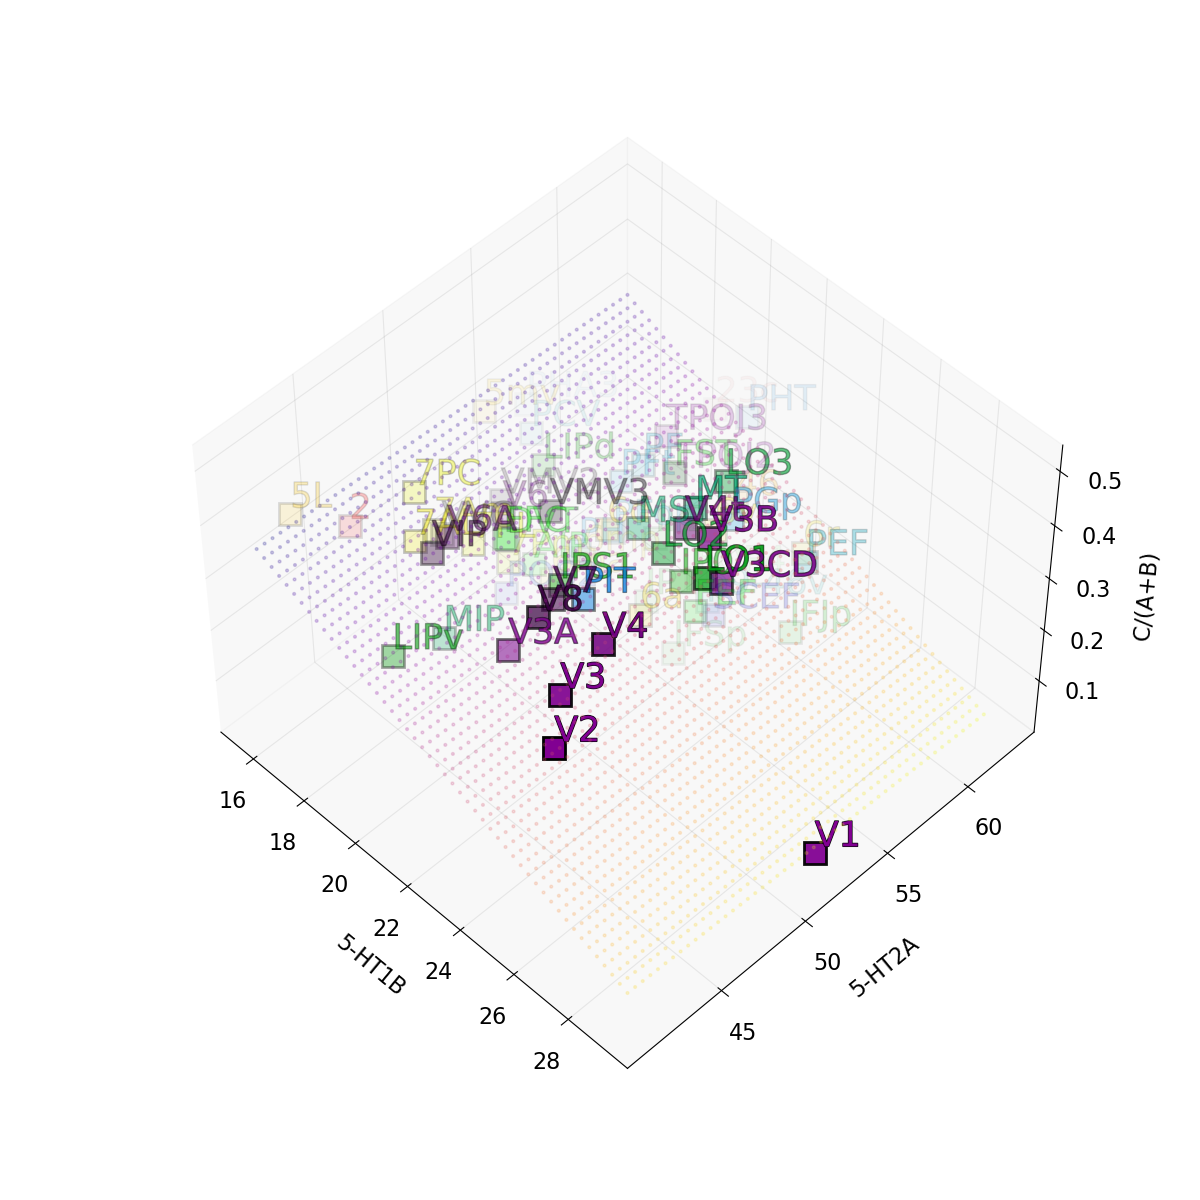

<IPython.core.display.Javascript object>


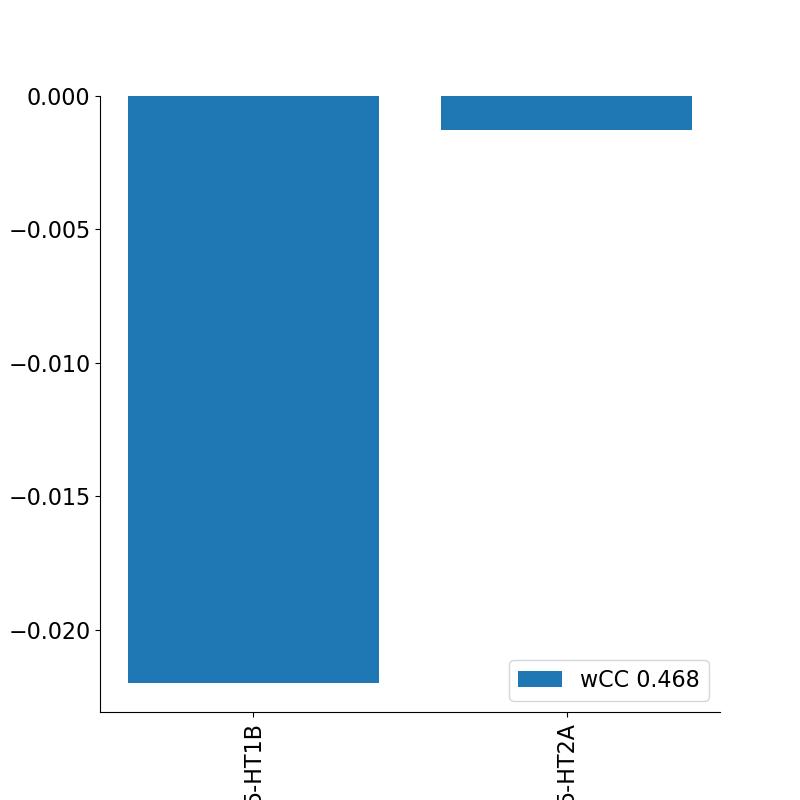

0

In [17]:
#%%capture
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
pl.close('all')
#fsnative vox vol for correction: 4.8270
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'
#'A/C'
####DoG
#'Surround volume (full)'
#'Surround/Centre Amplitude' 
#'Surround-Centre Amplitude'
#'Surround-Centre Volume'

#parameters = ['Eccentricity', 'Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)', 'Amplitude','Surround Amplitude', 'Polar Angle',
#              '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A','Amplitude','Surround Amplitude', 'RSq']#,]#'Size ratio (sigma_2/sigma_1)']# 'Size (sigma_1)', 'Size (sigma_2)', 'Amplitude','Surround Amplitude']

parameters = ['5-HT1A', '5-HT1B', '5-HT2A', 'GABA_A', '5-HTT','Norm Param. B', 'C/(A+B)', 'C/D', 'Norm Param. D', 'Size ratio (sigma_2/sigma_1)', 'RSq']#, 'Eccentricity','Size (sigma_1)','Size (sigma_2)']#

x_dims_idx = [1,2]
y_dims_idx = [6]

#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.IPS','all_custom']
#rois = ['V1', 'V2', 'V3','V3AB','hV4','LO','TO','VO','IPS']#, 'combined']#['Brain'] #'V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS','combined', 
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'LO1', 'LO2', 'TO1', 'TO2', 'V3A', 'V3B', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
#rois = ['all_custom']
rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]# and 'V1' not in roi]
# rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
# 'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
# 'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC']
rois.append('combined')
        
rsq_thresh = 0.0
save_figures= False
figure_path = '/Volumes/Crucial_X8/PRFMapping/Figures/attemptwnames_wang_ecc65rsq015/ols'

space_names = 'fsaverage'
#set to 'all' to plot all analyses
analysis_names = 'fit-task-BAR_fit-runs-all'#-CVmedian

subject_ids = ['fsaverage_cvrsq']#_1sthalf', 'fsaverage_cvrsq_2ndhalf']#']#_1sthalf', 'fsaverage_cvrsq_2ndhalf']#fsaverage, fsaverage_cvrsq, 'fsaverage_hcp1sthalf', 'fsaverage_hcp2ndhalf']

excluded_rois = ['excl_v123']

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=8.0, threshold_li=True, excluded_rois=excluded_rois)

#ols_results = dict()
#for y_dims_idx in [[5],[6]]:
#    for x_dims_idx in [[3, 4], [2, 4], [2, 3], [1, 4], [1, 3], [1, 2], [0, 4], [0, 3], [0, 2], [0, 1]]: #combinations:#

vis_res.multidim_analysis(parameters, rois, rsq_thresh, save_figures, figure_path, space_names = space_names, parameter_toplevel='Receptor Maps', rsq_weights= True,
                    analysis_names = analysis_names, subject_ids = subject_ids, x_dims_idx=x_dims_idx, y_dims_idx=y_dims_idx,
                          zscore_data= False, zscore_data_across_rois = False, 
                          size_response_curves = False, plot_corr_matrix = False, perform_ols = True, polar_plots = False,
                             cv_regression = False, bold_voxel_volume=4.096, zconfint_err_alpha=None, quantile_exclusion=0.999,
                          #vis_pca_comps_rois: fr which rois to make pca comp beta plots; 
                          #vis_pca_comps_axes: which comps to use in 2d plot of mean pca comp per roi
                        perform_pca = False, vis_pca_pycortex = True, vis_pca_comps_rois = ['combined'], vis_pca_comps_axes = [0,1], rsq_alpha_pca_plot = True,
                          perform_pls = False, vis_pls_pycortex = False)
        
 #       mergedict_OR(ols_results, vis_res.ols_result_dict)

os.system(f"open {sound_file}")


In [71]:
vis_res.ols_3d_fig.savefig('/Volumes/Crucial_X8/PRFMapping/Figures/OLS figs/normB_OLS_angle_view.pdf',dpi=600, bbox_inches='tight')

In [39]:
(gaba alone wCCcv:0.63, 1A alone wCCcv:-0.67). together wCCcv:0.85.  '5-HT1A' pval<10^-6, 'GABA_A' pval<10^-6 
(1B alone wCCcv:0.44, 2A alone wCCcv:-0.17). together wCCcv:0.58. '5-HT1B' pval=0.0000270 '5-HT2A' pval=0.0047390    
    
no V1
wCC_cv: (5-HT1B alone has 0.22, 5-HT2A 0.19) 0.4370
5-HT1B pval=0.0041210
5-HT2A pval=0.0128170

[0.0038]

In [ ]:
wCC prediction (fit on roi means, eval on roi means) 0.2669
Estimated OLS betas (fit on roi means) C/D Norm_abcd [-3543.5831  -355.2544]

5-HT1B pval=0.1020640
5-HT2A pval=0.7449550


In [7]:
import itertools

N = 4
numbers = list(range(N+1))

combinations = []
for i in range(1, N+2):
    combinations.extend(itertools.combinations(numbers, i))

print(combinations)

[(0,), (1,), (2,), (3,), (4,), (0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 3), (0, 2, 4), (0, 3, 4), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4), (0, 1, 2, 3, 4)]


In [10]:
for key in ols_results:
    this_param_model = []
    rec_models = []
    this_param_betas = []
    for key2 in ols_results[key]:
        rec_models.append(key2)
        this_param_model.append(np.mean(ols_results[key][key2]['wCC']))
        this_param_betas.append(np.mean(ols_results[key][key2]['betas'],axis=0))
    
    print(f"\n{key}")
    sorted_results = np.sort(this_param_model)[::-1]
    sorted_models = np.array(rec_models)[np.argsort(this_param_model)[::-1]]
    sorted_betas = np.array(this_param_betas)[np.argsort(this_param_model)[::-1]]
    for p in range(len(this_param_model)):
        print(f"{p}. wCC {sorted_results[p]:.4f}; recs {sorted_models[p]}; betas {sorted_betas[p]}")
    
    

In [ ]:
the hypothesis only concern a positive correlation of a parameter and a receptor. 
it does not concern the fact that the receptors should be taken as an actual model for the parameters.
im happy to see that in basically of the models the beta of the relevant receptor has the right sign.
we could analyze the following purely data driven result.
Norm Param. B Norm_abcd (main hypothesis:GABA_A++ 5-HT1A--)
0. wCC 0.8517; recs ['5-HT1A', '5-HT2A', 'GABA_A']; betas [-2.4156 -0.3072  0.265 ]
1. wCC 0.8516; recs ['5-HT1A', 'GABA_A']; betas [-2.5619  0.2509]                            
2. wCC 0.8498; recs ['5-HT1A', '5-HT2A', '5-HTT', 'GABA_A']; betas [-2.3502 -0.3609 -1.9602  0.2829]
3. wCC 0.8498; recs ['5-HT1A', '5-HTT', 'GABA_A']; betas [-2.5284 -1.6249  0.2637]
4. wCC 0.8492; recs ['5-HT1A', '5-HT1B', 'GABA_A']; betas [-2.5716 -0.0613  0.2521]
5. wCC 0.8481; recs ['5-HT1A', '5-HT1B', '5-HTT', 'GABA_A']; betas [-2.5445 -0.1337 -1.7595  0.2674]
6. wCC 0.8459; recs ['5-HT1A', '5-HT1B', '5-HT2A', 'GABA_A']; betas [-2.3316  0.3125 -0.4209  0.2631]
7. wCC 0.8445; recs ['5-HT1A', '5-HT1B', '5-HT2A', '5-HTT', 'GABA_A']; betas [-2.2826  0.2632 -0.454  -1.9356  0.2808]
8. wCC 0.8074; recs ['5-HT1B', '5-HT2A', '5-HTT', 'GABA_A']; betas [ 3.4742 -3.1947 -3.8479  0.3626]
9. wCC 0.8070; recs ['5-HT1B', '5-HT2A', 'GABA_A']; betas [ 3.7107 -3.2407  0.3303]
10. wCC 0.7799; recs ['5-HT1A', '5-HT2A', '5-HTT']; betas [-3.7255  1.7886 10.0753]
11. wCC 0.7737; recs ['5-HT1A', '5-HT1B', '5-HT2A', '5-HTT']; betas [-3.4338  0.914   1.3867 10.0692]
12. wCC 0.7723; recs ['5-HT2A', '5-HTT', 'GABA_A']; betas [-2.8975 -7.2758  0.458 ]
13. wCC 0.7691; recs ['5-HT1A', '5-HT1B', '5-HTT']; betas [-2.6233  2.6293 11.6214]
14. wCC 0.7643; recs ['5-HT2A', 'GABA_A']; betas [-2.9435  0.4062]
15. wCC 0.7496; recs ['5-HT1A', '5-HT2A']; betas [-3.9262  2.4157]
16. wCC 0.7440; recs ['5-HT1A', '5-HTT']; betas [-3.0214 13.9961]
17. wCC 0.7403; recs ['5-HT1A', '5-HT1B', '5-HT2A']; betas [-3.7023  0.7108  2.1053]
18. wCC 0.7245; recs ['5-HT1A', '5-HT1B']; betas [-2.4382  3.4758]
19. wCC 0.6676; recs ['5-HT1A']; betas [-2.945]
20. wCC 0.6586; recs ['5-HT1B', '5-HTT', 'GABA_A']; betas [ 2.3013 -6.0886  0.2858]
21. wCC 0.6561; recs ['5-HT1B', 'GABA_A']; betas [2.6532 0.2325]
22. wCC 0.6529; recs ['5-HT1B', '5-HT2A', '5-HTT']; betas [ 6.8945 -2.4954 12.8146]
23. wCC 0.6408; recs ['5-HTT', 'GABA_A']; betas [-8.2831  0.3559]
24. wCC 0.6317; recs ['GABA_A']; betas [0.2949]
25. wCC 0.5952; recs ['5-HT1B', '5-HT2A']; betas [ 7.2399 -1.9586]
26. wCC 0.5362; recs ['5-HT1B', '5-HTT']; betas [5.3409 8.0821]
27. wCC 0.5137; recs ['5-HT1B']; betas [5.7976]
28. wCC 0.3484; recs ['5-HT2A', '5-HTT']; betas [-1.2066 15.3508]
29. wCC 0.3007; recs ['5-HTT']; betas [12.4451]
30. wCC 0.0782; recs ['5-HT2A']; betas [-0.4745]

Norm Param. D Norm_abcd (main hypothesis:5-HT1B++ 5-HT2A--)
0. wCC 0.6549; recs ['5-HT1A', '5-HT1B', '5-HTT', 'GABA_A']; betas [-0.6468  0.4416 -2.057   0.0422]
1. wCC 0.6519; recs ['5-HT1A', '5-HT1B', 'GABA_A']; betas [-0.6749  0.5313  0.0245]
2. wCC 0.6519; recs ['5-HT1A', '5-HT1B', '5-HT2A', '5-HTT', 'GABA_A']; betas [-0.4418  0.7589 -0.3522 -2.1799  0.0524]
3. wCC 0.6490; recs ['5-HT1A', '5-HT1B', '5-HT2A', 'GABA_A']; betas [-0.4917  0.8218 -0.3175  0.0327]
4. wCC 0.6476; recs ['5-HT1A', '5-HTT', 'GABA_A']; betas [-0.6917 -2.3629  0.0541]
5. wCC 0.6416; recs ['5-HT1B', '5-HT2A', '5-HTT', 'GABA_A']; betas [ 1.3862 -0.8836 -2.5263  0.0681]
6. wCC 0.6408; recs ['5-HT1A', '5-HT2A', '5-HTT', 'GABA_A']; betas [-0.6724 -0.0387 -2.3914  0.0561]
7. wCC 0.6407; recs ['5-HT1A', 'GABA_A']; betas [-0.735   0.0359]
8. wCC 0.6368; recs ['5-HT1A', '5-HT1B']; betas [-0.6616  0.8768]
9. wCC 0.6358; recs ['5-HT1A', '5-HT2A', 'GABA_A']; betas [-0.7487  0.0285  0.0346]
10. wCC 0.6351; recs ['5-HT1A', '5-HT1B', '5-HTT']; betas [-0.6609  0.8766  0.0529]
11. wCC 0.6318; recs ['5-HT1A', '5-HT1B', '5-HT2A']; betas [-0.6592  0.8808 -0.0059]
12. wCC 0.6315; recs ['5-HT1B', '5-HT2A', 'GABA_A']; betas [ 1.5417 -0.9125  0.0469]
13. wCC 0.6314; recs ['5-HT1A', '5-HT1B', '5-HT2A', '5-HTT']; betas [-0.6563  0.8852 -0.0109  0.062 ]
14. wCC 0.6200; recs ['5-HT1A', '5-HT2A']; betas [-0.946   0.3857]
15. wCC 0.6197; recs ['5-HT1A', '5-HT2A', '5-HTT']; betas [-0.9458  0.3867 -0.0029]
16. wCC 0.5966; recs ['5-HT1A', '5-HTT']; betas [-0.7936  0.8451]
17. wCC 0.5932; recs ['5-HT1A']; betas [-0.7893]
18. wCC 0.5787; recs ['5-HT1B', '5-HT2A']; betas [ 2.0445 -0.7297]                           
19. wCC 0.5779; recs ['5-HT1B', '5-HT2A', '5-HTT']; betas [ 2.0296 -0.7532  0.5929]
20. wCC 0.5584; recs ['5-HT2A', '5-HTT', 'GABA_A']; betas [-0.7647 -3.9023  0.1061]
21. wCC 0.5128; recs ['5-HT2A', 'GABA_A']; betas [-0.7881  0.0784]
22. wCC 0.4793; recs ['5-HT1B', '5-HTT', 'GABA_A']; betas [ 1.0618 -3.1453  0.0468]
23. wCC 0.4554; recs ['5-HT1B', 'GABA_A']; betas [1.244  0.0194]
24. wCC 0.4420; recs ['5-HT1B']; betas [1.5074]
25. wCC 0.4413; recs ['5-HT1B', '5-HTT']; betas [ 1.5601 -0.8308]
26. wCC 0.4152; recs ['5-HTT', 'GABA_A']; betas [-4.1705  0.0792]
27. wCC 0.3412; recs ['GABA_A']; betas [0.0486]
28. wCC 0.1954; recs ['5-HT2A', '5-HTT']; betas [-0.3737  1.3386]
29. wCC 0.1726; recs ['5-HT2A']; betas [-0.3106]
30. wCC 0.0373; recs ['5-HTT']; betas [0.4434]

## PCA

fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
thresholding at 27.290789658414187 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq_2ndhalf
thresholding at 13.847806913306545 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq_1sthalf
thresholding at 13.11686366363076 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
Make sure bold_voxel_volume is specified in mm^3
Upsampling correction factor: [2.1213]
fit-task-BAR_fit-runs-all fsaverage_cvrsq glasser_1
X-dims: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4']
Y-dims: ['5-HTT', 'GABA_A']
alldims ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A']
ord dims ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Sample size: 0
fit-

<IPython.core.display.Javascript object>


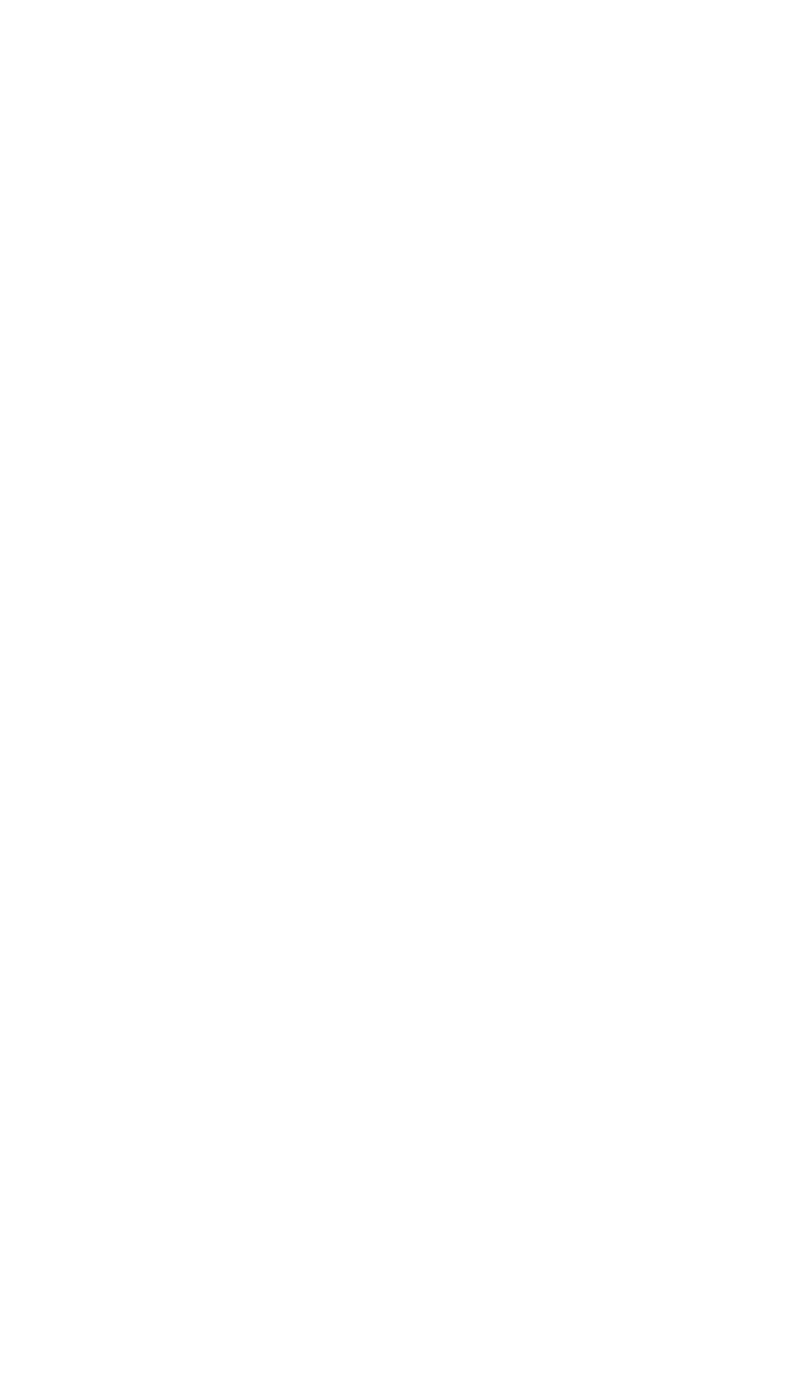

<IPython.core.display.Javascript object>


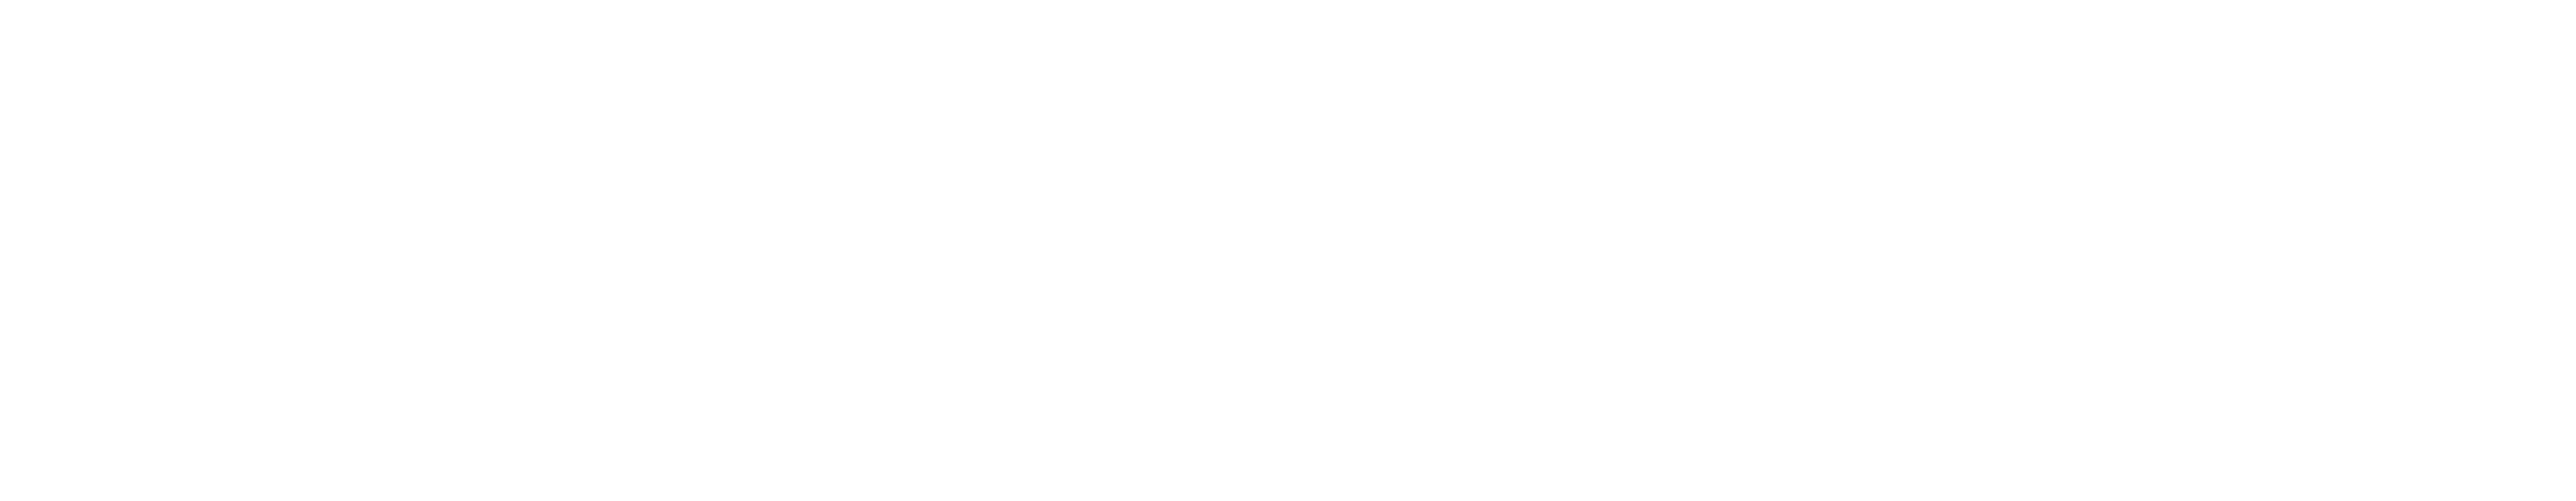

PCA component 1 (R2=0.47)
PCA component 2 (R2=0.34)
PCA component 3 (R2=0.11)
PCA component 4 (R2=0.04)
PCA component 5 (R2=0.03)
PCA component 6 (R2=0.02)


/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)


wCC (roi means) PCA comp 1 VS Amplitude Norm_abcd: 0.3255 ---
wCC (roi means) PCA comp 1 VS Eccentricity Norm_abcd: -0.4549 ---
wCC (roi means) PCA comp 1 VS Norm Param. B Norm_abcd: -0.8265 ---
wCC (roi means) PCA comp 1 VS Norm Param. D Norm_abcd: -0.6206 ---
wCC (roi means) PCA comp 1 VS Polar Angle Norm_abcd: -0.3547 ---
wCC (roi means) PCA comp 1 VS Size (sigma_1) Norm_abcd: 0.5450 ---
wCC (roi means) PCA comp 1 VS Size (sigma_2) Norm_abcd: 0.3925 ---
wCC (roi means) PCA comp 1 VS Size ratio (sigma_2/sigma_1) Norm_abcd: -0.7961 ---
wCC (roi means) PCA comp 1 VS Surround Amplitude Norm_abcd: 0.5891 ---
wCC (roi means) PCA comp 2 VS Amplitude Norm_abcd: -0.0103 ---
wCC (roi means) PCA comp 2 VS Eccentricity Norm_abcd: -0.0434 ---
wCC (roi means) PCA comp 2 VS Norm Param. B Norm_abcd: 0.2104 ---
wCC (roi means) PCA comp 2 VS Norm Param. D Norm_abcd: 0.3432 ---
wCC (roi means) PCA comp 2 VS Polar Angle Norm_abcd: 0.0104 ---
wCC (roi means) PCA comp 2 VS Size (sigma_1) Norm_abcd: -0.22

<IPython.core.display.Javascript object>


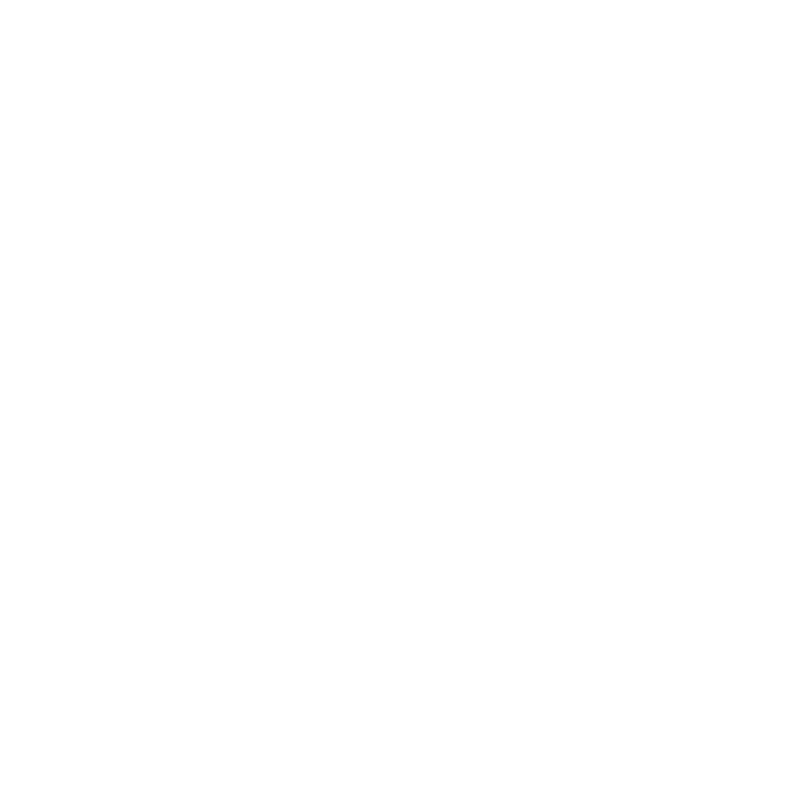

0

In [22]:
#%%capture
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
pl.close('all')
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'
#'A/C'
####DoG
#'Surround volume (full)'
#'Surround/Centre Amplitude' 
#'Surround-Centre Amplitude'
#'Surround-Centre Volume'

#parameters = ['Eccentricity', 'Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)', 'Amplitude','Surround Amplitude', 'Polar Angle',
#              '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A','Amplitude','Surround Amplitude', 'RSq']#,]#'Size ratio (sigma_2/sigma_1)']# 'Size (sigma_1)', 'Size (sigma_2)', 'Amplitude','Surround Amplitude']

parameters = ['5-HT1A','5-HT4', '5-HT1B', '5-HT2A', 'GABA_A', '5-HTT','Amplitude','Surround Amplitude', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Polar Angle', 'Size (sigma_1)', 'Size (sigma_2)','Size ratio (sigma_2/sigma_1)','RSq']#

x_dims_idx = [0,1,2,3]
y_dims_idx = [4,5]

#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.IPS','all_custom']
#rois = ['V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS', 'combined']#['Brain'] #'V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS','combined', 
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1']#, 'combined']
#rois = ['all_custom']
left, right = cortex.db.fsaverage.surfaces.inflated.get()
points = np.concatenate((left[0],right[0]))
left_flat, right_flat = cortex.db.fsaverage.surfaces.flat.get()
points_flat = np.concatenate((left_flat[0],right_flat[0]))

rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]

#nodorsal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points_flat[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<20]
#nofrontal
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi and points[vis_res.idx_rois['fsaverage'][roi],:].mean(0)[1]<-40]
#rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
#'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
#'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC']
rois.append('combined')
        
rsq_thresh = 0.0
save_figures= False
figure_path = '/Volumes/Crucial_X8/PRFMapping/Figures/pca_figs'

space_names = 'fsaverage'
#set to 'all' to plot all analyses
analysis_names = 'fit-task-BAR_fit-runs-all'#''fit-task-BAR_fit-runs-CVmedian'# 'fit-task-BAR_fit-runs-all'#'fit-task-BAR_fit-runs-CVmedian'
subject_ids = ['fsaverage_cvrsq']#'fsaverage_hcp1sthalf', 'fsaverage_hcp2ndhalf']

excluded_rois = ['excl_v123']

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=8.0, threshold_li=True, excluded_rois=excluded_rois)

vis_res.multidim_analysis(parameters, rois, rsq_thresh, save_figures, figure_path, space_names = space_names, parameter_toplevel='Receptor Maps', rsq_weights= True,
                    analysis_names = analysis_names, subject_ids = subject_ids, x_dims_idx=x_dims_idx, y_dims_idx=y_dims_idx,
                          zscore_data= False, zscore_data_across_rois = False, #data that goes into pca is always automatically zscored even if this is false
                          size_response_curves = False, plot_corr_matrix = False, perform_ols = False, polar_plots = False,
                             cv_regression = False, bold_voxel_volume=4.096, zconfint_err_alpha=None, quantile_exclusion=0.999,
                          #vis_pca_comps_rois: fr which rois to make pca comp beta plots; 
                          #vis_pca_comps_axes: which comps to use in 2d plot of mean pca comp per roi
                        perform_pca = True, vis_pca_pycortex = False, vis_pca_comps_rois = ['combined'], vis_pca_comps_axes = [0,1], rsq_alpha_pca_plot = True,
                          perform_pls = False, vis_pls_pycortex = False)

os.system(f"open {sound_file}")


In [14]:
np.save('/Users/marcoaqil/fsavglasserL.npy', np.concatenate(tuple([vis_res.idx_rois['fsaverage'][roi] for roi in vis_res.idx_rois['fsaverage'] if 'lh.glasser' in roi])))#np.concatenate(tuple([vis_res.idx_rois['999999'][roi] for roi in vis_res.idx_rois['999999'] if 'V1L' in roi])))

In [15]:
np.save('/Users/marcoaqil/fsavV1R.npy', vis_res.idx_rois['fsaverage']['rh.glasser_V1'])#np.concatenate(tuple([vis_res.idx_rois['fsaverage'][roi] for roi in vis_res.idx_rois['fsaverage'] if 'lh.glasser' in roi])))

In [16]:
 vis_res.idx_rois['fsaverage']['rh.glasser_V1']

array([163873, 163925, 163973, ..., 325798, 325799, 325800])

In [11]:
vis_res.idx_rois['fsaverage'].keys()

dict_keys(['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF', 'visual_system', 'V1', 'V2', 'V3', 'VO', 'TO', 'LO', 'V3AB', 'IPS', 'custom.hV4', 'custom.IPS', 'custom.LO', 'custom.TO', 'custom.V1', 'custom.V2', 'custom.V3', 'custom.V3AB', 'lh.glasser_1', 'lh.glasser_10d', 'lh.glasser_10pp', 'lh.glasser_10r', 'lh.glasser_10v', 'lh.glasser_11l', 'lh.glasser_13l', 'lh.glasser_2', 'lh.glasser_23c', 'lh.glasser_23d', 'lh.glasser_24dd', 'lh.glasser_24dv', 'lh.glasser_25', 'lh.glasser_31a', 'lh.glasser_31pd', 'lh.glasser_31pv', 'lh.glasser_33pr', 'lh.glasser_3a', 'lh.glasser_3b', 'lh.glasser_4', 'lh.glasser_43', 'lh.glasser_44', 'lh.glasser_45', 'lh.glasser_46', 'lh.glasser_47l', 'lh.glasser_47m', 'lh.glasser_47s', 'lh.glasser_52', 'lh.glasser_55b', 'lh.glasser_5L', 'lh.glasser_5m', 'lh.glasser_5mv', 'lh.glasser_6a', 'lh.glasser_6d', 'lh.glasser_6ma', 'lh.glasser

## PLS

In [ ]:
#%%capture
#display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
pl.close('all')
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'
#'A/C'
####DoG
#'Surround volume (full)'
#'Surround/Centre Amplitude' 
#'Surround-Centre Amplitude'
#'Surround-Centre Volume'

#parameters = ['Eccentricity', 'Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)', 'Amplitude','Surround Amplitude', 'Polar Angle',
#              '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A','Amplitude','Surround Amplitude', 'RSq']#,]#'Size ratio (sigma_2/sigma_1)']# 'Size (sigma_1)', 'Size (sigma_2)', 'Amplitude','Surround Amplitude']

parameters = ['5-HT1A', '5-HT1B', '5-HT2A', 'GABA_A', '5-HTT', 'Eccentricity','Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)','RSq']#

x_dims_idx = [0,1,2,3,4]
y_dims_idx = [5,6,7,8,9]

#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.IPS','all_custom']
#rois = ['V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS', 'combined']#['Brain'] #'V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS','combined', 
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1']#, 'combined']
#rois = ['all_custom']
rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
#rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
#'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
#'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC']
rois.append('combined')
        
rsq_thresh = 0.0
save_figures= False
figure_path = '/Volumes/Crucial_X8/PRFMapping/Figures/attemptwnames_glasser_ecc65rsq030/pls'

space_names = 'fsaverage'
#set to 'all' to plot all analyses
analysis_names = 'fit-task-BAR_fit-runs-all'#'fit-task-BAR_fit-runs-CVmedian'

subject_ids = ['fsaverage_cvrsq']#['fsaverage_hcp1sthalf', 'fsaverage_hcp2ndhalf']

excluded_rois = []

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=8.0, threshold_li=True, excluded_rois=excluded_rois)

vis_res.multidim_analysis(parameters, rois, rsq_thresh, save_figures, figure_path, space_names = space_names, parameter_toplevel='Receptor Maps', rsq_weights= True,
                    analysis_names = analysis_names, subject_ids = subject_ids, x_dims_idx=x_dims_idx, y_dims_idx=y_dims_idx,
                          zscore_data= False, zscore_data_across_rois = True, 
                          size_response_curves = False, plot_corr_matrix = False, perform_ols = False, polar_plots = False,
                             cv_regression = False, bold_voxel_volume=4.096, zconfint_err_alpha=None, quantile_exclusion=0.999,
                          #vis_pca_comps_rois: fr which rois to make pca comp beta plots; 
                          #vis_pca_comps_axes: which comps to use in 2d plot of mean pca comp per roi
                        perform_pca = False, vis_pca_pycortex = False, vis_pca_comps_rois = ['combined'], vis_pca_comps_axes = [0,1], rsq_alpha_pca_plot = True,
                          perform_pls = True, vis_pls_pycortex = False)

os.system(f"open {sound_file}")


## Size-response curves

In [ ]:
vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-all']['fsaverage_cvrsq']['analysis_info'] = vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all']['100610']['analysis_info']

In [ ]:
#%%capture
#display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
pl.close('all')
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'
#'A/C'
####DoG
#'Surround volume (full)'
#'Surround/Centre Amplitude' 
#'Surround-Centre Amplitude'
#'Surround-Centre Volume'

parameters = ['Eccentricity', 'Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)', 'Polar Angle',
              '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A','Amplitude','Surround Amplitude', 'RSq']#,'Amplitude','Surround Amplitude']#'Size ratio (sigma_2/sigma_1)']# 'Size (sigma_1)', 'Size (sigma_2)', 'Amplitude','Surround Amplitude']

x_dims_idx = [0,1,2,3,4,5]
y_dims_idx = [12,13]

third_dim_sr_curves = '5-HT1A'#'Norm Param. D Norm_abcd'

rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.VO','custom.IPS']
#rois = ['V1', 'V2', 'V3','V3AB','hV4','LO','TO','VO','IPS']#,'combined']#[roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi] #'V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS','combined', 
#rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
#rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
#'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
#'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC']
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'combined']
#rois = ['all_custom']
        
rsq_thresh = 0.15
save_figures = False
figure_path = '/Volumes/Crucial_X8/PRFMapping/Figures/newfsarsqwmlowthr/size_response_glasser'

space_names = 'fsaverage'
#set to 'all' to plot all analyses
analysis_names = 'fit-task-BAR_fit-runs-all'

subject_ids = ['fsaverage_cvrsq']#'fsaverage_hcp1sthalf', 'fsaverage_hcp2ndhalf']

excluded_rois = []

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=8.0, threshold_li=True, excluded_rois=excluded_rois)

vis_res.multidim_analysis(parameters, rois, rsq_thresh, save_figures, figure_path, space_names = space_names, parameter_toplevel='Receptor Maps', rsq_weights= True,
                    analysis_names = analysis_names, subject_ids = subject_ids, x_dims_idx=x_dims_idx, y_dims_idx=y_dims_idx,
                          zscore_data = False, zscore_data_across_rois = False, 
                          size_response_curves = True, third_dim_sr_curves = third_dim_sr_curves,
                          plot_corr_matrix = False, perform_ols = False, polar_plots = False,
                             cv_regression = False, bold_voxel_volume=4.096, zconfint_err_alpha=None, quantile_exclusion=0.999,
                            #vis_pca_comps_rois: fr which rois to make pca comp beta plots; 
                          #vis_pca_comps_axes: which comps to use in 2d plot of mean pca comp per roi
                        perform_pca = False, vis_pca_pycortex = False, vis_pca_comps_rois = ['combined'], vis_pca_comps_axes = [0,1], rsq_alpha_pca_plot = True,
                          perform_pls = False, vis_pls_pycortex = False)

os.system(f"open {sound_file}")

In [ ]:
[[3, 4], [2, 4], [2, 3], [1, 4], [1, 3], [1, 2], [0, 4], [0, 3], [0, 2], [0, 1]]

In [ ]:
import itertools

N = 4
numbers = list(range(N+1))

combinations = []
for i in range(1, N+2):
    combinations.extend(itertools.combinations(numbers, i))

print(combinations[::-1])

## Correlation matrix

fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
thresholding at 27.290789658414187 subjects
fsaverage fit-task-BAR_fit-runs-all fsaverage_cvrsq
Make sure bold_voxel_volume is specified in mm^3
Upsampling correction factor: [2.1213]
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordere

Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_

Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_

Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
Ordered dimensions: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm_abcd', 'Ratio (B/D) Norm_

<IPython.core.display.Javascript object>


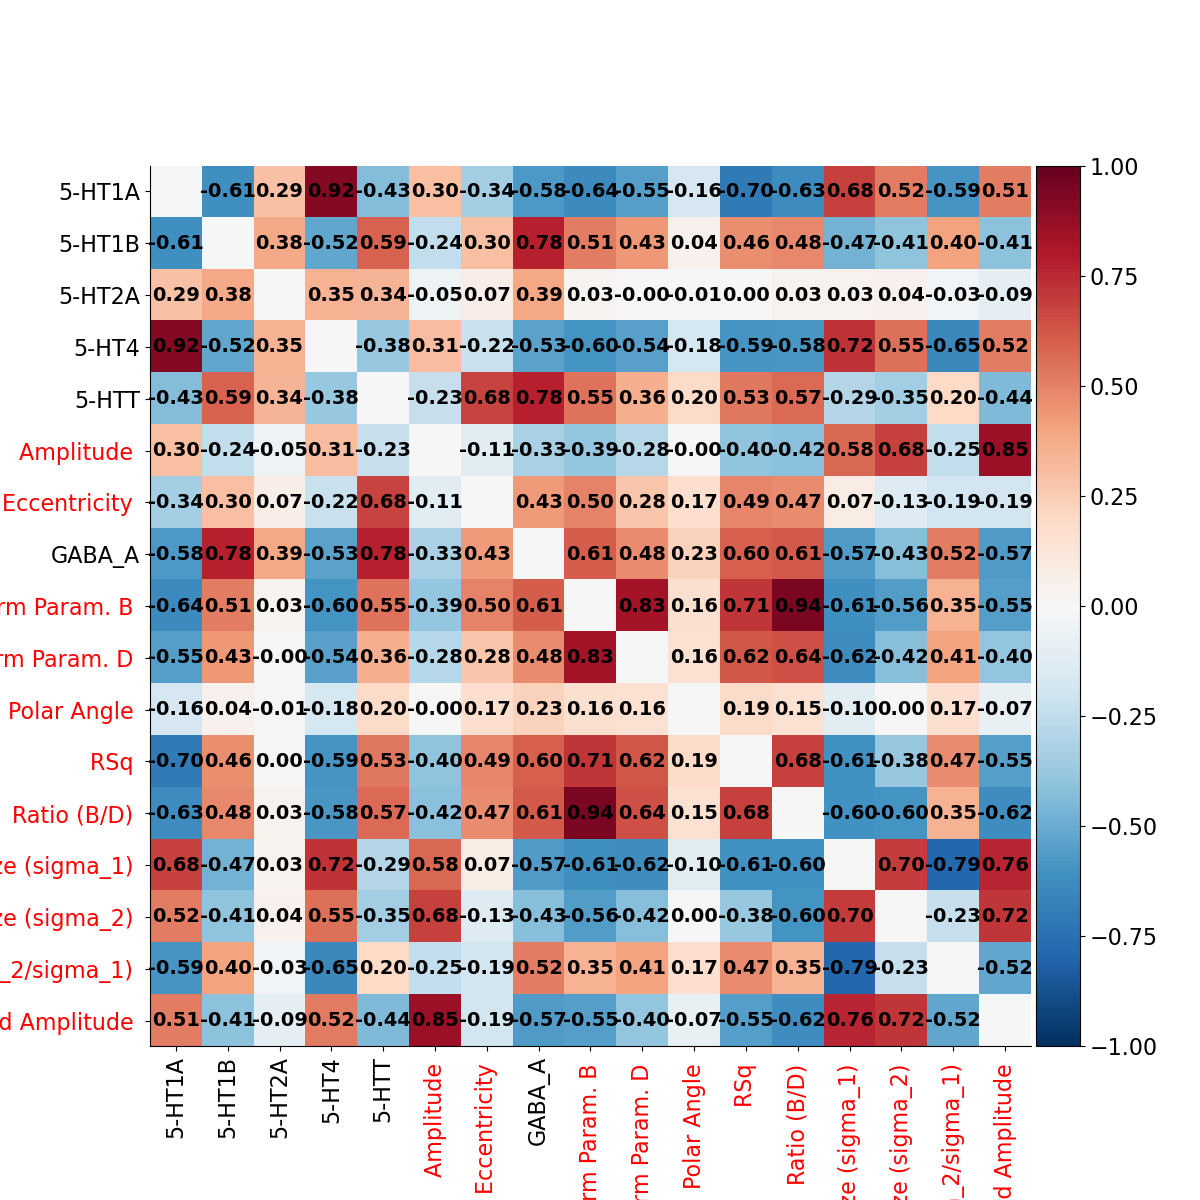

fit-task-BAR_fit-runs-all fsaverage_cvrsq glasser_1
X-dims: ['Eccentricity Norm_abcd', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd']
Y-dims: ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'GABA_A', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
alldims ['Eccentricity Norm_abcd', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'Size (sigma_1) Norm_abcd', 'Size (sigma_2) Norm_abcd', '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'GABA_A', 'RSq Norm_abcd', 'Ratio (B/D) Norm_abcd', 'Size ratio (sigma_2/sigma_1) Norm_abcd', 'Surround Amplitude Norm_abcd']
ord dims ['5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'Amplitude Norm_abcd', 'Eccentricity Norm_abcd', 'GABA_A', 'Norm Param. B Norm_abcd', 'Norm Param. D Norm_abcd', 'Polar Angle Norm_abcd', 'RSq Norm

0

In [6]:
#%%capture
#display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
pl.close('all')
#generalized quantitative parameter plots
#'Eccentricity'#'Suppression Index (full)'#'Suppression Index#'Size (fwhmax)'#'Surround Size (fwatmin)'
#'Norm Param. B'#''Ratio (B/D)'#'Norm Param. D'#'RSq'#'CCrsq_task-1R'#'CSS Exponent'#'Amplitude'
#'Surround Amplitude'#'Size (sigma_1)'##'Size (sigma_2)'
#'Size ratio (sigma_2/sigma_1)'#C/A#'B/A'#'D/C'#'D/A'#'B/C'#'Surround volume (full)'#'Centre volume (full)'
#'(A+B)/(C+D)'#'(A*B)/(C*D)'#'(A*D)/(C*B)'#'(A+D)/(C+B)'#'Point-stim derivative'#'(C(A+B))/(A(C+D))'
#'Min/Max Response Ratio'#'Max/Min Response Ratio'#'A(C+D)/C(A+B)'##Min/Max Response Ratio (with BD)'
#'A/C'
####DoG
#'Surround volume (full)'
#'Surround/Centre Amplitude' 
#'Surround-Centre Amplitude'
#'Surround-Centre Volume'

parameters = ['Eccentricity', 'Norm Param. B', 'Norm Param. D', 'Size (sigma_1)','Size (sigma_2)', 'Polar Angle', 'Size ratio (sigma_2/sigma_1)', 'Ratio (B/D)',
              '5-HT1A', '5-HT1B', '5-HT2A', '5-HT4', '5-HTT', 'GABA_A','Amplitude','Surround Amplitude', 'RSq']#,'Amplitude','Surround Amplitude']#'Size ratio (sigma_2/sigma_1)']# 'Size (sigma_1)', 'Size (sigma_2)', 'Amplitude','Surround Amplitude']

x_dims_idx = [0,1,2,3,4,5]
y_dims_idx = [6,7,8,9,10,11,12,13,14,15,16]

#rois = ['custom.V1', 'custom.V2', 'custom.V3','custom.V3AB','custom.hV4','custom.LO','custom.TO','custom.VO','custom.IPS']
#rois = ['V1', 'V2', 'V3','V3AB','hV4','LO','TO','VO','IPS']#,'combined']#[roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi] #'V1', 'V2', 'V3','V3AB','hV4','LO','TO','IPS','combined', 
rois = [roi for roi in vis_res.idx_rois['fsaverage'] if 'glasser' in roi]
#rois = ['glasser_V1','glasser_V2','glasser_V3','glasser_V4','glasser_V3A','glasser_V7','glasser_V3B','glasser_V3CD',
#'glasser_LO1','glasser_LO2','glasser_PIT','glasser_V8','glasser_VMV3',
#'glasser_IPS1','glasser_IP0','glasser_PGp','glasser_LO3','glasser_MT','glasser_V4t','glasser_FFC']
#rois = [ 'V1', 'V2', 'V3', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'combined']
#rois = ['all_custom']
rois.append('combined') 
    
rsq_thresh = 0.0
save_figures = False
figure_path = '/Volumes/Crucial_X8/PRFMapping/Figures/newfsarsqwmlowthr/correlation_matrix'

space_names = 'fsaverage'
#set to 'all' to plot all analyses
analysis_names = 'fit-task-BAR_fit-runs-all'#'Mean analysis'#

subject_ids = ['fsaverage_cvrsq']#'fsaverage_hcp1sthalf', 'fsaverage_hcp2ndhalf']

excluded_rois = []

vis_res.set_alpha(only_models=['Norm_abcd'], ecc_min=0.0, ecc_max=8.0, threshold_li=True, excluded_rois=excluded_rois)

vis_res.multidim_analysis(parameters, rois, rsq_thresh, save_figures, figure_path, space_names = space_names, parameter_toplevel='Receptor Maps', rsq_weights= True,
                    analysis_names = analysis_names, subject_ids = subject_ids, x_dims_idx=x_dims_idx, y_dims_idx=y_dims_idx,
                          zscore_data = False, zscore_data_across_rois = False, 
                          size_response_curves = False, third_dim_sr_curves = None,
                          plot_corr_matrix = True, perform_ols = False, polar_plots = False,
                             cv_regression = False, bold_voxel_volume=4.096, zconfint_err_alpha=None, quantile_exclusion=0.999,
                            #vis_pca_comps_rois: fr which rois to make pca comp beta plots; 
                          #vis_pca_comps_axes: which comps to use in 2d plot of mean pca comp per roi
                        perform_pca = False, vis_pca_pycortex = False, vis_pca_comps_rois = ['combined'], vis_pca_comps_axes = [0,1], rsq_alpha_pca_plot = True,
                          perform_pls = False, vis_pls_pycortex = False)

os.system(f"open {sound_file}")

# HCP Crossvalidation

## Simple viz

In [ ]:
full_rsq = np.concatenate(tuple([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()]))
full_rsq_gauss = np.concatenate(tuple([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Gauss'] for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()]))

In [ ]:
nc = np.concatenate(tuple([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['Noise Ceiling']['Noise Ceiling (RSq)'] for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()]))


In [ ]:
thresh = -10
#mask_rsq = ((nc>thresh) + (full_rsq>thresh) + (full_rsq_gauss>thresh)) * (full_rsq_gauss!=0) * (full_rsq!=0) * ((nc>-5) * (full_rsq>-5) * (full_rsq_gauss>-5))
mask_rsq = (nc>thresh) * (full_rsq>thresh) * (full_rsq_gauss>thresh) #* (full_rsq_gauss!=0) * (full_rsq!=0) 

In [ ]:
np.nanquantile(nc[mask_rsq],0.1)

In [ ]:
pl.figure(figsize=(16,8))
pl.hist(full_rsq_gauss[mask_rsq],bins=np.linspace(thresh,1,1000), label='gauss cvr2', alpha=0.8)
pl.hist(full_rsq[mask_rsq],bins=np.linspace(thresh,1,1000), label='DN cvr2', alpha=0.8)
pl.hist(nc[mask_rsq],bins=np.linspace(thresh,1,1000), label='noise ceiling', alpha=0.8)
pl.axvline(np.mean(full_rsq[mask_rsq]), color='r', linestyle='dashed', linewidth=1, label=f'DN cvr2 mean ({np.mean(full_rsq[mask_rsq]):.2f})')
pl.axvline(np.mean(full_rsq_gauss[mask_rsq]), color='k', linestyle='dashed', linewidth=1, label=f'gauss cvr2 mean ({np.mean(full_rsq_gauss[mask_rsq]):.2f})')
pl.axvline(np.mean(nc[mask_rsq]), color='b', linestyle='dashed', linewidth=1, label=f'noise ceiling mean ({np.mean(nc[mask_rsq]):.2f})')
pl.axvline(np.median(full_rsq[mask_rsq]), color='r', linewidth=1, label=f'DN cvr2 median ({np.median(full_rsq[mask_rsq]):.2f}) ')
pl.axvline(np.median(full_rsq_gauss[mask_rsq]), color='k', linewidth=1, label=f'gauss cvr2 median ({np.median(full_rsq_gauss[mask_rsq]):.2f})')
pl.axvline(np.median(nc[mask_rsq]), color='b', linewidth=1, label=f'noise ceiling median ({np.median(nc[mask_rsq]):.2f})')
pl.legend()

pl.title(f'crossvalidated r2 distribution and noise ceiling (threshold: {thresh:.2f}. vertices: {np.sum(mask_rsq)})')

In [ ]:
pl.figure(figsize=(16,8))
diff = full_rsq[mask_rsq]-full_rsq_gauss[mask_rsq]
pl.hist(diff,bins=1000, label='diff', alpha=0.8)
pl.axvline(np.mean(diff), color='k', linestyle='dashed', linewidth=1, label='diff cvr2 mean')
pl.axvline(np.median(diff), color='k', linewidth=1, label='diff cvr2 median')
pl.legend()
pl.xlim((-1,1))

## Combining no-cv results with CV-rsq and # of subjects map

In [24]:
#rsqwm have rsq-weighted means over subjects on fsaverage
#maindict_ #allall, allruns_sepcond_rsqwm, 5050CV, allruns_sepcond_zsc, HCP_181subjects_rsqwm, HCP_999999, 99mean181, 99split20, HCP_cv (tcfit), HCP_tc_nocv
with open('/Volumes/Crucial_X8/maindict_HCP_cv.pickle', 'rb') as handle:
    dict_cv=renamed_load(handle)

In [13]:
dict_cv = vis_res.main_dict

In [14]:
l = [sj for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'].keys()]
l.sort()

In [15]:
#all
m = [sj for sj in dict_cv['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys() if sj in l]
m.sort()

In [8]:
#one half
m = [sj for sj in dict_cv['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys() if sj in l][::2]
m.sort()

In [11]:
#the other half
m = [sj for sj in dict_cv['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys() if sj in l][1::2]
m.sort()

In [17]:
from skimage import filters
hcp_group_average = dict()
ds_pyc = dict()

#only works on fsaverage because 'HCP' is not treated as a common space so it has one fewer layer in depth
#create the HCP_cvrsq subject manually if you want to do it in HCP space
space = 'fsaverage'  
if space == 'fsaverage':
    pyc_sj = 'fsaverage'
else:
    pyc_sj = '999999'

weights = np.nan_to_num(np.array([dict_cv[space]['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in m]))
weights[weights<=0] = 0


sj_number_map = np.sum(weights>0, axis=0)
threshold_li = filters.threshold_li(sj_number_map)
print(threshold_li)
# 'A/D', 'C/D', 'A/B', 'C/B', 'Nvol/D', 'Nvol/B', 'Avol/D', 'Avol/B'  'D/A', 'D/C', 'B/A', 'B/C', 'D/Nvol', 'B/Nvol', 'D/Avol', 'B/Avol'
for param in ['C/(A+B+D)']:#'RSq', 'A/l2norm_abcd', 'B/l2norm_abcd', 'C/l2norm_abcd', 'D/l2norm_abcd']:# 'x_pos', 'y_pos','Norm Param. B','Norm Param. D','Amplitude', 'Surround Amplitude','Size (fwhmax)','Surround Size (fwatmin)','Size (sigma_1)','Size (sigma_2)', 'hrf_1', 'hrf_2']:
    if param == 'x_pos':
        data = np.nan_to_num(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][sj]['Processed Results']['Eccentricity']['Norm_abcd'] for sj in m])*np.cos(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][sj]['Processed Results']['Polar Angle']['Norm_abcd'] for sj in m])))
    elif param == 'y_pos':
        data = np.nan_to_num(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][sj]['Processed Results']['Eccentricity']['Norm_abcd'] for sj in m])*np.sin(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][sj]['Processed Results']['Polar Angle']['Norm_abcd'] for sj in m])))
    
    elif param == 'RSq':
        data = np.copy(weights)
    else:
        data = np.nan_to_num(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][sj]['Processed Results'][param]['Norm_abcd'] for sj in m]))

    if param == 'RSq':
        hcp_group_average[param] = (data*(weights>0)).sum(0)/(weights>0).sum(0)
    else:
        hcp_group_average[param] = (data*weights).sum(0)/weights.sum(0)


# with open('/Volumes/Crucial_X8/maindict_HCP_cv.pickle', 'rb') as handle:
#     dict_cv_no_hrf_fit=dill.load(handle)
# hcp_group_average['Rsqdiff_hrf_fit'] = np.nanmean(np.nan_to_num(np.array([vis_res.main_dict[space]['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd']-\
#                                                                           dict_cv_no_hrf_fit[space]['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in m])), axis=0)

    
#hcp_group_average['Polar Angle'] = np.arctan2(hcp_group_average['y_pos'], hcp_group_average['x_pos'])
#hcp_group_average['Eccentricity'] = np.sqrt(hcp_group_average['y_pos']**2 + hcp_group_average['x_pos']**2) 
hcp_group_average['#Subjects with CVRSq>0'] = np.copy(sj_number_map)



27.290789658414187


/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_77737/2825960057.py:35: RuntimeWarning: invalid value encountered in divide
  hcp_group_average[param] = (data*weights).sum(0)/weights.sum(0)


In [19]:
for param in ['C/(A+B+D)']:#'A/l2norm_abcd', 'B/l2norm_abcd', 'C/l2norm_abcd', 'D/l2norm_abcd']:
    vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results'][param]['Norm_abcd'] = np.copy(hcp_group_average[param])

In [13]:
for param in hcp_group_average:
    vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results'][param]['Norm_abcd'] = np.copy(hcp_group_average[param])


vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results']['RSq']['Norm_abcd']=np.nan_to_num(vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['RSq']['Norm_abcd'])
vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results']['Size ratio (sigma_2/sigma_1)']['Norm_abcd']=vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Size (sigma_2)']['Norm_abcd']/vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Size (sigma_1)']['Norm_abcd']
vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results']['Ratio (B/D)']['Norm_abcd']=vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Norm Param. B']['Norm_abcd']/vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Norm Param. D']['Norm_abcd']


/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_92839/8475619.py:6: RuntimeWarning: invalid value encountered in true_divide
  vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results']['Size ratio (sigma_2/sigma_1)']['Norm_abcd']=vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Size (sigma_2)']['Norm_abcd']/vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Size (sigma_1)']['Norm_abcd']
/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_92839/8475619.py:7: RuntimeWarning: invalid value encountered in true_divide
  vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf']['Processed Results']['Ratio (B/D)']['Norm_abcd']=vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Processed Results']['Norm Param. B']['Norm_abcd']/vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq']['Proce

In [15]:
#HCP_hrffit #HCP_99hrffit #hrffit_onlyfsavcvrsq
with open('/Volumes/Crucial_X8/maindict_hrffit_onlyfsavcvrsq.pickle', 'rb') as handle:
    dict_hrffit_fsavonly=dill.load(handle)

In [16]:
dict_hrffit_fsavonly[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf'] = deepcopy(vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_2ndhalf'])
dict_hrffit_fsavonly[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_1sthalf'] = deepcopy(vis_res.main_dict[space]['fit-task-BAR_fit-runs-all'][f'{space}_cvrsq_1sthalf'])

In [17]:
with open('/Volumes/Crucial_X8/maindict_hrffit_onlyfsavcvrsq.pickle', 'wb') as handle:
     dill.dump(dict_hrffit_fsavonly, handle)

In [22]:
pyc_sj = 'fsaverage'
sj_number_map = dict_hrffit['fsaverage']['fit-task-BAR_fit-runs-all']['fsaverage_cvrsq']['Processed Results']['#Subjects with CVRSq>0']['Norm_abcd']
hcp_group_average = dict()
ds_pyc = dict()
hcp_group_average['Rsqdiff_hrf_fit'] = dict_hrffit['fsaverage']['fit-task-BAR_fit-runs-all']['fsaverage_cvrsq']['Processed Results']['RSq']['Norm_abcd']-vis_res.main_dict['fsaverage']['fit-task-BAR_fit-runs-all']['fsaverage_cvrsq']['Processed Results']['RSq']['Norm_abcd']

In [23]:
mask=(hcp_group_average['RSq']>0.1)*sj_number_map

for param in ['A/l2norm_abcd', 'B/l2norm_abcd', 'C/l2norm_abcd', 'D/l2norm_abcd']:
    ds_pyc = dict()
    if param == 'Polar Angle':
        pyc_cmap = 'hsvx2'
        vmin1 = -3.1415
        vmax1 = 3.1415
    elif param in ['x_pos', 'y_pos']:
        pyc_cmap = 'nipy_spectral'
        vmin1 = -4
        vmax1 = 4
    elif param == 'RSq':
        pyc_cmap = 'inferno'
        vmin1 = 0
        vmax1 = 0.3  
    elif param == 'Rsqdiff_hrf_fit':
        pyc_cmap = 'RdBu_r'
        vmin1 = -0.1
        vmax1 = 0.1
    elif param == 'Norm Param. B':
        pyc_cmap = 'viridis_r'
        vmin1 = 0#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.1)
        vmax1 = 100#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.9)      
    elif param == 'Norm Param. D':
        pyc_cmap = 'inferno_r'
        vmin1 = 1#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.1)
        vmax1 = 100#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.9)     
    else:
        pyc_cmap = 'nipy_spectral'
        vmin1 = np.nanquantile(hcp_group_average[param][mask],0.2)
        vmax1 = np.nanquantile(hcp_group_average[param][mask],0.6)
        
    ds_pyc[f"{param}"] = Vertex2D_fix(hcp_group_average[param], mask, subject=pyc_sj, 
                                                        vmin=vmin1, 
                                                        vmax=vmax1, 
                                                        vmin2=threshold_li, vmax2=threshold_li+1, cmap=pyc_cmap)
    cortex.webgl.show(ds_pyc)


# select path for static viewer on disk
viewer_path = '/Users/marcoaqil/Downloads'

# create viewer
#cortex.webgl.make_static(outpath=viewer_path, data=ds_pyc, recache=True)
cortex.webgl.show(ds_pyc)

Started server on port 33188
Started server on port 44815
Started server on port 22755
Started server on port 40783
Started server on port 12582


<JS: window.viewer>

<IPython.core.display.Javascript object>


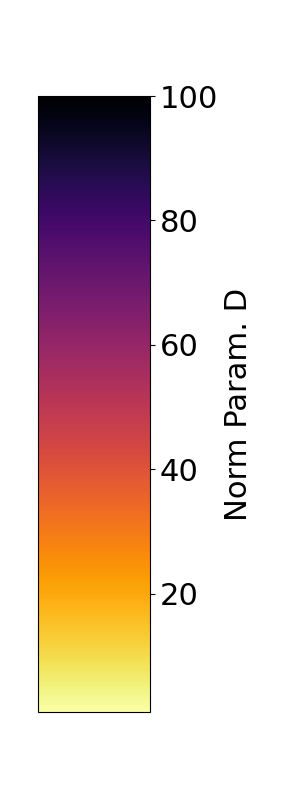

In [94]:
pl.close('all')
# for param in ['x_pos', 'y_pos']:
#     fig = simple_colorbar(vmin=-4,#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.05),
#                 vmax=4,#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.95),
#                 cmap_name=pyc_cmap, ori='horizontal', param_name=param)
for param in ['Norm Param. D']:
    fig = simple_colorbar(vmin=1,#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.05),
                vmax=100,#np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.95),
                cmap_name='inferno_r', ori='vertical', param_name=param)


## New heading

## CVR2 maps tests (neg values not set to zero, median)

In [ ]:
cvrsq_raw_mean = np.mean([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()], axis=0)
cvrsq_raw_median = np.median([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()], axis=0)

cvrsq_raw_number_sj = np.sum([vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd']>0 for sj in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-CVmedian'].keys()], axis=0)


In [ ]:
(cvrsq_raw_mean>0).sum()/len(cvrsq_raw_mean)

In [ ]:
rsq_thresh = 0.0
rsq_max_opacity = 0.15
ds_rsq=dict()
ds_rsq[f"cvrsq_raw_mean"] = cortex.Vertex(cvrsq_raw_mean, subject='999999', 
                                vmin=np.nanquantile(cvrsq_raw_mean,0.1), 
                                vmax=np.nanquantile(cvrsq_raw_mean,0.9), cmap='nipy_spectral')
ds_rsq[f"cvrsq_raw_median"] = cortex.Vertex(cvrsq_raw_median, subject='999999', 
                                vmin=np.nanquantile(cvrsq_raw_median,0.1), 
                                vmax=np.nanquantile(cvrsq_raw_median,0.9), cmap='nipy_spectral')
ds_rsq[f"cvrsq_raw_number_sj"] = cortex.Vertex(cvrsq_raw_number_sj, subject='999999', 
                                vmin=8, 
                                vmax=150, cmap='nipy_spectral')
cortex.webgl.show(ds_rsq)

In [ ]:
from skimage import filters
threshold_yen = filters.threshold_yen(cvrsq_raw_number_sj) #yen=43, otsu=56, isodata=56, li=22, mean=16.54, minimum=89, triangle=8
threshold_otsu = filters.threshold_otsu(cvrsq_raw_number_sj)
threshold_isodata = filters.threshold_isodata(cvrsq_raw_number_sj)
threshold_li = filters.threshold_li(cvrsq_raw_number_sj)
threshold_mean = filters.threshold_mean(cvrsq_raw_number_sj)
threshold_minimum = filters.threshold_minimum(cvrsq_raw_number_sj)
threshold_triangle = filters.threshold_triangle(cvrsq_raw_number_sj)

In [ ]:
thresh

In [ ]:
np.sum(cvrsq_raw_number_sj>thresh)/len(cvrsq_raw_number_sj)

In [ ]:
pl.figure()
pl.hist(cvrsq_raw_number_sj,bins=175)
pl.axvline(threshold_yen, linestyle='--', color='k', label = f"Yen ({threshold_yen:.1f})")
pl.axvline(threshold_otsu, linestyle='--', color='r', label = f"Otsu ({threshold_otsu:.1f})")
pl.axvline(threshold_isodata, linestyle='--', color='g', label = f"Iso ({threshold_isodata:.1f})")
pl.axvline(threshold_li, linestyle='--', color='b', label = f"Li ({threshold_li:.1f})")
pl.axvline(threshold_mean, linestyle='--', color='orange', label = f"Mean ({threshold_mean:.1f})")
pl.axvline(threshold_minimum, linestyle='--', color='pink', label = f"Minimum ({threshold_minimum:.1f})")
pl.axvline(threshold_triangle, linestyle='--', color='yellow', label = f"Triangle ({threshold_triangle:.1f})")
pl.xlabel('# subjects with cvR2>0')
pl.ylabel('# vertices')
pl.yscale('log')
pl.legend()

# Something wrong with subj 115017. investigate

In [ ]:
vis_res.main_dict['HCP']['fit-task-all_fit-runs-all'][sj].keys()

In [ ]:
for sj in vis_res.main_dict['HCP']['fit-task-all_fit-runs-all']:
    print(sj)
    print(vis_res.main_dict['HCP']['fit-task-all_fit-runs-all'][sj]['mask'].sum())
    print(vis_res.main_dict['HCP']['fit-task-all_fit-runs-all'][sj]['Results']['Gauss'].shape)

In [ ]:
#rsqwm have rsq-weighted means over subjects on fsaverage
#maindict_ #allall, allruns_sepcond_rsqwm, 5050CV, allruns_sepcond_zsc, HCP_181subjects_rsqwm, HCP_999999, 99mean181, 99split20, HCP_cv (tcfit), HCP_tc_nocv
with open('/Volumes/Crucial_X8/maindict_HCP_cv.pickle', 'rb') as handle:
    dict_cv=dill.load(handle)

In [ ]:
vis_res.main_dict[space][an_name].keys()

In [ ]:
hcp_group_average = dict()
ds_pyc = dict()
an_name = 'fit-task-all_fit-runs-all'
space = 'fsaverage'  #'HCP'#fsaverage

m = [sj for sj in vis_res.main_dict[space][an_name].keys()]
m.sort()

if space == 'fsaverage':
    pyc_sj = 'fsaverage'
else:
    pyc_sj = '999999'

#cvrsq
weights = np.nan_to_num(np.array([dict_cv[space]['fit-task-BAR_fit-runs-CVmedian'][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in m]))
#noncvrsq
#weights = np.nan_to_num(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results']['RSq']['Norm_abcd'] for sj in m]))

weights[weights<=0] = 0

sj_number_map = np.sum(weights>0, axis=0)
threshold_li = filters.threshold_li(sj_number_map)
print(threshold_li)

for param in ['RSq', 'x_pos', 'y_pos','Norm Param. B','Norm Param. D','Amplitude', 'Surround Amplitude','Size (fwhmax)','Surround Size (fwatmin)','Size (sigma_1)','Size (sigma_2)']:
    if param == 'x_pos':
        data = np.nan_to_num(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results']['Eccentricity']['Norm_abcd'] for sj in m])*np.cos(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results']['Polar Angle']['Norm_abcd'] for sj in m])))
    elif param == 'y_pos':
        data = np.nan_to_num(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results']['Eccentricity']['Norm_abcd'] for sj in m])*np.sin(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results']['Polar Angle']['Norm_abcd'] for sj in m])))
    elif param == 'RSq':
        data = np.copy(weights)
    else:
        data = np.nan_to_num(np.array([vis_res.main_dict[space][an_name][sj]['Processed Results'][param]['Norm_abcd'] for sj in m]))

    if param == 'RSq':
        hcp_group_average[param] = (data*(weights>0)).sum(0)/(weights>0).sum(0)
    else:
        hcp_group_average[param] = (data*weights).sum(0)/weights.sum(0)
    
hcp_group_average['Polar Angle'] = np.arctan2(hcp_group_average['y_pos'], hcp_group_average['x_pos'])
hcp_group_average['Eccentricity'] = np.sqrt(hcp_group_average['y_pos']**2 + hcp_group_average['x_pos']**2) 
hcp_group_average['#Subjects with CVRSq>0'] = np.copy(sj_number_map)


In [ ]:
if space == 'HCP':
    vis_res.main_dict[space][an_name][f'{space}_cvrsq'] = dd(lambda:dd(dict))

for param in hcp_group_average:
    
    vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results'][param]['Norm_abcd'] = np.copy(hcp_group_average[param])
    

vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['RSq']['Norm_abcd']=np.nan_to_num(vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['RSq']['Norm_abcd'])
vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Size ratio (sigma_2/sigma_1)']['Norm_abcd']=vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Size (sigma_2)']['Norm_abcd']/vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Size (sigma_1)']['Norm_abcd']
vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Ratio (B/D)']['Norm_abcd']=vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Norm Param. B']['Norm_abcd']/vis_res.main_dict[space][an_name][f'{space}_cvrsq']['Processed Results']['Norm Param. D']['Norm_abcd']


In [64]:
for param in hcp_group_average:
    if param == 'Polar Angle':
        pyc_cmap = 'hsvx2'
        vmin1 = -3.1415
        vmax1 = 3.1415
    else:
        pyc_cmap = 'nipy_spectral'
        vmin1 = np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.1)
        vmax1 = np.nanquantile(hcp_group_average[param][sj_number_map>threshold_li],0.9)
        
    ds_pyc[f"{param}"] = Vertex2D_fix(hcp_group_average[param], sj_number_map, subject=pyc_sj, 
                                                        vmin=vmin1, 
                                                        vmax=vmax1, 
                                                        vmin2=threshold_li, vmax2=threshold_li+1, cmap=pyc_cmap)

# select path for static viewer on disk
viewer_path = '/Users/marcoaqil/Downloads'

# create viewer
#cortex.webgl.make_static(outpath=viewer_path, data=ds_pyc, recache=True)
cortex.webgl.show(ds_pyc)

/Users/marcoaqil/pycortex/cortex/dataset/views.py:207: UserWarning: Trying to register the cmap 'hsvx2' which already exists.
  cm.register_cmap(self.cmap,cmap)


Started server on port 49808


<JS: window.viewer>

In [11]:
for space, space_res in vis_res.main_dict.items(): 
    print(space)
    if space == 'fsnative' or space == 'HCP':
        for analysis, analysis_res in space_res.items():
            print(analysis)
            for subj, subj_res in analysis_res.items():
                print(subj)

marcus_dict = deepcopy(vis_res.main_dict['fsnative']['fit-task-2R_fit-runs-all']['sub-006'])
marcus_dict['idx_rois'] = deepcopy(vis_res.idx_rois['sub-006'])
with open('/Volumes/Crucial_X8/marcus_dict.pickle', 'wb') as handle:
     dill.dump(marcus_dict, handle)

fsnative
fit-task-1R_fit-runs-all
sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
fit-task-1S_fit-runs-all
sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
fit-task-2R_fit-runs-all
sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
fit-task-4F_fit-runs-all
sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
fit-task-4R_fit-runs-all
sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
fsaverage
T1w


In [16]:
for space, space_res in vis_res.main_dict.items(): 
    print(space)
    if space == 'fsaverage':#'fsnative' or space == 'HCP':
        for analysis, analysis_res in space_res.items():
            print(analysis)
            for subj, subj_res in analysis_res.items():
                print(subj)
                if 'fsaverage' not in subj:
                    for model in ['Norm_abcd']:
                        #subj_res['Processed Results']['D/C'][model] = subj_res['Processed Results']['Norm Param. D'][model]/subj_res['Processed Results']['Surround Amplitude'][model]
                        #subj_res['Processed Results']['B/C'][model] = subj_res['Processed Results']['Norm Param. B'][model]/subj_res['Processed Results']['Surround Amplitude'][model]
                        #subj_res['Processed Results']['B/A'][model] = subj_res['Processed Results']['Norm Param. B'][model]/subj_res['Processed Results']['Amplitude'][model] 
                        #subj_res['Processed Results']['D/A'][model] = subj_res['Processed Results']['Norm Param. D'][model]/subj_res['Processed Results']['Amplitude'][model] 
                        
#                         l2norm_abcd = np.sqrt(subj_res['Processed Results']['Norm Param. D'][model]**2+subj_res['Processed Results']['Norm Param. B'][model]**2+subj_res['Processed Results']['Surround Amplitude'][model]**2+subj_res['Processed Results']['Amplitude'][model]**2)
                        
#                         subj_res['Processed Results']['A/l2norm_abcd'][model] = subj_res['Processed Results']['Amplitude'][model]/l2norm_abcd         
#                         subj_res['Processed Results']['B/l2norm_abcd'][model] = subj_res['Processed Results']['Norm Param. B'][model]/l2norm_abcd
#                         subj_res['Processed Results']['C/l2norm_abcd'][model] = subj_res['Processed Results']['Surround Amplitude'][model]/l2norm_abcd
                        
#                         subj_res['Processed Results']['D/l2norm_abcd'][model] = subj_res['Processed Results']['Norm Param. D'][model]/l2norm_abcd

                        #subj_res['Processed Results']['C/(A+B)'][model] =  subj_res['Processed Results']['Surround Amplitude'][model]/(subj_res['Processed Results']['Amplitude'][model]+subj_res['Processed Results']['Norm Param. B'][model])
#                          subj_res['Processed Results']['C/A'][model] =  subj_res['Processed Results']['Surround Amplitude'][model]/subj_res['Processed Results']['Amplitude'][model]
#                          subj_res['Processed Results']['D/(A+B)'][model] =  subj_res['Processed Results']['Norm Param. D'][model]/(subj_res['Processed Results']['Amplitude'][model]+subj_res['Processed Results']['Norm Param. B'][model])

#                          subj_res['Processed Results']['C/D'][model] =  subj_res['Processed Results']['Surround Amplitude'][model]/subj_res['Processed Results']['Norm Param. D'][model]
#                          subj_res['Processed Results']['C/B'][model] = subj_res['Processed Results']['Surround Amplitude'][model]/subj_res['Processed Results']['Norm Param. B'][model]
                        
                          subj_res['Processed Results']['C/(A+B+D)'][model] =  subj_res['Processed Results']['Surround Amplitude'][model]/(subj_res['Processed Results']['Amplitude'][model]+subj_res['Processed Results']['Norm Param. B'][model]\
                                                                                                                                           +subj_res['Processed Results']['Norm Param. D'][model])
        
#                         subj_res['Processed Results']['A/B'][model] = subj_res['Processed Results']['Amplitude'][model]/subj_res['Processed Results']['Norm Param. B'][model]
#                         subj_res['Processed Results']['A/D'][model] = subj_res['Processed Results']['Amplitude'][model]/subj_res['Processed Results']['Norm Param. D'][model] 
                        
#                         subj_res['Processed Results']['Nvol/D'][model] = (2*np.pi*subj_res['Processed Results']['Surround Amplitude'][model]*subj_res['Processed Results']['Size (sigma_2)'][model]**2)/subj_res['Processed Results']['Norm Param. D'][model]         
#                         subj_res['Processed Results']['Nvol/B'][model] = (2*np.pi*subj_res['Processed Results']['Surround Amplitude'][model]*subj_res['Processed Results']['Size (sigma_2)'][model]**2)/subj_res['Processed Results']['Norm Param. B'][model]
#                         subj_res['Processed Results']['Avol/B'][model] = (2*np.pi*subj_res['Processed Results']['Amplitude'][model]*subj_res['Processed Results']['Size (sigma_1)'][model]**2)/subj_res['Processed Results']['Norm Param. B'][model]       
#                         subj_res['Processed Results']['Avol/D'][model] = (2*np.pi*subj_res['Processed Results']['Amplitude'][model]*subj_res['Processed Results']['Size (sigma_1)'][model]**2)/subj_res['Processed Results']['Norm Param. D'][model]

HCP
fsaverage
fit-task-BAR_fit-runs-CVmedian
140117
146937
150423
128935
102816
572045
601127
765864
221319
861456
966975
562345
412528
878877
191841
102311
125525
169444
365343
942658


/var/folders/vb/gdqfj5px0gb7r_bgl5hpf8n00000gn/T/ipykernel_77737/1180333340.py:30: RuntimeWarning: invalid value encountered in divide
  subj_res['Processed Results']['C/(A+B+D)'][model] =  subj_res['Processed Results']['Surround Amplitude'][model]/(subj_res['Processed Results']['Amplitude'][model]+subj_res['Processed Results']['Norm Param. B'][model]\


187345
257845
525541
131217
144226
177140
617748
757764
137128
246133
385046
818859
177645
115825
573249
782561
182739
115017
185442
654552
901442
825048
732243
192439
910241
159239
104416
995174
826353
191033
148133
131722
132118
177746
401422
467351
644246
162935
360030
901139
406836
814649
204521
146129
171633
158136
214524
724446
169747
105923
109123
175237
233326
581450
927359
878776
134627
898176
249947
130518
116726
771354
167036
135124
130114
164131
157336
118225
178647
395756
436845
690152
176542
197348
193845
186949
397760
200614
146735
926862
196144
169343
550439
751550
155938
181232
725751
789373
330324
126426
251833
283543
871762
114823
380036
156334
389357
180533
958976
205220
191336
318637
627549
859671
381038
393247
201515
833249
541943
200210
158035
971160
165436
169040
200311
195041
463040
203418
172130
178243
770352
352738
943862
547046
346137
100610
134829
783462
164636
167440
192641
199655
899885
638049
182436
209228
671855
145834
872764
263436
111514
905147
212419

In [74]:
for space, space_res in vis_res.main_dict.items(): 
    print(space)
    if space == 'fsaverage':#'fsnative' or space == 'HCP':
        for analysis, analysis_res in space_res.items():
            print(analysis)
            for subj, subj_res in analysis_res.items():
                print(subj)
                for model in ['Norm_abcd']:
                    subj_res['Processed Results']['D*sr'][model] = subj_res['Processed Results']['Norm Param. D'][model]*subj_res['Processed Results']['Size ratio (sigma_2/sigma_1)'][model]
                    subj_res['Processed Results']['B*sr'][model] = subj_res['Processed Results']['Norm Param. B'][model]*subj_res['Processed Results']['Size ratio (sigma_2/sigma_1)'][model]

fsaverage
fit-task-BAR_fit-runs-all
fsaverage_cvrsq
fsaverage_cvrsq_2ndhalf
fsaverage_cvrsq_1sthalf


## meanrsq

In [ ]:

array([['169444', '0.08918824004141666'],
       ['186949', '0.12074691232428045'],
       ['826353', '0.14037514835794992'],
       ['115825', '0.14429546731028478'],
       ['878776', '0.14586836114597682'],
       ['263436', '0.149173603817951'],
       ['178243', '0.15077915852132037'],
       ['393247', '0.15384212102806194'],
       ['958976', '0.1559018792503066'],
       ['995174', '0.15802232666193214'],
       ['130518', '0.1592389540634081'],
       ['102816', '0.16107043232679366'],
       ['901442', '0.16175995201729582'],
       ['102311', '0.1634009165882218'],
       ['221319', '0.16460235175686377'],
       ['389357', '0.16586765747719212'],
       ['200614', '0.16715393127986186'],
       ['100610', '0.16818557142360374'],
       ['966975', '0.17290256996228104'],
       ['169040', '0.17470355395363865'],
       ['562345', '0.17517712370812502'],
       ['145834', '0.17540587698094914'],
       ['581450', '0.1770071170162273'],
       ['320826', '0.17715955169660225'],
       ['177645', '0.17749059885590177'],
       ['436845', '0.17793154332035674'],
       ['550439', '0.17843317546110202'],
       ['732243', '0.1799407852821181'],
       ['833249', '0.18095272402472068'],
       ['169343', '0.1811093268579394'],
       ['818859', '0.1814062930490626'],
       ['572045', '0.18235016649424401'],
       ['352738', '0.18255001756756312'],
       ['164131', '0.1826808806288776'],
       ['861456', '0.1832382929506353'],
       ['204521', '0.18351067617657674'],
       ['134829', '0.18353845180037873'],
       ['724446', '0.18354247424792458'],
       ['927359', '0.18435919767981226'],
       ['167440', '0.1854423236534312'],
       ['173334', '0.18584067321097'],
       ['125525', '0.18598965003201995'],
       ['178142', '0.18738087166392753'],
       ['156334', '0.1876962251621903'],
       ['115017', '0.1883833508331396'],
       ['346137', '0.19017592045080164'],
       ['158136', '0.19124463019765367'],
       ['943862', '0.19147201308910747'],
       ['901139', '0.1920666949554687'],
       ['783462', '0.19261498028421295'],
       ['132118', '0.19268564374579042'],
       ['108323', '0.19406049579342813'],
       ['246133', '0.1944409892617005'],
       ['140117', '0.19452890964788477'],
       ['175237', '0.19454247486583956'],
       ['191841', '0.19497801285649055'],
       ['178647', '0.19606452169912003'],
       ['782561', '0.19652432906363596'],
       ['164636', '0.19655860584378454'],
       ['193845', '0.1967438465131949'],
       ['385046', '0.1976967017756247'],
       ['412528', '0.19777283412598026'],
       ['971160', '0.19852961139707864'],
       ['233326', '0.1987421214463424'],
       ['131722', '0.1997764842125972'],
       ['159239', '0.19993890832485936'],
       ['169747', '0.20033384892480643'],
       ['872764', '0.20199220016357888'],
       ['249947', '0.20272163997916445'],
       ['150423', '0.20327543573524132'],
       ['380036', '0.2036648120702137'],
       ['751550', '0.2049126450363511'],
       ['541943', '0.20492247852691828'],
       ['104416', '0.20554029866599338'],
       ['283543', '0.20575358080293363'],
       ['725751', '0.20589984162428476'],
       ['182739', '0.20621147931085257'],
       ['200311', '0.20648431923901076'],
       ['118225', '0.207073109097825'],
       ['146129', '0.2071143503635318'],
       ['765864', '0.20734835961000814'],
       ['192439', '0.20749719332843644'],
       ['182436', '0.20753346100435854'],
       ['617748', '0.2078953469721072'],
       ['330324', '0.2080159818789499'],
       ['547046', '0.20852213677081155'],
       ['360030', '0.20877246277870248'],
       ['109123', '0.20887793665935625'],
       ['157336', '0.20950778883022664'],
       ['381038', '0.2096912297601953'],
       ['155938', '0.20988432442388333'],
       ['162935', '0.20989732482480647'],
       ['706040', '0.2109262462596618'],
       ['116726', '0.21098479133024073'],
       ['128935', '0.21130988547472546'],
       ['239136', '0.2116144242603923'],
       ['158035', '0.2123355846373427'],
       ['205220', '0.21255718281237926'],
       ['212419', '0.21285952913172454'],
       ['429040', '0.21302375436150794'],
       ['185442', '0.21316515339617662'],
       ['171633', '0.21445969625302042'],
       ['131217', '0.2150493010775303'],
       ['200210', '0.2155893757638865'],
       ['130114', '0.21615554499560347'],
       ['318637', '0.21627177333583472'],
       ['111514', '0.2165945831329664'],
       ['644246', '0.21697640608953286'],
       ['601127', '0.21707921558268045'],
       ['187345', '0.2178522615989559'],
       ['627549', '0.21786312402476782'],
       ['176542', '0.21802721626102645'],
       ['148133', '0.21868929370950138'],
       ['144226', '0.2189026174100038'],
       ['525541', '0.2192467371052229'],
       ['146735', '0.21941561434344545'],
       ['180533', '0.2198335854396083'],
       ['177140', '0.21988770475679262'],
       ['573249', '0.21993534987139704'],
       ['905147', '0.2200566728740847'],
       ['638049', '0.2201236628521382'],
       ['878877', '0.22134786790190772'],
       ['257845', '0.22150151819616196'],
       ['397760', '0.2232855272816353'],
       ['898176', '0.22331494571884364'],
       ['214524', '0.2249847304313198'],
       ['680957', '0.2274195458186514'],
       ['126426', '0.22761666637388386'],
       ['251833', '0.22763401093677554'],
       ['209228', '0.2277009356513807'],
       ['172130', '0.22774134710195432'],
       ['134627', '0.22787976557832296'],
       ['365343', '0.22793107227697237'],
       ['467351', '0.22796977972315302'],
       ['771354', '0.22905296135728062'],
       ['198653', '0.22942118005264664'],
       ['690152', '0.2294527244901441'],
       ['105923', '0.2299212478693106'],
       ['191336', '0.23018100619376516'],
       ['114823', '0.2302788403078945'],
       ['401422', '0.23063038149505574'],
       ['789373', '0.23142387699935932'],
       ['135124', '0.23169502929259292'],
       ['196144', '0.2318551749935031'],
       ['197348', '0.23200129233361122'],
       ['395756', '0.2320262826729533'],
       ['214019', '0.2322611437301178'],
       ['203418', '0.2324504789667681'],
       ['406836', '0.23292225020024127'],
       ['926862', '0.23367918700873364'],
       ['463040', '0.23393669362946037'],
       ['825048', '0.23450441273225078'],
       ['167036', '0.23495363326040267'],
       ['199655', '0.2358052332427025'],
       ['181232', '0.23699690080079294'],
       ['177746', '0.2371183065041936'],
       ['191033', '0.2383001610370215'],
       ['195041', '0.23896297750784906'],
       ['871762', '0.24120868933895429'],
       ['192641', '0.24273577628152146'],
       ['757764', '0.24308757977055173'],
       ['899885', '0.24321066891770393'],
       ['942658', '0.24335025286109335'],
       ['671855', '0.2474430091890822'],
       ['165436', '0.24828055021328113'],
       ['859671', '0.2546276144216892'],
       ['814649', '0.25564992256260816'],
       ['910241', '0.2576472323479812'],
       ['770352', '0.26105663753319513'],
       ['146937', '0.2630996139083668'], nice stuff
       ['137128', '0.2780790344544725']]

In [39]:
allsjmrsq = np.array([[key,vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'][key]['Processed Results']['RSq']['Norm_abcd'][vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'][key]['Processed Results']['RSq']['Norm_abcd']>0.05].mean()] for key in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'].keys()])


In [40]:
allsjmd = np.array([[key,vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'][key]['Processed Results']['Norm Param. D']['Norm_abcd'][vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'][key]['Processed Results']['RSq']['Norm_abcd']>0.05].mean()] for key in vis_res.main_dict['HCP']['fit-task-BAR_fit-runs-all'].keys()])
allsjmd[np.argsort(allsjmrsq[:,1])]

array([['169444', '43.22156220135457'],
       ['186949', '37.00118486601094'],
       ['826353', '24.225650957840887'],
       ['115825', '33.954419392876105'],
       ['878776', '39.03999915261657'],
       ['263436', '35.15923335395729'],
       ['178243', '27.608323078876193'],
       ['393247', '47.98431381779054'],
       ['958976', '43.033786514306456'],
       ['995174', '40.89976050958901'],
       ['130518', '46.75417766881869'],
       ['102816', '38.62186249469877'],
       ['901442', '43.22513344006574'],
       ['102311', '43.3275306231528'],
       ['221319', '53.18494472093604'],
       ['389357', '31.062497386943097'],
       ['200614', '35.50346992309539'],
       ['100610', '41.99665565689131'],
       ['966975', '52.07532580614499'],
       ['169040', '46.614096040974616'],
       ['562345', '48.3775180250005'],
       ['145834', '43.51759602093832'],
       ['581450', '46.21225734227177'],
       ['320826', '36.483133430646475'],
       ['177645', '47.7233179243244